In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision.models as models

from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_next_available_dir(root_dir):
    """
    If a directory at 'root_dir' exists, append a number to create a new path.
    For example, if 'RUN' exists, this returns 'RUN_01', and so on.
    """
    if not os.path.exists(root_dir):
        return root_dir

    i = 1
    new_dir = f"{root_dir}_{str(i).zfill(2)}"

    while os.path.exists(new_dir):
        i += 1
        new_dir = f"{root_dir}_{str(i).zfill(2)}"

    return new_dir

In [3]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3
epochs_optimal_lr = 3
patience_teacher = 6
patience_student = 6
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_teacher = [0]
lmda_list_student = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# SPECIFY OUT DIR NAME
# Create directory and file path to save all outputs
directory_name = 'Smaller_Student_Models_Not_Pretrained'
# This will append version to end of directory name and create new directory if already exists
output_dir = get_next_available_dir(directory_name)

os.makedirs(output_dir, exist_ok=True)

In [4]:
# Paths for subdirectories inside output_dir
models_dir = os.path.join(output_dir, 'models')
weights_dir = os.path.join(output_dir, 'weights')

# Create the subdirectories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Initialize EfficientNet B2
efficientnet_b2 = models.efficientnet_b2(pretrained=False)
efficientnet_b2.classifier[1] = nn.Linear(efficientnet_b2.classifier[1].in_features, num_classes)

# Initialize EfficientNet B1
efficientnet_b1 = models.efficientnet_b1(pretrained=False)
efficientnet_b1.classifier[1] = nn.Linear(efficientnet_b1.classifier[1].in_features, num_classes)

# Initialize EfficientNet B0
efficientnet_b0 = models.efficientnet_b0(pretrained=False)
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, num_classes)

# Initialize MobileNetV2
student_model_mobilenetv2 = models.mobilenet_v2(pretrained=False)
student_model_mobilenetv2.classifier[1] = nn.Linear(student_model_mobilenetv2.classifier[1].in_features, num_classes)

# Initialize ShuffleNet
student_model_shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
num_features = student_model_shufflenet.fc.in_features
student_model_shufflenet.fc = nn.Linear(num_features, num_classes)

# Initialize SqueezeNet
student_model_squeezenet = models.squeezenet1_0(pretrained=True)
student_model_squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
student_model_squeezenet.num_classes = num_classes

class CustomXSCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomXSCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling
        self.fc1 = nn.Linear(10, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.adaptive_pool(x)  # Apply adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x


class CustomSmallCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomSmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(20, 40, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling
        self.fc1 = nn.Linear(40, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)  # Apply adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x


class CustomMediumCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomMediumCNN, self).__init__()
        # More layers and larger channels compared to CustomSmallCNN
        self.conv1 = nn.Conv2d(3, 30, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(30, 60, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling
        self.fc1 = nn.Linear(60, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)  # Apply adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x


class CustomLargeCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomLargeCNN, self).__init__()
        # Even more layers and larger channels compared to CustomMediumCNN
        self.conv1 = nn.Conv2d(3, 60, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(60, 120, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(120, 240, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling
        self.fc1 = nn.Linear(240, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.adaptive_pool(x)  # Apply adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x


# Initialize Custom Ultra Tiny CNN
student_model_custom_xs_cnn = CustomXSCNN(num_classes=num_classes)
student_model_custom_small_cnn = CustomSmallCNN(num_classes=num_classes)
student_model_custom_medium_cnn = CustomMediumCNN(num_classes=num_classes)
student_model_custom_large_cnn = CustomLargeCNN(num_classes=num_classes)


In [6]:
# Count parameters
total_params_efficientnet_b2 = count_parameters(efficientnet_b2)
total_params_efficientnet_b1 = count_parameters(efficientnet_b1)
total_params_efficientnet_b0 = count_parameters(efficientnet_b0)
total_params_mobilenetv2 = count_parameters(student_model_mobilenetv2)
total_params_shufflenet = count_parameters(student_model_shufflenet)
total_params_squeezenet = count_parameters(student_model_squeezenet)
total_params_custom_xs_cnn = count_parameters(student_model_custom_xs_cnn)
total_params_custom_small_cnn = count_parameters(student_model_custom_small_cnn)
total_params_custom_medium_cnn = count_parameters(student_model_custom_medium_cnn)
total_params_custom_large_cnn = count_parameters(student_model_custom_large_cnn)

print(f"EfficientNet B2 Total Parameters: {total_params_efficientnet_b2}")
print(f"EfficientNet B1 Total Parameters: {total_params_efficientnet_b1}")
print(f"EfficientNet B0 Total Parameters: {total_params_efficientnet_b0}")
print(f"MobileNetV2 Total Parameters: {total_params_mobilenetv2}")
print(f"ShuffleNet Total Parameters: {total_params_shufflenet}")
print(f"SqueezeNet Total Parameters: {total_params_squeezenet}")
print(f"Custom XS CNN Total Parameters: {total_params_custom_xs_cnn}")
# print(f"Custom Small CNN Total Parameters: {total_params_custom_small_cnn}")
# print(f"Custom Medium CNN Total Parameters: {total_params_custom_medium_cnn}")
# print(f"Custom Large CNN Total Parameters: {total_params_custom_large_cnn}")


EfficientNet B2 Total Parameters: 7723538
EfficientNet B1 Total Parameters: 6533680
EfficientNet B0 Total Parameters: 4028044
MobileNetV2 Total Parameters: 2244368
ShuffleNet Total Parameters: 1270004
SqueezeNet Total Parameters: 743632
Custom XS CNN Total Parameters: 456


In [7]:
# List of student models
student_models = [
    student_model_custom_xs_cnn,
    student_model_custom_small_cnn,
    student_model_custom_medium_cnn,
    student_model_custom_large_cnn,
    efficientnet_b2, 
    efficientnet_b1, 
    efficientnet_b0, 
    student_model_mobilenetv2, 
    student_model_shufflenet, 
    student_model_squeezenet
]


In [8]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [9]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [10]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [11]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [12]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [13]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [14]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [15]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [16]:
len(train_dataset)

10324

In [17]:
# def print_batch_class_counts(data_loader, label_mapping, num_batches=5):
#     for i, batch in enumerate(data_loader):
#         if i >= num_batches:
#             break

#         # Extract labels from the batch
#         labels = batch['label']

#         # Count occurrences of each class
#         class_counts = torch.bincount(labels)

#         # Map class counts to class names
#         class_counts_with_names = {label_mapping.get(j, f"Unknown Class {j}"): class_counts[j].item() for j in range(len(class_counts))}

#         # Print class counts and total observations
#         print(f"Batch {i + 1}:")
#         for class_name, count in class_counts_with_names.items():
#             print(f"    {class_name}: {count}")
#         print(f"Total Observations: {len(labels)}\n")

# print_batch_class_counts(trainloader, new_label_mapping)


# Start Training Process

In [18]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix

In [19]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [20]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()


In [21]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)

In [22]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)

In [23]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        adversary_output = adv(student_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)

In [24]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()

In [25]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [26]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [27]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [28]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [29]:
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            adversary_output = adv(teacher_outputs_detached)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                adversary_output_val = adv(teacher_outputs_detached_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity

            # Save the teacher model and its state to the 'output_dir'
            teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
            torch.save(teacher_model.state_dict(), teacher_model_weights_path)
            
            teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_checkpoint{i}.pth')
            torch.save(teacher_model, teacher_model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")

        print(f"Data has been appended to {file_path}")
        
    plot_loss_curve(val_losses)
    print(f"Finished Training Teacher for lambda val of {lmda}")
    return val_disparities



def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizers, optimizera, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        student.train()
        student.to(device)
        if lmda != 0:
            adv.train()
            adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizers.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # Run the adversarial model on concatenated true labels, and predicted labels
            if lmda != 0:
                optimizera.zero_grad()
                studentached = student_outputs.detach()
                with torch.no_grad():
                    adversary_output = adv(studentached)
                adversary_loss = adv_criterion(adversary_output, targets)
                
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()

            optimizers.step()
            if lmda != 0:
                optimizera.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        student_epoch_losses.append(epoch_loss)

        student.eval()
        adv.eval()
        adv.to(device)
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)
                if lmda != 0:
                    val_studentached = val_student_outputs.detach()   

                    val_adversary_output = adv(val_studentached)
                    val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                    
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                    
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            state_dict_path = os.path.join(output_dir, f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student.state_dict(), state_dict_path)
            model_path = os.path.join(output_dir, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'student_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        print(f"Data has been appended to {file_path}")

    plot_loss_curve(val_losses)
    print(f'Finished Training Student for lambda value of {lmda}')
    return val_disparities


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 1/100*****
*****Train Loss:  1.568167 Val Loss:  1.185272*****
*****Validation Accuracy: 64.33%*****
*****Total Avg Disparity: 0.14308733568658713*****

Class Team_Sports: Recall Difference = 0.11233734334121614
Class Celebration: Recall Difference = -4.950495049504955e-05
Class Parade: Recall Difference = -0.08522727272727293
Class Waiter_Or_Waitress: Recall Difference = 0.03970981290568909
Class Individual_Sports: Recall Difference = -0.2409098002496879
Class Surgeons: Recall Difference = -0.021433850702143487
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.14647887323943665
Class Business: Recall Difference = 0.009475141062493364
Class Dresses: Recall Difference = -0.5518962075848304
Class Water_Activities: Recall Difference = 0.06440281030444961
Class Picnic: Recall Difference = -0.23529411764705882
Class Rescue: Recall Difference = 0.15160427807486637
Class Cheering: Recall Difference = 0.06894435351882156
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 2/100*****
*****Train Loss:  0.838583 Val Loss:  1.201172*****
*****Validation Accuracy: 64.99%*****
*****Total Avg Disparity: 0.1255373037752232*****

Class Team_Sports: Recall Difference = 0.13932206875278463
Class Celebration: Recall Difference = -0.000544554455445545
Class Parade: Recall Difference = -0.014204545454545525
Class Waiter_Or_Waitress: Recall Difference = -0.0733104238258877
Class Individual_Sports: Recall Difference = -0.15429931335830216
Class Surgeons: Recall Difference = -0.07464892830746483
Class Spa: Recall Difference = -0.12499999999999989
Class Law_Enforcement: Recall Difference = 0.15798122065727704
Class Business: Recall Difference = -0.0021292451825828396
Class Dresses: Recall Difference = -0.6357285429141717
Class Water_Activities: Recall Difference = 0.06376410474771144
Class Picnic: Recall Difference = -0.24183006535947715
Class Rescue: Recall Difference = 0.03636363636363643
Class Cheering: Recall Difference = 0.0077741407528642
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 3/100*****
*****Train Loss:  0.432331 Val Loss:  1.379480*****
*****Validation Accuracy: 63.72%*****
*****Total Avg Disparity: 0.10302982521844375*****

Class Team_Sports: Recall Difference = 0.1331870994276314
Class Celebration: Recall Difference = 0.02514851485148517
Class Parade: Recall Difference = -0.018939393939394034
Class Waiter_Or_Waitress: Recall Difference = -0.1905307369224895
Class Individual_Sports: Recall Difference = -0.1647159800249688
Class Surgeons: Recall Difference = -0.17886178861788615
Class Spa: Recall Difference = -0.08333333333333326
Class Law_Enforcement: Recall Difference = 0.08568075117370899
Class Business: Recall Difference = 0.07196848717129778
Class Dresses: Recall Difference = -0.218562874251497
Class Water_Activities: Recall Difference = 0.03640621673408562
Class Picnic: Recall Difference = -0.28104575163398693
Class Rescue: Recall Difference = 0.06229946524064167
Class Cheering: Recall Difference = 0.03150572831423887
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 4/100*****
*****Train Loss:  0.230879 Val Loss:  1.599392*****
*****Validation Accuracy: 61.82%*****
*****Total Avg Disparity: 0.15600613294146115*****

Class Team_Sports: Recall Difference = 0.10655653425643496
Class Celebration: Recall Difference = -0.030148514851485064
Class Parade: Recall Difference = -0.05113636363636376
Class Waiter_Or_Waitress: Recall Difference = -0.1351660939289806
Class Individual_Sports: Recall Difference = -0.055828651685393194
Class Surgeons: Recall Difference = -0.24611973392461195
Class Spa: Recall Difference = -0.1874999999999999
Class Law_Enforcement: Recall Difference = 0.08122065727699534
Class Business: Recall Difference = 0.02757372511444689
Class Dresses: Recall Difference = -0.592814371257485
Class Water_Activities: Recall Difference = 0.04598680008516076
Class Picnic: Recall Difference = -0.41830065359477125
Class Rescue: Recall Difference = 0.12272727272727263
Class Cheering: Recall Difference = -0.05360065466448449
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 5/100*****
*****Train Loss:  0.169440 Val Loss:  1.632903*****
*****Validation Accuracy: 64.16%*****
*****Total Avg Disparity: 0.1211927696305034*****

Class Team_Sports: Recall Difference = 0.11638162479578673
Class Celebration: Recall Difference = 0.0342574257425744
Class Parade: Recall Difference = -0.012310606060606077
Class Waiter_Or_Waitress: Recall Difference = -0.022145857197403584
Class Individual_Sports: Recall Difference = -0.12098158551810234
Class Surgeons: Recall Difference = -0.14190687361419063
Class Spa: Recall Difference = -0.14583333333333326
Class Law_Enforcement: Recall Difference = 0.08568075117370888
Class Business: Recall Difference = -0.06494197806877466
Class Dresses: Recall Difference = -0.47504990019960086
Class Water_Activities: Recall Difference = 0.07813497977432404
Class Picnic: Recall Difference = -0.36601307189542487
Class Rescue: Recall Difference = 0.011229946524064227
Class Cheering: Recall Difference = 0.02782324058919805
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 6/100*****
*****Train Loss:  0.120603 Val Loss:  1.702264*****
*****Validation Accuracy: 64.82%*****
*****Total Avg Disparity: 0.154499180065585*****

Class Team_Sports: Recall Difference = 0.12854874273114658
Class Celebration: Recall Difference = -0.10495049504950493
Class Parade: Recall Difference = -0.05397727272727282
Class Waiter_Or_Waitress: Recall Difference = -0.016036655211912998
Class Individual_Sports: Recall Difference = -0.10014825218476897
Class Surgeons: Recall Difference = -0.15447154471544722
Class Spa: Recall Difference = -0.20833333333333326
Class Law_Enforcement: Recall Difference = 0.1849765258215963
Class Business: Recall Difference = 0.043436601724688606
Class Dresses: Recall Difference = -0.7065868263473053
Class Water_Activities: Recall Difference = 0.04800936768149877
Class Picnic: Recall Difference = -0.5294117647058825
Class Rescue: Recall Difference = 0.03556149732620317
Class Cheering: Recall Difference = 0.029050736497545027
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 7/100*****
*****Train Loss:  0.105224 Val Loss:  1.781973*****
*****Validation Accuracy: 64.18%*****
*****Total Avg Disparity: 0.15334060218121748*****

Class Team_Sports: Recall Difference = 0.10291211113776833
Class Celebration: Recall Difference = -0.03965346534653463
Class Parade: Recall Difference = -0.042613636363636465
Class Waiter_Or_Waitress: Recall Difference = 0.0683466972126765
Class Individual_Sports: Recall Difference = -0.12425873907615481
Class Surgeons: Recall Difference = -0.17886178861788615
Class Spa: Recall Difference = -0.1874999999999999
Class Law_Enforcement: Recall Difference = 0.11314553990610321
Class Business: Recall Difference = 0.0442882997977217
Class Dresses: Recall Difference = -0.7724550898203593
Class Water_Activities: Recall Difference = 0.024803065786672462
Class Picnic: Recall Difference = -0.36601307189542487
Class Rescue: Recall Difference = 0.13903743315508016
Class Cheering: Recall Difference = 0.025368248772504043
Class Performance_

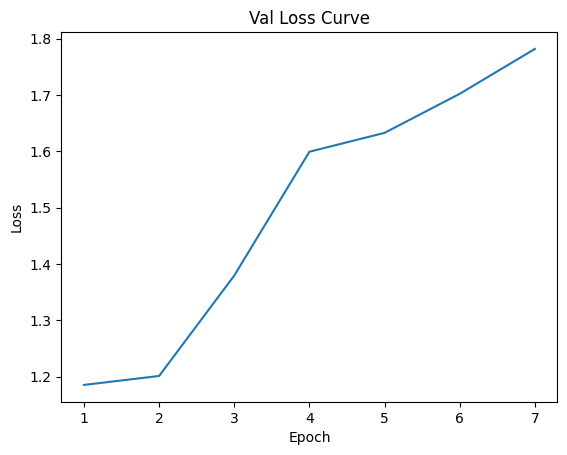

Finished Training Teacher for lambda val of 0
Teacher weights and architecture saved and exported for lambda: 0


In [30]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state to the 'output_dir'
    teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model.state_dict(), teacher_model_weights_path)
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, teacher_model_path)
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 1/100*****
*****Train Loss:  1.329956 Val Loss:  0.879089*****
*****Validation Accuracy: 18.85%*****
*****Total Avg Disparity: 0.011695547992866972*****

Class Team_Sports: Recall Difference = 0.01865624750088546
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.004734848484848484
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.0
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.89it/s]


*****Epoch 2/100*****
*****Train Loss:  1.288478 Val Loss:  0.853001*****
*****Validation Accuracy: 20.55%*****
*****Total Avg Disparity: 0.031710016931615126*****

Class Team_Sports: Recall Difference = 0.025693754212793296
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.037726279650436956
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 3/100*****
*****Train Loss:  1.266843 Val Loss:  0.841504*****
*****Validation Accuracy: 20.72%*****
*****Total Avg Disparity: 0.017199000941432174*****

Class Team_Sports: Recall Difference = 0.01532028652705908
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.01907771535580527
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 4/100*****
*****Train Loss:  1.255138 Val Loss:  0.834831*****
*****Validation Accuracy: 21.04%*****
*****Total Avg Disparity: 0.009265076263831579*****

Class Team_Sports: Recall Difference = 0.006591950280472103
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.011938202247191054
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 5/100*****
*****Train Loss:  1.248730 Val Loss:  0.830771*****
*****Validation Accuracy: 20.92%*****
*****Total Avg Disparity: 0.007933702712365931*****

Class Team_Sports: Recall Difference = 0.00045698095531865324
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.015410424469413209
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 6/100*****
*****Train Loss:  1.243157 Val Loss:  0.826955*****
*****Validation Accuracy: 21.15%*****
*****Total Avg Disparity: 0.00834662423718302*****

Class Team_Sports: Recall Difference = 0.0021021123944658937
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.014591136079900147
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 7/100*****
*****Train Loss:  1.238845 Val Loss:  0.823336*****
*****Validation Accuracy: 21.10%*****
*****Total Avg Disparity: 0.020797263314137948*****

Class Team_Sports: Recall Difference = -0.01330957032365665
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.028284956304619246
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 8/100*****
*****Train Loss:  1.234259 Val Loss:  0.819944*****
*****Validation Accuracy: 21.36%*****
*****Total Avg Disparity: 0.03533201755016527*****

Class Team_Sports: Recall Difference = -0.008671213627172047
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.06199282147315849
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 9/100*****
*****Train Loss:  1.230772 Val Loss:  0.817002*****
*****Validation Accuracy: 21.50%*****
*****Total Avg Disparity: 0.020787246130070908*****

Class Team_Sports: Recall Difference = -0.014257805805943047
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.0368679775280899
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.011235955056179775
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 10/100*****
*****Train Loss:  1.226306 Val Loss:  0.814101*****
*****Validation Accuracy: 21.62%*****
*****Total Avg Disparity: 0.01762495954010436*****

Class Team_Sports: Recall Difference = -0.001987867155636258
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.04728464419475659
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0036023672699202333
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 11/100*****
*****Train Loss:  1.223046 Val Loss:  0.811899*****
*****Validation Accuracy: 21.33%*****
*****Total Avg Disparity: 0.036751193019633074*****

Class Team_Sports: Recall Difference = -0.0352560807028367
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.06015917602996251
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.014838322326100009
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 12/100*****
*****Train Loss:  1.220387 Val Loss:  0.809241*****
*****Validation Accuracy: 21.70%*****
*****Total Avg Disparity: 0.027884293738566712*****

Class Team_Sports: Recall Difference = -0.025430990163484823
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.04381242197253438
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.014409469079680933
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 13/100*****
*****Train Loss:  1.217937 Val Loss:  0.807309*****
*****Validation Accuracy: 21.62%*****
*****Total Avg Disparity: 0.025562676234374044*****

Class Team_Sports: Recall Difference = -0.032662713781403174
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.010416666666666666
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.04115948813982517
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01801183634960117
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_valid

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 14/100*****
*****Train Loss:  1.213936 Val Loss:  0.805618*****
*****Validation Accuracy: 21.62%*****
*****Total Avg Disparity: 0.0205373430605321*****

Class Team_Sports: Recall Difference = -0.04383589813894495
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.010416666666666666
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.025632022471910154
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = -0.004790291675537579
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01801183634960117
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 15/100*****
*****Train Loss:  1.212399 Val Loss:  0.804019*****
*****Validation Accuracy: 21.39%*****
*****Total Avg Disparity: 0.022408029579117715*****

Class Team_Sports: Recall Difference = -0.04807439649952583
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.010416666666666666
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.022979088639201006
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = -0.012987012987012988
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01758298310318209
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretraine

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 16/100*****
*****Train Loss:  1.210256 Val Loss:  0.802341*****
*****Validation Accuracy: 21.62%*****
*****Total Avg Disparity: 0.019906659913815693*****

Class Team_Sports: Recall Difference = -0.0296694885240657
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.010416666666666666
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.03604868913857684
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.011976047904191617
Class Water_Activities: Recall Difference = -0.017777304662550564
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.013551762586842778
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Mod

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 17/100*****
*****Train Loss:  1.208097 Val Loss:  0.800892*****
*****Validation Accuracy: 21.67%*****
*****Total Avg Disparity: 0.02208799809463155*****

Class Team_Sports: Recall Difference = -0.04288766265665889
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.020833333333333332
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.029104244694132364
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.011976047904191617
Class Water_Activities: Recall Difference = -0.017777304662550564
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.009949395316922544
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Mo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 18/100*****
*****Train Loss:  1.205591 Val Loss:  0.799948*****
*****Validation Accuracy: 21.62%*****
*****Total Avg Disparity: 0.04453545104973392*****

Class Team_Sports: Recall Difference = -0.05216437604962809
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.020833333333333332
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.004798689138576839
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.14870259481037923
Class Water_Activities: Recall Difference = -0.03076431764956355
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.009949395316922544
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Model

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 19/100*****
*****Train Loss:  1.203734 Val Loss:  0.798893*****
*****Validation Accuracy: 21.56%*****
*****Total Avg Disparity: 0.04352802198723293*****

Class Team_Sports: Recall Difference = -0.05979595800345017
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.020833333333333332
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.011743133583021259
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.14870259481037923
Class Water_Activities: Recall Difference = -0.017777304662550567
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0023158075306630027
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Mod

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 20/100*****
*****Train Loss:  1.202318 Val Loss:  0.797686*****
*****Validation Accuracy: 21.73%*****
*****Total Avg Disparity: 0.043491447480407654*****

Class Team_Sports: Recall Difference = -0.040991191692086204
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.01515151515151515
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.025632022471910154
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.14870259481037923
Class Water_Activities: Recall Difference = -0.017777304662550564
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01269405609400466
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Mode

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 21/100*****
*****Train Loss:  1.200260 Val Loss:  0.796723*****
*****Validation Accuracy: 21.85%*****
*****Total Avg Disparity: 0.047887528081763726*****

Class Team_Sports: Recall Difference = -0.03171447829911689
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.01515151515151515
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.056882022471910154
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.1367265469061876
Class Water_Activities: Recall Difference = -0.045135192676176286
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.00171541298567629
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Model

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 22/100*****
*****Train Loss:  1.199192 Val Loss:  0.795970*****
*****Validation Accuracy: 21.90%*****
*****Total Avg Disparity: 0.04326370250506141*****

Class Team_Sports: Recall Difference = -0.05161599890324564
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.009469696969696968
Class Waiter_Or_Waitress: Recall Difference = -0.010309278350515464
Class Individual_Sports: Recall Difference = 0.025632022471910154
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.1307385229540918
Class Water_Activities: Recall Difference = -0.061528635299127096
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.013551762586842792
Class Family: Recall Difference = 0.0
Data has been appended to Sma

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 23/100*****
*****Train Loss:  1.197373 Val Loss:  0.794774*****
*****Validation Accuracy: 22.08%*****
*****Total Avg Disparity: 0.04132796101704174*****

Class Team_Sports: Recall Difference = -0.037849447624270116
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.01893939393939394
Class Waiter_Or_Waitress: Recall Difference = -0.020618556701030927
Class Individual_Sports: Recall Difference = 0.056882022471910154
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780437
Class Water_Activities: Recall Difference = -0.040344901000638714
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0018869542842439302
Class Family: Recall Difference = 0.0
Data has been appended to S

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 24/100*****
*****Train Loss:  1.196269 Val Loss:  0.794062*****
*****Validation Accuracy: 22.14%*****
*****Total Avg Disparity: 0.03491637710151778*****

Class Team_Sports: Recall Difference = -0.027076121602632064
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.01420454545454546
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.055243445692883975
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780439
Class Water_Activities: Recall Difference = -0.020545028741750057
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.009520542070503471
Class Family: Recall Difference = -0.00505050505050505
Data has been appended to Sma

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 25/100*****
*****Train Loss:  1.194745 Val Loss:  0.793417*****
*****Validation Accuracy: 22.45%*****
*****Total Avg Disparity: 0.05091001995260515*****

Class Team_Sports: Recall Difference = -0.03934606025293885
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.014204545454545463
Class Waiter_Or_Waitress: Recall Difference = -0.09698358151966399
Class Individual_Sports: Recall Difference = 0.05259051186017483
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = -0.036938471364700874
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.009520542070503485
Class Family: Recall Difference = 0.0
Data has been appended to Smal

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 26/100*****
*****Train Loss:  1.194733 Val Loss:  0.792731*****
*****Validation Accuracy: 22.45%*****
*****Total Avg Disparity: 0.05189264480900365*****

Class Team_Sports: Recall Difference = -0.043436039803041115
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.023674242424242424
Class Waiter_Or_Waitress: Recall Difference = -0.09698358151966399
Class Individual_Sports: Recall Difference = 0.05606273408239704
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361277
Class Water_Activities: Recall Difference = -0.028741750053225462
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.013551762586842792
Class Family: Recall Difference = 0.0
Data has been appended to Sma

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 27/100*****
*****Train Loss:  1.193226 Val Loss:  0.791872*****
*****Validation Accuracy: 22.60%*****
*****Total Avg Disparity: 0.04127977052646719*****

Class Team_Sports: Recall Difference = -0.046577783870857314
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.02746212121212121
Class Waiter_Or_Waitress: Recall Difference = -0.07636502481863307
Class Individual_Sports: Recall Difference = 0.03522940074906372
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361277
Class Water_Activities: Recall Difference = 0.0006387055567383393
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0018869542842439302
Class Family: Recall Difference = 0.0
Data has been appended to Sma

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 28/100*****
*****Train Loss:  1.191874 Val Loss:  0.791177*****
*****Validation Accuracy: 22.54%*****
*****Total Avg Disparity: 0.04651434455697411*****

Class Team_Sports: Recall Difference = -0.05066776342095958
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.046401515151515166
Class Waiter_Or_Waitress: Recall Difference = -0.08247422680412371
Class Individual_Sports: Recall Difference = 0.027465667915106184
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.0006387055567383254
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.017154129856763012
Class Family: Recall Difference = 0.0
Data has been appended to Sma

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 29/100*****
*****Train Loss:  1.191077 Val Loss:  0.790718*****
*****Validation Accuracy: 22.34%*****
*****Total Avg Disparity: 0.05184461561996554*****

Class Team_Sports: Recall Difference = -0.04223646479532983
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.046401515151515166
Class Waiter_Or_Waitress: Recall Difference = -0.05154639175257732
Class Individual_Sports: Recall Difference = 0.0515761548064918
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.023951458377687883
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.046401921262543985
Class Family: Recall Difference = 0.0
Data has been appended to Small

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 30/100*****
*****Train Loss:  1.190023 Val Loss:  0.790452*****
*****Validation Accuracy: 22.80%*****
*****Total Avg Disparity: 0.05148484146918385*****

Class Team_Sports: Recall Difference = -0.042087945984851105
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.04166666666666666
Class Waiter_Or_Waitress: Recall Difference = -0.1176021382206949
Class Individual_Sports: Recall Difference = 0.04564606741573035
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.0006387055567383393
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.023930011150184408
Class Family: Recall Difference = 0.0
Data has been appended to Small

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 31/100*****
*****Train Loss:  1.189718 Val Loss:  0.789360*****
*****Validation Accuracy: 22.71%*****
*****Total Avg Disparity: 0.04527348672104079*****

Class Team_Sports: Recall Difference = -0.04413293575990218
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.040719696969696975
Class Waiter_Or_Waitress: Recall Difference = -0.0660557464681176
Class Individual_Sports: Recall Difference = 0.04381242197253438
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361277
Class Water_Activities: Recall Difference = 0.0006387055567383254
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.02075649712668326
Class Family: Recall Difference = 0.0
Data has been appended to Smalle

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 32/100*****
*****Train Loss:  1.187879 Val Loss:  0.788731*****
*****Validation Accuracy: 22.77%*****
*****Total Avg Disparity: 0.04460010973374094*****

Class Team_Sports: Recall Difference = -0.026276404930824504
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.04450757575757576
Class Waiter_Or_Waitress: Recall Difference = -0.08247422680412371
Class Individual_Sports: Recall Difference = 0.030937890137328394
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.008835426868213744
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.024358864396603494
Class Family: Recall Difference = 0.0
Data has been appended to Smal

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 33/100*****
*****Train Loss:  1.187477 Val Loss:  0.788371*****
*****Validation Accuracy: 23.15%*****
*****Total Avg Disparity: 0.048891385756651376*****

Class Team_Sports: Recall Difference = -0.034856222366932754
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.05397727272727268
Class Waiter_Or_Waitress: Recall Difference = -0.09698358151966399
Class Individual_Sports: Recall Difference = 0.04217384519350814
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942116
Class Water_Activities: Recall Difference = 0.0006387055567383254
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.024787717643022553
Class Family: Recall Difference = 0.0
Data has been appended to Sma

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 34/100*****
*****Train Loss:  1.186808 Val Loss:  0.787688*****
*****Validation Accuracy: 22.94%*****
*****Total Avg Disparity: 0.046027412296760474*****

Class Team_Sports: Recall Difference = -0.05435788463515778
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.03598484848484848
Class Waiter_Or_Waitress: Recall Difference = -0.09278350515463918
Class Individual_Sports: Recall Difference = 0.03952091136079905
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942116
Class Water_Activities: Recall Difference = 0.008835426868213744
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0018869542842439302
Class Family: Recall Difference = 0.0
Data has been appended to Smal

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 35/100*****
*****Train Loss:  1.185417 Val Loss:  0.787224*****
*****Validation Accuracy: 23.32%*****
*****Total Avg Disparity: 0.04615109101073767*****

Class Team_Sports: Recall Difference = -0.02218642538072224
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.03503787878787876
Class Waiter_Or_Waitress: Recall Difference = -0.1176021382206949
Class Individual_Sports: Recall Difference = 0.04482677902621729
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942116
Class Water_Activities: Recall Difference = 0.008835426868213744
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.005746633502015597
Class Family: Recall Difference = 0.0
Data has been appended to Smalle

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 36/100*****
*****Train Loss:  1.184992 Val Loss:  0.786950*****
*****Validation Accuracy: 23.35%*****
*****Total Avg Disparity: 0.043306013968400614*****

Class Team_Sports: Recall Difference = -0.028172875895397076
Class Celebration: Recall Difference = -0.004999999999999999
Class Parade: Recall Difference = 0.053977272727272735
Class Waiter_Or_Waitress: Recall Difference = -0.10729285987017945
Class Individual_Sports: Recall Difference = 0.04482677902621729
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942116
Class Water_Activities: Recall Difference = 0.008835426868213744
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.009520542070503471
Class Family: Recall Difference = 0.0
Data has be

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 37/100*****
*****Train Loss:  1.183935 Val Loss:  0.786381*****
*****Validation Accuracy: 23.15%*****
*****Total Avg Disparity: 0.037802541162076805*****

Class Team_Sports: Recall Difference = -0.03201151592007412
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.006628787878787845
Class Waiter_Or_Waitress: Recall Difference = -0.07636502481863307
Class Individual_Sports: Recall Difference = 0.046465355805243524
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.008835426868213758
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.005489321554164206
Class Family: Recall Difference = 0.0
Data has been appended to Sma

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 38/100*****
*****Train Loss:  1.183782 Val Loss:  0.785648*****
*****Validation Accuracy: 23.29%*****
*****Total Avg Disparity: 0.046998570297302665*****

Class Team_Sports: Recall Difference = -0.03390798688464658
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.018939393939393923
Class Waiter_Or_Waitress: Recall Difference = -0.12791141657121038
Class Individual_Sports: Recall Difference = 0.04482677902621729
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.008835426868213758
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.005746633502015597
Class Family: Recall Difference = 0.0
Data has been appended to Sma

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 39/100*****
*****Train Loss:  1.182585 Val Loss:  0.785503*****
*****Validation Accuracy: 23.26%*****
*****Total Avg Disparity: 0.047985574352699456*****

Class Team_Sports: Recall Difference = -0.04428145457038091
Class Celebration: Recall Difference = -0.005
Class Parade: Recall Difference = 0.023674242424242403
Class Waiter_Or_Waitress: Recall Difference = -0.12791141657121038
Class Individual_Sports: Recall Difference = 0.07322877652933829
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.0006387055567383254
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0203276438802642
Class Family: Recall Difference = 0.0
Data has been appended to Sm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 40/100*****
*****Train Loss:  1.182480 Val Loss:  0.785116*****
*****Validation Accuracy: 23.29%*****
*****Total Avg Disparity: 0.039371426739847976*****

Class Team_Sports: Recall Difference = -0.038146485245227346
Class Celebration: Recall Difference = -0.004999999999999999
Class Parade: Recall Difference = 0.023674242424242403
Class Waiter_Or_Waitress: Recall Difference = -0.07636502481863307
Class Individual_Sports: Recall Difference = 0.054229088639201006
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.008835426868213744
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.019898790633845087
Class Family: Recall Difference = 0.0
Data has b

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 41/100*****
*****Train Loss:  1.181709 Val Loss:  0.784337*****
*****Validation Accuracy: 23.38%*****
*****Total Avg Disparity: 0.0360778445880377*****

Class Team_Sports: Recall Difference = -0.018244964641098593
Class Celebration: Recall Difference = -0.005
Class Parade: Recall Difference = 0.013257575757575746
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.056882022471910154
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = 0.008835426868213758
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01269405609400466
Class Family: Recall Difference = 0.0
Data has been appended to Sm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 42/100*****
*****Train Loss:  1.180681 Val Loss:  0.783704*****
*****Validation Accuracy: 23.46%*****
*****Total Avg Disparity: 0.044650482179824*****

Class Team_Sports: Recall Difference = -0.029566667809119207
Class Celebration: Recall Difference = -0.004999999999999999
Class Parade: Recall Difference = -0.05018939393939395
Class Waiter_Or_Waitress: Recall Difference = -0.1176021382206949
Class Individual_Sports: Recall Difference = 0.04217384519350814
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.004151586118799219
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.019898790633845087
Class Family: Recall Difference = 0.0384615384615384

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 43/100*****
*****Train Loss:  1.180529 Val Loss:  0.783359*****
*****Validation Accuracy: 23.55%*****
*****Total Avg Disparity: 0.046820942930739934*****

Class Team_Sports: Recall Difference = -0.02807005518045036
Class Celebration: Recall Difference = -0.005
Class Parade: Recall Difference = -0.0625
Class Waiter_Or_Waitress: Recall Difference = -0.1176021382206949
Class Individual_Sports: Recall Difference = 0.04564606741573035
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = -0.004151586118799233
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.03113474569002489
Class Family: Recall Difference = 0.038461538461538464
Data has been appended t

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 44/100*****
*****Train Loss:  1.180179 Val Loss:  0.782975*****
*****Validation Accuracy: 23.69%*****
*****Total Avg Disparity: 0.04656488999640643*****

Class Team_Sports: Recall Difference = -0.034604882841507645
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.0625
Class Waiter_Or_Waitress: Recall Difference = -0.10729285987017945
Class Individual_Sports: Recall Difference = 0.046465355805243524
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.004151586118799219
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.012694056094004633
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Stude

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 45/100*****
*****Train Loss:  1.178968 Val Loss:  0.782472*****
*****Validation Accuracy: 23.84%*****
*****Total Avg Disparity: 0.039579734146494315*****

Class Team_Sports: Recall Difference = -0.037049730952462556
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.05681818181818182
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.049118289637952506
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.012241856504151591
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0018869542842439302
Class Family: Recall Difference = 0.038461538

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 46/100*****
*****Train Loss:  1.178516 Val Loss:  0.782541*****
*****Validation Accuracy: 23.72%*****
*****Total Avg Disparity: 0.041386193926342664*****

Class Team_Sports: Recall Difference = -0.04522969005266719
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.03314393939393939
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.0654650436953807
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.008835426868213744
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0018869542842439302
Class Family: Recall Difference = 0.0384615384615

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 47/100*****
*****Train Loss:  1.177261 Val Loss:  0.781911*****
*****Validation Accuracy: 23.98%*****
*****Total Avg Disparity: 0.03633173549755877*****

Class Team_Sports: Recall Difference = 1.1424523882919146e-05
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.035037878787878785
Class Waiter_Or_Waitress: Recall Difference = -0.08667430316914852
Class Individual_Sports: Recall Difference = 0.046465355805243524
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.012241856504151591
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.030705892443605776
Class Family: Recall Difference = -0.00505050505050505
Data has

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 48/100*****
*****Train Loss:  1.177710 Val Loss:  0.781699*****
*****Validation Accuracy: 24.01%*****
*****Total Avg Disparity: 0.034737502170830006*****

Class Team_Sports: Recall Difference = -0.04128822931304332
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.05303030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.03741886216113022
Class Individual_Sports: Recall Difference = 0.05770131086142327
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.07684630738522955
Class Water_Activities: Recall Difference = -0.004151586118799233
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.012694056094004633
Class Family: Recall Difference = 0.03341103341

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 49/100*****
*****Train Loss:  1.175560 Val Loss:  0.781565*****
*****Validation Accuracy: 23.90%*****
*****Total Avg Disparity: 0.03866312354027823*****

Class Team_Sports: Recall Difference = -0.023283179673487142
Class Celebration: Recall Difference = -0.009999999999999998
Class Parade: Recall Difference = -0.052083333333333315
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.06035424469413231
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.004151586118799233
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0018869542842439302
Class Family: Recall Differen

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 50/100*****
*****Train Loss:  1.176602 Val Loss:  0.780947*****
*****Validation Accuracy: 23.78%*****
*****Total Avg Disparity: 0.04100619323107413*****

Class Team_Sports: Recall Difference = -0.023431698483965757
Class Celebration: Recall Difference = -0.005099009900990098
Class Parade: Recall Difference = -0.051136363636363674
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.054229088639201006
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.004151586118799233
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01672527661034398
Class Family: Recall Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 51/100*****
*****Train Loss:  1.176544 Val Loss:  0.780836*****
*****Validation Accuracy: 24.16%*****
*****Total Avg Disparity: 0.035105432530606114*****

Class Team_Sports: Recall Difference = -0.02028995441614967
Class Celebration: Recall Difference = -0.0050990099009901
Class Parade: Recall Difference = -0.04356060606060602
Class Waiter_Or_Waitress: Recall Difference = -0.037418862161130245
Class Individual_Sports: Recall Difference = 0.0742431335830212
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.020438577815626996
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.001886954284243944
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 52/100*****
*****Train Loss:  1.174494 Val Loss:  0.780316*****
*****Validation Accuracy: 24.07%*****
*****Total Avg Disparity: 0.04080097827856866*****

Class Team_Sports: Recall Difference = -0.016748352012429857
Class Celebration: Recall Difference = -0.015
Class Parade: Recall Difference = -0.06060606060606061
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.05606273408239704
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.020438577815626996
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0021442662320953626
Class Family: Recall Difference = 0.0
Data ha

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 53/100*****
*****Train Loss:  1.175552 Val Loss:  0.779920*****
*****Validation Accuracy: 23.90%*****
*****Total Avg Disparity: 0.04084504197184852*****

Class Team_Sports: Recall Difference = -0.02492831111263427
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.0549242424242424
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.06382646691635463
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.0040451351926762
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.005746633502015597
Class Family: Recall Difference = 0.038461538461538

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 54/100*****
*****Train Loss:  1.174331 Val Loss:  0.779685*****
*****Validation Accuracy: 24.01%*****
*****Total Avg Disparity: 0.044202185184884134*****

Class Team_Sports: Recall Difference = -0.023431698483965757
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.06628787878787878
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.06382646691635463
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.012241856504151605
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.031563598936443976
Class Family: Recall Difference = 0.03846153846

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 55/100*****
*****Train Loss:  1.174135 Val Loss:  0.779527*****
*****Validation Accuracy: 24.18%*****
*****Total Avg Disparity: 0.03975535503882467*****

Class Team_Sports: Recall Difference = 0.018416332499343047
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.030303030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.05259051186017483
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.02043857781562701
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.031134745690024862
Class Family: Recall Difference = 0.0384615384615

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 56/100*****
*****Train Loss:  1.173415 Val Loss:  0.779007*****
*****Validation Accuracy: 24.04%*****
*****Total Avg Disparity: 0.042906114212135915*****

Class Team_Sports: Recall Difference = -0.02861843232683292
Class Celebration: Recall Difference = -0.005099009900990098
Class Parade: Recall Difference = -0.07386363636363635
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.06729868913857684
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.02043857781562701
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.005060468307745092
Class Family: Recall Difference =

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 57/100*****
*****Train Loss:  1.172845 Val Loss:  0.778618*****
*****Validation Accuracy: 24.13%*****
*****Total Avg Disparity: 0.04172590514204089*****

Class Team_Sports: Recall Difference = -0.0083170533868
Class Celebration: Recall Difference = -0.0050990099009901
Class Parade: Recall Difference = -0.06723484848484854
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.054229088639201006
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.012241856504151591
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.019898790633845087
Class Family: Recall Difference = 0.033

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 58/100*****
*****Train Loss:  1.172954 Val Loss:  0.778829*****
*****Validation Accuracy: 24.07%*****
*****Total Avg Disparity: 0.04151332050679516*****

Class Team_Sports: Recall Difference = -0.019490237744342
Class Celebration: Recall Difference = -0.005099009900990098
Class Parade: Recall Difference = -0.06439393939393939
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.07077091136079905
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.01564828614008941
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.005060468307745092
Class Family: Recall Difference = 0.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 59/100*****
*****Train Loss:  1.172015 Val Loss:  0.778052*****
*****Validation Accuracy: 24.36%*****
*****Total Avg Disparity: 0.03712645817828261*****

Class Team_Sports: Recall Difference = 0.0013595183420731516
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.07291666666666666
Class Waiter_Or_Waitress: Recall Difference = -0.037418862161130245
Class Individual_Sports: Recall Difference = 0.06729868913857684
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.00704225352112676
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.020438577815626996
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01543871687108675
Class Family: Recall Difference 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 60/100*****
*****Train Loss:  1.171190 Val Loss:  0.777739*****
*****Validation Accuracy: 24.50%*****
*****Total Avg Disparity: 0.04361572527838477*****

Class Team_Sports: Recall Difference = 0.019364567981629333
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.07765151515151514
Class Waiter_Or_Waitress: Recall Difference = -0.07445589919816725
Class Individual_Sports: Recall Difference = 0.08036828963795262
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.009624413145539905
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = 0.019054715776027256
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.00866283557766534
Class Family: Recall Difference 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 61/100*****
*****Train Loss:  1.171935 Val Loss:  0.777813*****
*****Validation Accuracy: 24.10%*****
*****Total Avg Disparity: 0.04251484169089068*****

Class Team_Sports: Recall Difference = -0.017445247969290922
Class Celebration: Recall Difference = -9.900990099010083e-05
Class Parade: Recall Difference = -0.06818181818181812
Class Waiter_Or_Waitress: Recall Difference = -0.11149293623520429
Class Individual_Sports: Recall Difference = 0.07159019975031206
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.016666666666666663
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.02043857781562701
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.012694056094004633
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 62/100*****
*****Train Loss:  1.171054 Val Loss:  0.777494*****
*****Validation Accuracy: 24.18%*****
*****Total Avg Disparity: 0.04163032014677124*****

Class Team_Sports: Recall Difference = 0.0035530269276026205
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.06723484848484854
Class Waiter_Or_Waitress: Recall Difference = -0.1176021382206949
Class Individual_Sports: Recall Difference = 0.06729868913857684
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.016666666666666666
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.010857994464551823
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0014581010378248715
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 63/100*****
*****Train Loss:  1.170833 Val Loss:  0.777231*****
*****Validation Accuracy: 24.44%*****
*****Total Avg Disparity: 0.0431266978268989*****

Class Team_Sports: Recall Difference = -0.017445247969291033
Class Celebration: Recall Difference = -0.02
Class Parade: Recall Difference = -0.07007575757575757
Class Waiter_Or_Waitress: Recall Difference = -0.12791141657121038
Class Individual_Sports: Recall Difference = 0.04728464419475659
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.016666666666666663
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.012241856504151605
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.00866283557766534
Class Family: Recall Difference 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 64/100*****
*****Train Loss:  1.170658 Val Loss:  0.776677*****
*****Validation Accuracy: 24.42%*****
*****Total Avg Disparity: 0.04728823977536267*****

Class Team_Sports: Recall Difference = 0.010087854588659906
Class Celebration: Recall Difference = -0.02
Class Parade: Recall Difference = -0.07954545454545453
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.08465980024968794
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.026291079812206568
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.01511603150947416
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.001029247791405813
Class Family: Recall Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 65/100*****
*****Train Loss:  1.170847 Val Loss:  0.776681*****
*****Validation Accuracy: 24.62%*****
*****Total Avg Disparity: 0.04359063059332806*****

Class Team_Sports: Recall Difference = 0.012132844363711093
Class Celebration: Recall Difference = -0.015
Class Parade: Recall Difference = -0.06912878787878785
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.08465980024968794
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.009624413145539907
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = -0.002129018522461168
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01946993738742603
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 66/100*****
*****Train Loss:  1.169128 Val Loss:  0.776445*****
*****Validation Accuracy: 24.56%*****
*****Total Avg Disparity: 0.04385636795157724*****

Class Team_Sports: Recall Difference = 0.02385440586763543
Class Celebration: Recall Difference = -0.009999999999999998
Class Parade: Recall Difference = -0.07386363636363635
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.06382646691635463
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.009624413145539903
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361277
Class Water_Activities: Recall Difference = 0.002661273153076446
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01946993738742603
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 67/100*****
*****Train Loss:  1.169091 Val Loss:  0.775971*****
*****Validation Accuracy: 24.65%*****
*****Total Avg Disparity: 0.04065892297520723*****

Class Team_Sports: Recall Difference = -0.015400258194239735
Class Celebration: Recall Difference = -0.015
Class Parade: Recall Difference = -0.08143939393939392
Class Waiter_Or_Waitress: Recall Difference = -0.03741886216113022
Class Individual_Sports: Recall Difference = 0.08895131086142327
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.012206572769953048
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = -0.015116031509474132
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.006175486748434669
Class Family: Recall Differ

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 68/100*****
*****Train Loss:  1.168308 Val Loss:  0.776114*****
*****Validation Accuracy: 24.70%*****
*****Total Avg Disparity: 0.03610100202486844*****

Class Team_Sports: Recall Difference = 0.0034045081171242275
Class Celebration: Recall Difference = -0.015
Class Parade: Recall Difference = -0.07007575757575762
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.05770131086142327
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.0051643192488262935
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.015116031509474118
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0010292477914057852
Class Family: Recall Diffe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 69/100*****
*****Train Loss:  1.169517 Val Loss:  0.775692*****
*****Validation Accuracy: 24.73%*****
*****Total Avg Disparity: 0.03957135299037162*****

Class Team_Sports: Recall Difference = -0.0010853297688818708
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.07007575757575757
Class Waiter_Or_Waitress: Recall Difference = -0.04772814051164567
Class Individual_Sports: Recall Difference = 0.09242353308364548
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.0051643192488262865
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.015116031509474132
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.006175486748434669
Class Family: Recall Diffe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 70/100*****
*****Train Loss:  1.168300 Val Loss:  0.775659*****
*****Validation Accuracy: 24.53%*****
*****Total Avg Disparity: 0.0438346272665014*****

Class Team_Sports: Recall Difference = 0.011036090070946303
Class Celebration: Recall Difference = -0.009999999999999998
Class Parade: Recall Difference = -0.0691287878787879
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.07588171036204738
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.009624413145539903
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361277
Class Water_Activities: Recall Difference = 0.002661273153076446
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01946993738742603
Class Family: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 71/100*****
*****Train Loss:  1.168177 Val Loss:  0.776096*****
*****Validation Accuracy: 24.70%*****
*****Total Avg Disparity: 0.04166328510819676*****

Class Team_Sports: Recall Difference = 0.0065462521849402044
Class Celebration: Recall Difference = -0.02
Class Parade: Recall Difference = -0.08143939393939403
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.08282615480649175
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.009624413145539907
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.002661273153076446
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.001029247791405813
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 72/100*****
*****Train Loss:  1.167819 Val Loss:  0.775676*****
*****Validation Accuracy: 24.50%*****
*****Total Avg Disparity: 0.04661364841517534*****

Class Team_Sports: Recall Difference = 0.021261038946201793
Class Celebration: Recall Difference = -0.019999999999999997
Class Parade: Recall Difference = -0.06912878787878779
Class Waiter_Or_Waitress: Recall Difference = -0.1176021382206949
Class Individual_Sports: Recall Difference = 0.09324282147315849
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.026291079812206568
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.0021290185224611263
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0030019727249335493
Class Family

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 73/100*****
*****Train Loss:  1.167261 Val Loss:  0.775323*****
*****Validation Accuracy: 24.59%*****
*****Total Avg Disparity: 0.03748620253435308*****

Class Team_Sports: Recall Difference = -0.005872205275845199
Class Celebration: Recall Difference = -0.015
Class Parade: Recall Difference = -0.07196969696969702
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.050756866416978796
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.012206572769953045
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.010325739833936545
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0010292477914057852
Class Family: Recall Differ

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 74/100*****
*****Train Loss:  1.167500 Val Loss:  0.774988*****
*****Validation Accuracy: 24.47%*****
*****Total Avg Disparity: 0.044981840451234795*****

Class Team_Sports: Recall Difference = 0.0043527435994105135
Class Celebration: Recall Difference = -0.02
Class Parade: Recall Difference = -0.0776515151515152
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.08465980024968794
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.012206572769953048
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.0069193101979987265
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.004631615061326005
Class Family: Recall Differe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 75/100*****
*****Train Loss:  1.168160 Val Loss:  0.775073*****
*****Validation Accuracy: 24.85%*****
*****Total Avg Disparity: 0.03889213894885972*****

Class Team_Sports: Recall Difference = 0.009139619106373731
Class Celebration: Recall Difference = -0.015
Class Parade: Recall Difference = -0.08712121212121215
Class Waiter_Or_Waitress: Recall Difference = -0.03741886216113022
Class Individual_Sports: Recall Difference = 0.08629837702871407
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.026291079812206568
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.002661273153076446
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.009777854018354903
Class Family: Recall Differen

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 76/100*****
*****Train Loss:  1.167643 Val Loss:  0.774867*****
*****Validation Accuracy: 24.56%*****
*****Total Avg Disparity: 0.04526419305005361*****

Class Team_Sports: Recall Difference = 0.015126069621048455
Class Celebration: Recall Difference = -0.02
Class Parade: Recall Difference = -0.08238636363636365
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.0742431335830212
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.009624413145539907
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.006067702789014265
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.001029247791405813
Class Family: Recall Difference 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 77/100*****
*****Train Loss:  1.166733 Val Loss:  0.774493*****
*****Validation Accuracy: 24.68%*****
*****Total Avg Disparity: 0.04175105005204038*****

Class Team_Sports: Recall Difference = 0.010487712924563741
Class Celebration: Recall Difference = -0.015000000000000001
Class Parade: Recall Difference = -0.0890151515151516
Class Waiter_Or_Waitress: Recall Difference = -0.037418862161130245
Class Individual_Sports: Recall Difference = 0.08118757802746573
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.026291079812206575
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.006067702789014265
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01226520284758556
Class Family: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 78/100*****
*****Train Loss:  1.166134 Val Loss:  0.774398*****
*****Validation Accuracy: 24.62%*****
*****Total Avg Disparity: 0.046470556937201014*****

Class Team_Sports: Recall Difference = -0.026870480172738964
Class Celebration: Recall Difference = -0.014999999999999998
Class Parade: Recall Difference = -0.11837121212121215
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.07240948813982517
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.012206572769953055
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.0069193101979987265
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01946993738742603
Class Family

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 79/100*****
*****Train Loss:  1.166705 Val Loss:  0.774453*****
*****Validation Accuracy: 24.65%*****
*****Total Avg Disparity: 0.04677080494061692*****

Class Team_Sports: Recall Difference = -0.0017822257257430474
Class Celebration: Recall Difference = -0.015099009900990099
Class Parade: Recall Difference = -0.08333333333333331
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.0820068664169788
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.026291079812206568
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.014264424100489698
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0030019727249335493
Class Family:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 80/100*****
*****Train Loss:  1.165562 Val Loss:  0.774139*****
*****Validation Accuracy: 24.82%*****
*****Total Avg Disparity: 0.04157704809514465*****

Class Team_Sports: Recall Difference = 0.01662268224971719
Class Celebration: Recall Difference = -0.019999999999999997
Class Parade: Recall Difference = -0.08333333333333337
Class Waiter_Or_Waitress: Recall Difference = -0.027109583810614762
Class Individual_Sports: Recall Difference = 0.08118757802746573
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.019248826291079813
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.011709601873536313
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.004631615061326005
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 81/100*****
*****Train Loss:  1.165719 Val Loss:  0.773889*****
*****Validation Accuracy: 24.91%*****
*****Total Avg Disparity: 0.038618418135274585*****

Class Team_Sports: Recall Difference = -0.005872205275845199
Class Celebration: Recall Difference = -0.009999999999999998
Class Parade: Recall Difference = -0.0890151515151516
Class Waiter_Or_Waitress: Recall Difference = -0.04772814051164567
Class Individual_Sports: Recall Difference = 0.06117353308364548
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.012206572769953045
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.011709601873536285
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.004631615061326005
Class Family:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 82/100*****
*****Train Loss:  1.165284 Val Loss:  0.773887*****
*****Validation Accuracy: 24.85%*****
*****Total Avg Disparity: 0.04365479990856025*****

Class Team_Sports: Recall Difference = -0.0008339902434565394
Class Celebration: Recall Difference = -0.014999999999999998
Class Parade: Recall Difference = -0.07386363636363635
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.07588171036204738
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.0051643192488262935
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361277
Class Water_Activities: Recall Difference = 0.004683840749414525
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.030705892443605776
Class Family

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 83/100*****
*****Train Loss:  1.165941 Val Loss:  0.773496*****
*****Validation Accuracy: 24.73%*****
*****Total Avg Disparity: 0.0421891632084555*****

Class Team_Sports: Recall Difference = -0.018142143926151877
Class Celebration: Recall Difference = -0.014999999999999998
Class Parade: Recall Difference = -0.07954545454545459
Class Waiter_Or_Waitress: Recall Difference = -0.0477281405116457
Class Individual_Sports: Recall Difference = 0.0820068664169788
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.019248826291079813
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.011709601873536285
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246226
Class Family: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 84/100*****
*****Train Loss:  1.165411 Val Loss:  0.773965*****
*****Validation Accuracy: 24.68%*****
*****Total Avg Disparity: 0.04553696576817103*****

Class Team_Sports: Recall Difference = -0.006820440758131263
Class Celebration: Recall Difference = -0.02
Class Parade: Recall Difference = -0.1032196969696969
Class Waiter_Or_Waitress: Recall Difference = -0.058037418862161155
Class Individual_Sports: Recall Difference = 0.08547908863920095
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.026291079812206575
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.0012774111134767063
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01226520284758556
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 85/100*****
*****Train Loss:  1.165558 Val Loss:  0.773223*****
*****Validation Accuracy: 25.11%*****
*****Total Avg Disparity: 0.03904546174724422*****

Class Team_Sports: Recall Difference = 0.019216049171150718
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.0890151515151516
Class Waiter_Or_Waitress: Recall Difference = -0.021000381825124093
Class Individual_Sports: Recall Difference = 0.09772940074906372
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.013380281690140841
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = -0.0035128805620609216
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.01020670726477399
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 86/100*****
*****Train Loss:  1.164466 Val Loss:  0.773313*****
*****Validation Accuracy: 24.94%*****
*****Total Avg Disparity: 0.04366594471637239*****

Class Team_Sports: Recall Difference = -0.0038272155007940123
Class Celebration: Recall Difference = -0.014999999999999998
Class Parade: Recall Difference = -0.07859848484848492
Class Waiter_Or_Waitress: Recall Difference = -0.06834669721267664
Class Individual_Sports: Recall Difference = 0.08547908863920095
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.028873239436619725
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361277
Class Water_Activities: Recall Difference = -0.003512880562060894
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246226
Class Family

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 87/100*****
*****Train Loss:  1.164850 Val Loss:  0.773331*****
*****Validation Accuracy: 24.96%*****
*****Total Avg Disparity: 0.04277601304328986*****

Class Team_Sports: Recall Difference = 0.01552592795695229
Class Celebration: Recall Difference = -0.014999999999999998
Class Parade: Recall Difference = -0.08522727272727265
Class Waiter_Or_Waitress: Recall Difference = -0.04161893852615503
Class Individual_Sports: Recall Difference = 0.09425717852684151
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.019248826291079806
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732536
Class Water_Activities: Recall Difference = -0.003512880562060894
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.030705892443605776
Class Family: R

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 88/100*****
*****Train Loss:  1.164434 Val Loss:  0.773284*****
*****Validation Accuracy: 25.02%*****
*****Total Avg Disparity: 0.045815029759129544*****

Class Team_Sports: Recall Difference = -0.013652306040145779
Class Celebration: Recall Difference = -0.015099009900990102
Class Parade: Recall Difference = -0.10795454545454541
Class Waiter_Or_Waitress: Recall Difference = -0.1176021382206949
Class Individual_Sports: Recall Difference = 0.06975655430711608
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.000704225352112689
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.004683840749414525
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.019469937387426
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 89/100*****
*****Train Loss:  1.164228 Val Loss:  0.773442*****
*****Validation Accuracy: 24.70%*****
*****Total Avg Disparity: 0.049429210015557626*****

Class Team_Sports: Recall Difference = -0.005872205275845199
Class Celebration: Recall Difference = -0.019999999999999997
Class Parade: Recall Difference = -0.08428030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.10447877652933829
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.012206572769953045
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.0012774111134766786
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01586757011750578
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 90/100*****
*****Train Loss:  1.163633 Val Loss:  0.772823*****
*****Validation Accuracy: 24.99%*****
*****Total Avg Disparity: 0.046102412713018855*****

Class Team_Sports: Recall Difference = 0.0023077538243593265
Class Celebration: Recall Difference = -0.014999999999999998
Class Parade: Recall Difference = -0.07386363636363635
Class Waiter_Or_Waitress: Recall Difference = -0.11149293623520429
Class Individual_Sports: Recall Difference = 0.08465980024968794
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.013380281690140841
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361277
Class Water_Activities: Recall Difference = 0.004683840749414497
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246226
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 91/100*****
*****Train Loss:  1.163130 Val Loss:  0.773401*****
*****Validation Accuracy: 24.88%*****
*****Total Avg Disparity: 0.04838902568954446*****

Class Team_Sports: Recall Difference = -0.005472346939941253
Class Celebration: Recall Difference = -0.010099009900990098
Class Parade: Recall Difference = -0.08522727272727271
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417332
Class Individual_Sports: Recall Difference = 0.08017322097378277
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.026291079812206575
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.004683840749414525
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.04194184749978555
Class Family: R

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 92/100*****
*****Train Loss:  1.163530 Val Loss:  0.772837*****
*****Validation Accuracy: 24.88%*****
*****Total Avg Disparity: 0.04812945862257794*****

Class Team_Sports: Recall Difference = -0.008465572197278615
Class Celebration: Recall Difference = -0.015099009900990099
Class Parade: Recall Difference = -0.08901515151515155
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.10795099875156045
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.006338028169014097
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.004683840749414553
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246226
Class Family: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 93/100*****
*****Train Loss:  1.163157 Val Loss:  0.772936*****
*****Validation Accuracy: 24.85%*****
*****Total Avg Disparity: 0.04936984584321189*****

Class Team_Sports: Recall Difference = -0.003975734311272516
Class Celebration: Recall Difference = -0.015099009900990099
Class Parade: Recall Difference = -0.10795454545454541
Class Waiter_Or_Waitress: Recall Difference = -0.07445589919816725
Class Individual_Sports: Recall Difference = 0.10447877652933829
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.019248826291079813
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.004683840749414525
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.030705892443605776
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 94/100*****
*****Train Loss:  1.163183 Val Loss:  0.772665*****
*****Validation Accuracy: 25.05%*****
*****Total Avg Disparity: 0.04537274971788858*****

Class Team_Sports: Recall Difference = -0.00642058242222765
Class Celebration: Recall Difference = -0.014999999999999998
Class Parade: Recall Difference = -0.11268939393939409
Class Waiter_Or_Waitress: Recall Difference = -0.058037418862161155
Class Individual_Sports: Recall Difference = 0.08629837702871407
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.028873239436619708
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.004683840749414525
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.004631615061326005
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 95/100*****
*****Train Loss:  1.164021 Val Loss:  0.772803*****
*****Validation Accuracy: 25.31%*****
*****Total Avg Disparity: 0.04256670779455655*****

Class Team_Sports: Recall Difference = -0.024825490397687777
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.11268939393939392
Class Waiter_Or_Waitress: Recall Difference = -0.014891179839633423
Class Individual_Sports: Recall Difference = 0.07240948813982517
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.03450704225352111
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.004683840749414525
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0010292477914057852
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 96/100*****
*****Train Loss:  1.162693 Val Loss:  0.772483*****
*****Validation Accuracy: 25.02%*****
*****Total Avg Disparity: 0.036219154784879*****

Class Team_Sports: Recall Difference = 0.009939335778181402
Class Celebration: Recall Difference = -0.014999999999999998
Class Parade: Recall Difference = -0.06723484848484856
Class Waiter_Or_Waitress: Recall Difference = -0.021000381825124093
Class Individual_Sports: Recall Difference = 0.08036828963795262
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.006338028169014076
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.012880562060889916
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246253
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 97/100*****
*****Train Loss:  1.162430 Val Loss:  0.771975*****
*****Validation Accuracy: 25.22%*****
*****Total Avg Disparity: 0.044299153071150836*****

Class Team_Sports: Recall Difference = -0.011058939118712252
Class Celebration: Recall Difference = -0.02
Class Parade: Recall Difference = -0.11931818181818182
Class Waiter_Or_Waitress: Recall Difference = -0.031309660175639575
Class Individual_Sports: Recall Difference = 0.08465980024968794
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.02746478873239437
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.012880562060889944
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246226
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 98/100*****
*****Train Loss:  1.163213 Val Loss:  0.772230*****
*****Validation Accuracy: 25.31%*****
*****Total Avg Disparity: 0.048008552206790706*****

Class Team_Sports: Recall Difference = 0.005300979081696688
Class Celebration: Recall Difference = -0.0050990099009901
Class Parade: Recall Difference = -0.08428030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.0725467735777014
Class Individual_Sports: Recall Difference = 0.12183988764044934
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.014788732394366198
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.004683840749414525
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.053177802555965326
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 99/100*****
*****Train Loss:  1.162537 Val Loss:  0.772328*****
*****Validation Accuracy: 24.94%*****
*****Total Avg Disparity: 0.05151963521576686*****

Class Team_Sports: Recall Difference = -0.00806571386137478
Class Celebration: Recall Difference = -0.015
Class Parade: Recall Difference = -0.13068181818181818
Class Waiter_Or_Waitress: Recall Difference = -0.10729285987017945
Class Individual_Sports: Recall Difference = 0.0844647315855181
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.014788732394366198
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.004683840749414525
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246226
Class Family: Recall Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 100/100*****
*****Train Loss:  1.162541 Val Loss:  0.772041*****
*****Validation Accuracy: 25.02%*****
*****Total Avg Disparity: 0.04824123600702932*****

Class Team_Sports: Recall Difference = 0.01662268224971719
Class Celebration: Recall Difference = -0.015
Class Parade: Recall Difference = -0.0842803030303031
Class Waiter_Or_Waitress: Recall Difference = -0.11149293623520429
Class Individual_Sports: Recall Difference = 0.0768960674157303
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.000704225352112689
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = 0.012880562060889944
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246226
Class Family: Recall Difference 

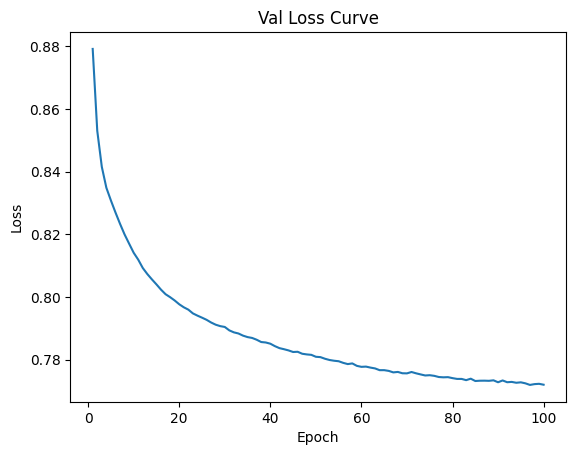

Finished Training Student for lambda value of 0
Student model CustomXSCNN saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/CustomXSCNN_lambda0_20231207_012454.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/CustomXSCNN_weights_lambda0_20231207_012454.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 1/100*****
*****Train Loss:  1.266358 Val Loss:  0.831169*****
*****Validation Accuracy: 20.98%*****
*****Total Avg Disparity: 0.02337193768739479*****

Class Team_Sports: Recall Difference = 0.03277695902023281
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.013966916354556769
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 2/100*****
*****Train Loss:  1.241581 Val Loss:  0.822482*****
*****Validation Accuracy: 21.53%*****
*****Total Avg Disparity: 0.012697284572524087*****

Class Team_Sports: Recall Difference = 0.01751379511258877
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.007880774032459403
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 3/100*****
*****Train Loss:  1.227555 Val Loss:  0.808631*****
*****Validation Accuracy: 21.65%*****
*****Total Avg Disparity: 0.027309071624188677*****

Class Team_Sports: Recall Difference = 0.0021021123944658937
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.009469696969696968
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.049118289637952506
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.04854618749463935
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_valid

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 4/100*****
*****Train Loss:  1.211150 Val Loss:  0.796505*****
*****Validation Accuracy: 22.74%*****
*****Total Avg Disparity: 0.04012179446648708*****

Class Team_Sports: Recall Difference = -0.003233140258879774
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = -0.00094696969696971
Class Waiter_Or_Waitress: Recall Difference = -0.07025582283314241
Class Individual_Sports: Recall Difference = 0.10611735330836458
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = -0.004790291675537579
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.06209795008148211
Class Family: Recall Difference = 0.033411033411033415
Data has been appended to Smal

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 5/100*****
*****Train Loss:  1.197625 Val Loss:  0.787862*****
*****Validation Accuracy: 23.43%*****
*****Total Avg Disparity: 0.045113701326213604*****

Class Team_Sports: Recall Difference = -0.03625001428065466
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = -0.054924242424242375
Class Waiter_Or_Waitress: Recall Difference = -0.00840015273004964
Class Individual_Sports: Recall Difference = 0.11122815230961297
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.03592814371257485
Class Water_Activities: Recall Difference = -0.045135192676176286
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.023930011150184435
Class Family: Recall Difference = 0.0
Data has been appended to Sm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 6/100*****
*****Train Loss:  1.187718 Val Loss:  0.782979*****
*****Validation Accuracy: 23.81%*****
*****Total Avg Disparity: 0.0629486870499536*****

Class Team_Sports: Recall Difference = -0.026276404930824504
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = -0.04261363636363641
Class Waiter_Or_Waitress: Recall Difference = -0.10538373424971367
Class Individual_Sports: Recall Difference = 0.12347846441947569
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.1187624750499002
Class Water_Activities: Recall Difference = -0.036938471364700874
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01672527661034398
Class Family: Recall Difference = 0.033411033411033415
Data has been ap

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 7/100*****
*****Train Loss:  1.179815 Val Loss:  0.780807*****
*****Validation Accuracy: 24.33%*****
*****Total Avg Disparity: 0.049397327074968245*****

Class Team_Sports: Recall Difference = 0.011481646502382148
Class Celebration: Recall Difference = -0.005
Class Parade: Recall Difference = -0.024621212121212127
Class Waiter_Or_Waitress: Recall Difference = -0.04963726613211149
Class Individual_Sports: Recall Difference = 0.14165886392009985
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780437
Class Water_Activities: Recall Difference = 0.0040451351926762
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.07204734539840471
Class Family: Recall Difference = 0.023310023310023312
Data has been

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 8/100*****
*****Train Loss:  1.173641 Val Loss:  0.777599*****
*****Validation Accuracy: 24.47%*****
*****Total Avg Disparity: 0.05244189106428081*****

Class Team_Sports: Recall Difference = -0.045972284105060046
Class Celebration: Recall Difference = 0.004801980198019799
Class Parade: Recall Difference = -0.08901515151515155
Class Waiter_Or_Waitress: Recall Difference = -0.06185567010309278
Class Individual_Sports: Recall Difference = 0.07038077403245946
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = -0.004151586118799219
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.11527575263744747
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 9/100*****
*****Train Loss:  1.168235 Val Loss:  0.773606*****
*****Validation Accuracy: 25.02%*****
*****Total Avg Disparity: 0.04893704161759902*****

Class Team_Sports: Recall Difference = -0.034056505695125194
Class Celebration: Recall Difference = -0.005
Class Parade: Recall Difference = -0.042613636363636354
Class Waiter_Or_Waitress: Recall Difference = -0.05994654448262696
Class Individual_Sports: Recall Difference = 0.14634051186017477
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = -0.008303172237598438
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.016296423363924867
Class Family: Recall Difference = 0.0283605283

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 10/100*****
*****Train Loss:  1.165190 Val Loss:  0.771594*****
*****Validation Accuracy: 25.17%*****
*****Total Avg Disparity: 0.059842149966665224*****

Class Team_Sports: Recall Difference = -0.04163096502953245
Class Celebration: Recall Difference = -0.00019801980198020167
Class Parade: Recall Difference = -0.1003787878787879
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.10490792759051182
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = 0.010857994464551823
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.1233381936701261
Class Family: Recall Difference =

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 11/100*****
*****Train Loss:  1.161766 Val Loss:  0.768830*****
*****Validation Accuracy: 25.05%*****
*****Total Avg Disparity: 0.05222512230503044*****

Class Team_Sports: Recall Difference = -0.02412859444082671
Class Celebration: Recall Difference = 0.014504950495049518
Class Parade: Recall Difference = -0.05965909090909094
Class Waiter_Or_Waitress: Recall Difference = -0.053837342497136315
Class Individual_Sports: Recall Difference = 0.14614544319600498
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0528942115768463
Class Water_Activities: Recall Difference = -0.005535448158398987
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.06715841838922726
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 12/100*****
*****Train Loss:  1.158799 Val Loss:  0.766163*****
*****Validation Accuracy: 25.40%*****
*****Total Avg Disparity: 0.053989532413094524*****

Class Team_Sports: Recall Difference = 0.004604083124835845
Class Celebration: Recall Difference = 0.004306930693069311
Class Parade: Recall Difference = -0.08428030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.12600229095074456
Class Individual_Sports: Recall Difference = 0.09835362047440699
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = 0.029274004683840726
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.04151299425336652
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 13/100*****
*****Train Loss:  1.156680 Val Loss:  0.764212*****
*****Validation Accuracy: 25.86%*****
*****Total Avg Disparity: 0.06168254768997969*****

Class Team_Sports: Recall Difference = -0.03804366453028063
Class Celebration: Recall Difference = -0.0006930693069306937
Class Parade: Recall Difference = -0.09564393939393934
Class Waiter_Or_Waitress: Recall Difference = -0.11378388697976327
Class Individual_Sports: Recall Difference = 0.1618679775280899
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = -0.042957746478873245
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570859
Class Water_Activities: Recall Difference = 0.029274004683840754
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.02307230465734625
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 14/100*****
*****Train Loss:  1.153976 Val Loss:  0.764417*****
*****Validation Accuracy: 26.00%*****
*****Total Avg Disparity: 0.057460498338972994*****

Class Team_Sports: Recall Difference = -0.047069038397824836
Class Celebration: Recall Difference = 0.009306930693069294
Class Parade: Recall Difference = -0.06439393939393939
Class Waiter_Or_Waitress: Recall Difference = -0.17334860633829705
Class Individual_Sports: Recall Difference = 0.09121410736579272
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = -0.028873239436619725
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.004258037044922308
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0391971867227035
Class Family: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 15/100*****
*****Train Loss:  1.151671 Val Loss:  0.763850*****
*****Validation Accuracy: 26.35%*****
*****Total Avg Disparity: 0.04688897851952904*****

Class Team_Sports: Recall Difference = 0.00944808125121388
Class Celebration: Recall Difference = -0.056584158415841634
Class Parade: Recall Difference = -0.049242424242424254
Class Waiter_Or_Waitress: Recall Difference = -0.10729285987017942
Class Individual_Sports: Recall Difference = 0.07853464419475659
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = -0.02394366197183101
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.00904832872045988
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.015438716871086722
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 16/100*****
*****Train Loss:  1.149390 Val Loss:  0.758475*****
*****Validation Accuracy: 26.49%*****
*****Total Avg Disparity: 0.05342259328977672*****

Class Team_Sports: Recall Difference = 0.010590533639510569
Class Celebration: Recall Difference = -0.0257920792079208
Class Parade: Recall Difference = -0.10606060606060602
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.0981585518102372
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = -0.0025821596244131415
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = 0.0326804343197786
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.03791062698344627
Class Family: Recall Difference = 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 17/100*****
*****Train Loss:  1.146644 Val Loss:  0.758409*****
*****Validation Accuracy: 25.86%*****
*****Total Avg Disparity: 0.04253941633622798*****

Class Team_Sports: Recall Difference = -0.011013241023180353
Class Celebration: Recall Difference = -9.900990099010083e-05
Class Parade: Recall Difference = -0.08428030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.05192821687667051
Class Individual_Sports: Recall Difference = 0.1308130461922597
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.004460093896713615
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.1187624750499002
Class Water_Activities: Recall Difference = -0.011070896316797946
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.002573119478514463
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 18/100*****
*****Train Loss:  1.144702 Val Loss:  0.755781*****
*****Validation Accuracy: 26.58%*****
*****Total Avg Disparity: 0.05129528290320566*****

Class Team_Sports: Recall Difference = 0.025956518262101436
Class Celebration: Recall Difference = -0.04178217821782185
Class Parade: Recall Difference = -0.05776515151515155
Class Waiter_Or_Waitress: Recall Difference = -0.06414662084765177
Class Individual_Sports: Recall Difference = 0.1157147315855181
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = -0.012910798122065734
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = -0.060996380668511846
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.030705892443605776
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 19/100*****
*****Train Loss:  1.142532 Val Loss:  0.754168*****
*****Validation Accuracy: 26.75%*****
*****Total Avg Disparity: 0.05230445830809704*****

Class Team_Sports: Recall Difference = 0.002410574539306154
Class Celebration: Recall Difference = -0.020792079207920797
Class Parade: Recall Difference = -0.08617424242424243
Class Waiter_Or_Waitress: Recall Difference = -0.06414662084765177
Class Individual_Sports: Recall Difference = 0.11470037453183518
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = -0.010328638497652587
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.059612518628912065
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.021785744918089017
Class Family: R

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 20/100*****
*****Train Loss:  1.140380 Val Loss:  0.754325*****
*****Validation Accuracy: 26.58%*****
*****Total Avg Disparity: 0.04745226900141468*****

Class Team_Sports: Recall Difference = 0.007094629331322544
Class Celebration: Recall Difference = -0.010594059405940603
Class Parade: Recall Difference = -0.03882575757575757
Class Waiter_Or_Waitress: Recall Difference = -0.1240931653302787
Class Individual_Sports: Recall Difference = 0.10650749063670412
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = 0.013380281690140855
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = -0.04662550564189907
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01226520284758556
Class Family: Recal

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 21/100*****
*****Train Loss:  1.138562 Val Loss:  0.753409*****
*****Validation Accuracy: 26.98%*****
*****Total Avg Disparity: 0.06330460907988734*****

Class Team_Sports: Recall Difference = 0.04535535981537975
Class Celebration: Recall Difference = -0.03079207920792082
Class Parade: Recall Difference = -0.0454545454545455
Class Waiter_Or_Waitress: Recall Difference = -0.13631156930126
Class Individual_Sports: Recall Difference = 0.11817259675405739
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = 0.020422535211267606
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780437
Class Water_Activities: Recall Difference = -0.04662550564189913
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.03302169997426882
Class Family: Recall Dif

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 22/100*****
*****Train Loss:  1.136837 Val Loss:  0.750764*****
*****Validation Accuracy: 26.75%*****
*****Total Avg Disparity: 0.056859012261427595*****

Class Team_Sports: Recall Difference = 0.027944385417737694
Class Celebration: Recall Difference = -0.03529702970297029
Class Parade: Recall Difference = -0.05776515151515149
Class Waiter_Or_Waitress: Recall Difference = -0.03932798778159603
Class Individual_Sports: Recall Difference = 0.09507646691635463
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = 0.003755868544600943
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = -0.13891845859058968
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.036709837893472846
Class Family: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 23/100*****
*****Train Loss:  1.134369 Val Loss:  0.749144*****
*****Validation Accuracy: 26.98%*****
*****Total Avg Disparity: 0.05653975036627123*****

Class Team_Sports: Recall Difference = 0.011435948406850027
Class Celebration: Recall Difference = -0.015297029702970297
Class Parade: Recall Difference = -0.10321969696969696
Class Waiter_Or_Waitress: Recall Difference = -0.06414662084765177
Class Individual_Sports: Recall Difference = 0.1018258426966292
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = 0.01854460093896714
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.07085828343313373
Class Water_Activities: Recall Difference = -0.11911858633170114
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.017840295051033545
Class Family: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 24/100*****
*****Train Loss:  1.134148 Val Loss:  0.747892*****
*****Validation Accuracy: 27.56%*****
*****Total Avg Disparity: 0.06303407193027422*****

Class Team_Sports: Recall Difference = 0.003952885263506678
Class Celebration: Recall Difference = -0.0401980198019802
Class Parade: Recall Difference = -0.09659090909090912
Class Waiter_Or_Waitress: Recall Difference = -0.053837342497136315
Class Individual_Sports: Recall Difference = 0.0969101123595506
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = 0.02230046948356805
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.124750499001996
Class Water_Activities: Recall Difference = -0.1334894613583138
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.029076250107213306
Class Family: Recall D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 25/100*****
*****Train Loss:  1.130504 Val Loss:  0.747714*****
*****Validation Accuracy: 27.27%*****
*****Total Avg Disparity: 0.06300417219406221*****

Class Team_Sports: Recall Difference = -0.014052164376049503
Class Celebration: Recall Difference = -0.0300990099009901
Class Parade: Recall Difference = -0.065340909090909
Class Waiter_Or_Waitress: Recall Difference = -0.08476517754868271
Class Individual_Sports: Recall Difference = 0.09835362047440699
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = -0.026995305164319264
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = -0.16968277624015324
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0030019727249335493
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 26/100*****
*****Train Loss:  1.129495 Val Loss:  0.743728*****
*****Validation Accuracy: 28.05%*****
*****Total Avg Disparity: 0.06858703171510089*****

Class Team_Sports: Recall Difference = 0.00500394146073968
Class Celebration: Recall Difference = -0.04628712871287127
Class Parade: Recall Difference = -0.08333333333333331
Class Waiter_Or_Waitress: Recall Difference = -0.13020236731576942
Class Individual_Sports: Recall Difference = 0.09140917602996257
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333334
Class Law_Enforcement: Recall Difference = -0.012910798122065734
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.16489248456461578
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.02230036881379191
Class Family: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 27/100*****
*****Train Loss:  1.127747 Val Loss:  0.743318*****
*****Validation Accuracy: 28.14%*****
*****Total Avg Disparity: 0.0559897756343686*****

Class Team_Sports: Recall Difference = -0.0008339902434566504
Class Celebration: Recall Difference = -0.03569306930693071
Class Parade: Recall Difference = -0.07102272727272729
Class Waiter_Or_Waitress: Recall Difference = -0.08476517754868271
Class Individual_Sports: Recall Difference = 0.08711766541822719
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06250000000000001
Class Law_Enforcement: Recall Difference = -0.012910798122065734
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780437
Class Water_Activities: Recall Difference = -0.15190547157760279
Class Picnic: Recall Difference = -0.039215686274509796
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.00420276181490694

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 28/100*****
*****Train Loss:  1.125930 Val Loss:  0.743946*****
*****Validation Accuracy: 27.82%*****
*****Total Avg Disparity: 0.05530228358840977*****

Class Team_Sports: Recall Difference = 0.012829740320572158
Class Celebration: Recall Difference = -0.025990099009900985
Class Parade: Recall Difference = -0.05208333333333326
Class Waiter_Or_Waitress: Recall Difference = -0.07445589919816725
Class Individual_Sports: Recall Difference = 0.08731273408239704
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = -0.003286384976525822
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.124750499001996
Class Water_Activities: Recall Difference = -0.14849904194166497
Class Picnic: Recall Difference = -0.019607843137254898
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.005060468307745092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 29/100*****
*****Train Loss:  1.123572 Val Loss:  0.738616*****
*****Validation Accuracy: 28.98%*****
*****Total Avg Disparity: 0.06624176766383742*****

Class Team_Sports: Recall Difference = 0.0028104328752098784
Class Celebration: Recall Difference = -0.025990099009901013
Class Parade: Recall Difference = -0.07765151515151508
Class Waiter_Or_Waitress: Recall Difference = -0.14662084765177552
Class Individual_Sports: Recall Difference = 0.0566869538077403
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333334
Class Law_Enforcement: Recall Difference = 0.057511737089201875
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780439
Class Water_Activities: Recall Difference = -0.15126676602086442
Class Picnic: Recall Difference = -0.039215686274509796
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.015009863624667635

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 30/100*****
*****Train Loss:  1.122480 Val Loss:  0.738623*****
*****Validation Accuracy: 28.95%*****
*****Total Avg Disparity: 0.07273388490510348*****

Class Team_Sports: Recall Difference = 0.03329106259496639
Class Celebration: Recall Difference = -0.06688118811881183
Class Parade: Recall Difference = -0.09280303030303028
Class Waiter_Or_Waitress: Recall Difference = -0.09507445589919818
Class Individual_Sports: Recall Difference = 0.0705758426966292
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.0568075117370892
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0588822355289421
Class Water_Activities: Recall Difference = -0.14647647434532673
Class Picnic: Recall Difference = -0.0196078431372549
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.05549361008662837
Class Fa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 31/100*****
*****Train Loss:  1.119869 Val Loss:  0.736779*****
*****Validation Accuracy: 29.18%*****
*****Total Avg Disparity: 0.0699686321522186*****

Class Team_Sports: Recall Difference = 0.05677988369834697
Class Celebration: Recall Difference = -0.03638613861386139
Class Parade: Recall Difference = -0.07291666666666669
Class Waiter_Or_Waitress: Recall Difference = -0.08476517754868271
Class Individual_Sports: Recall Difference = 0.03870162297128593
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = 0.09906103286384974
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780437
Class Water_Activities: Recall Difference = -0.14722163082818823
Class Picnic: Recall Difference = -0.039215686274509796
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.007376275838408081
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 32/100*****
*****Train Loss:  1.117466 Val Loss:  0.735783*****
*****Validation Accuracy: 29.06%*****
*****Total Avg Disparity: 0.07182121939957219*****

Class Team_Sports: Recall Difference = 0.02026710536838372
Class Celebration: Recall Difference = -0.05059405940594061
Class Parade: Recall Difference = -0.07954545454545464
Class Waiter_Or_Waitress: Recall Difference = -0.12409316533027867
Class Individual_Sports: Recall Difference = 0.081811797752809
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.08309859154929575
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = -0.10953800298062599
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0006861651942704772
Cl

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 33/100*****
*****Train Loss:  1.116737 Val Loss:  0.735761*****
*****Validation Accuracy: 29.06%*****
*****Total Avg Disparity: 0.06142555236430686*****

Class Team_Sports: Recall Difference = 0.003655847642549448
Class Celebration: Recall Difference = -0.035297029702970294
Class Parade: Recall Difference = -0.06534090909090912
Class Waiter_Or_Waitress: Recall Difference = -0.11989308896525391
Class Individual_Sports: Recall Difference = 0.0765059300873907
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.02230046948356805
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.1027251437087503
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.010549789861909298
Clas

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 34/100*****
*****Train Loss:  1.114928 Val Loss:  0.734915*****
*****Validation Accuracy: 29.47%*****
*****Total Avg Disparity: 0.06295435597533025*****

Class Team_Sports: Recall Difference = 0.04221361574756366
Class Celebration: Recall Difference = -0.0463861386138614
Class Parade: Recall Difference = -0.062499999999999944
Class Waiter_Or_Waitress: Recall Difference = -0.053837342497136315
Class Individual_Sports: Recall Difference = 0.039091760299625467
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = 0.07723004694835678
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.07085828343313372
Class Water_Activities: Recall Difference = -0.1028315946348734
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0370529204906081
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 35/100*****
*****Train Loss:  1.113193 Val Loss:  0.732775*****
*****Validation Accuracy: 29.44%*****
*****Total Avg Disparity: 0.07446216483788999*****

Class Team_Sports: Recall Difference = 0.047400349590430935
Class Celebration: Recall Difference = -0.020693069306930698
Class Parade: Recall Difference = -0.06534090909090906
Class Waiter_Or_Waitress: Recall Difference = -0.07865597556319207
Class Individual_Sports: Recall Difference = 0.06956148564294629
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.1157276995305164
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.1307385229540918
Class Water_Activities: Recall Difference = -0.08973813072173731
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.034308259713526024
Clas

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 36/100*****
*****Train Loss:  1.111019 Val Loss:  0.731588*****
*****Validation Accuracy: 29.67%*****
*****Total Avg Disparity: 0.056163453426420075*****

Class Team_Sports: Recall Difference = 0.048200066262238495
Class Celebration: Recall Difference = -0.021188118811881165
Class Parade: Recall Difference = -0.08522727272727282
Class Waiter_Or_Waitress: Recall Difference = -0.07865597556319204
Class Individual_Sports: Recall Difference = 0.02235486891385774
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.004694835680751075
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = 0.11876247504990019
Class Water_Activities: Recall Difference = -0.13423461784117519
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0109

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 37/100*****
*****Train Loss:  1.109152 Val Loss:  0.728713*****
*****Validation Accuracy: 29.99%*****
*****Total Avg Disparity: 0.07032176106059933*****

Class Team_Sports: Recall Difference = 0.04027144668745919
Class Celebration: Recall Difference = -0.01128712871287127
Class Parade: Recall Difference = -0.06628787878787884
Class Waiter_Or_Waitress: Recall Difference = -0.09927453226422298
Class Individual_Sports: Recall Difference = 0.08263108614232212
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = 0.04201877934272297
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.13008303172237606
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.02581696543442838
Cl

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 38/100*****
*****Train Loss:  1.107966 Val Loss:  0.730041*****
*****Validation Accuracy: 30.13%*****
*****Total Avg Disparity: 0.07175084802538523*****

Class Team_Sports: Recall Difference = 0.009596600061692495
Class Celebration: Recall Difference = -0.0764851485148515
Class Parade: Recall Difference = -0.06628787878787878
Class Waiter_Or_Waitress: Recall Difference = -0.12600229095074456
Class Individual_Sports: Recall Difference = 0.02235486891385774
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.12499999999999999
Class Law_Enforcement: Recall Difference = 0.0753521126760563
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0528942115768463
Class Water_Activities: Recall Difference = -0.11581860762188623
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.11802041341452957
Class

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 39/100*****
*****Train Loss:  1.106207 Val Loss:  0.726939*****
*****Validation Accuracy: 29.96%*****
*****Total Avg Disparity: 0.07353339332641717*****

Class Team_Sports: Recall Difference = 0.03049205424363932
Class Celebration: Recall Difference = -0.040396039603960404
Class Parade: Recall Difference = -0.026515151515151547
Class Waiter_Or_Waitress: Recall Difference = -0.10538373424971365
Class Individual_Sports: Recall Difference = 0.07833957553058679
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.09718309859154925
Class Business: Recall Difference = 0.009900990099009903
Class Dresses: Recall Difference = 0.11277445109780437
Class Water_Activities: Recall Difference = -0.14445390674898878
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 40/100*****
*****Train Loss:  1.105345 Val Loss:  0.729555*****
*****Validation Accuracy: 29.47%*****
*****Total Avg Disparity: 0.06255218990359672*****

Class Team_Sports: Recall Difference = 0.032936902354594455
Class Celebration: Recall Difference = -0.06658415841584162
Class Parade: Recall Difference = -0.055871212121212155
Class Waiter_Or_Waitress: Recall Difference = -0.05994654448262694
Class Individual_Sports: Recall Difference = 0.008856117353308324
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.06572769953051638
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.124750499001996
Class Water_Activities: Recall Difference = -0.10219288907813495
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0001715412985676401
Cl

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 41/100*****
*****Train Loss:  1.103904 Val Loss:  0.725558*****
*****Validation Accuracy: 29.41%*****
*****Total Avg Disparity: 0.07145713248052582*****

Class Team_Sports: Recall Difference = 0.05887057156892983
Class Celebration: Recall Difference = -0.015693069306930707
Class Parade: Recall Difference = -0.08901515151515144
Class Waiter_Or_Waitress: Recall Difference = -0.07445589919816725
Class Individual_Sports: Recall Difference = 0.02173064918851436
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.06314553990610325
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732536
Class Water_Activities: Recall Difference = -0.12401532893336159
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.026331589330131244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 42/100*****
*****Train Loss:  1.102920 Val Loss:  0.722670*****
*****Validation Accuracy: 30.33%*****
*****Total Avg Disparity: 0.07302604385345292*****

Class Team_Sports: Recall Difference = 0.0266991123144944
Class Celebration: Recall Difference = -0.05089108910891088
Class Parade: Recall Difference = -0.11079545454545459
Class Waiter_Or_Waitress: Recall Difference = -0.07254677357770137
Class Individual_Sports: Recall Difference = 0.07279962546816476
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.007276995305164291
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.12667660208643822
Class Picnic: Recall Difference = -0.07843137254901962
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.002916202075649743
Cla

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 43/100*****
*****Train Loss:  1.101144 Val Loss:  0.722748*****
*****Validation Accuracy: 30.42%*****
*****Total Avg Disparity: 0.0762281951543824*****

Class Team_Sports: Recall Difference = 0.054335035587391944
Class Celebration: Recall Difference = -0.13638613861386142
Class Parade: Recall Difference = -0.04829545454545464
Class Waiter_Or_Waitress: Recall Difference = -0.13631156930126004
Class Individual_Sports: Recall Difference = 0.0482990012484395
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.02464788732394363
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = -0.11986374281456252
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.05232009

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 44/100*****
*****Train Loss:  1.099905 Val Loss:  0.722167*****
*****Validation Accuracy: 30.01%*****
*****Total Avg Disparity: 0.06731784226771828*****

Class Team_Sports: Recall Difference = 0.010339194114085348
Class Celebration: Recall Difference = -0.025990099009901013
Class Parade: Recall Difference = -0.0757575757575758
Class Waiter_Or_Waitress: Recall Difference = -0.099274532264223
Class Individual_Sports: Recall Difference = 0.0820068664169788
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.09014084507042255
Class Business: Recall Difference = 0.009900990099009901
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.0959122844368745
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0249592

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 45/100*****
*****Train Loss:  1.098504 Val Loss:  0.721103*****
*****Validation Accuracy: 29.75%*****
*****Total Avg Disparity: 0.05955324454877403*****

Class Team_Sports: Recall Difference = 0.024654122539443102
Class Celebration: Recall Difference = -0.0011881188118811753
Class Parade: Recall Difference = -0.07481060606060608
Class Waiter_Or_Waitress: Recall Difference = -0.053837342497136315
Class Individual_Sports: Recall Difference = 0.05789637952559307
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.08685446009389669
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.004990019960079833
Class Water_Activities: Recall Difference = -0.04673195656802215
Class Picnic: Recall Difference = -0.07843137254901959
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01989879063384508

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 46/100*****
*****Train Loss:  1.096318 Val Loss:  0.722489*****
*****Validation Accuracy: 29.52%*****
*****Total Avg Disparity: 0.0610767357039007*****

Class Team_Sports: Recall Difference = 0.006352035278929802
Class Celebration: Recall Difference = -0.03589108910891087
Class Parade: Recall Difference = 0.0028409090909090606
Class Waiter_Or_Waitress: Recall Difference = -0.1176021382206949
Class Individual_Sports: Recall Difference = 0.0454509987515605
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.0708920187793427
Class Business: Recall Difference = 0.009900990099009901
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.1246540344901001
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0106355

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 47/100*****
*****Train Loss:  1.095724 Val Loss:  0.718590*****
*****Validation Accuracy: 29.87%*****
*****Total Avg Disparity: 0.0659826670589866*****

Class Team_Sports: Recall Difference = 0.028698403994013577
Class Celebration: Recall Difference = -0.09217821782178223
Class Parade: Recall Difference = -0.06344696969696967
Class Waiter_Or_Waitress: Recall Difference = -0.11569301260022909
Class Individual_Sports: Recall Difference = 0.016424781523096177
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.0561032863849765
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.07085828343313372
Class Water_Activities: Recall Difference = -0.12060889929742385
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0021442662320953626


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 48/100*****
*****Train Loss:  1.093952 Val Loss:  0.718372*****
*****Validation Accuracy: 29.81%*****
*****Total Avg Disparity: 0.0767811757574804*****

Class Team_Sports: Recall Difference = 0.028195724943163025
Class Celebration: Recall Difference = -0.030495049504950494
Class Parade: Recall Difference = -0.11458333333333331
Class Waiter_Or_Waitress: Recall Difference = -0.09927453226422295
Class Individual_Sports: Recall Difference = 0.011313982521847732
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.05281690140845069
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.1187624750499002
Class Water_Activities: Recall Difference = -0.13221205024483712
Class Picnic: Recall Difference = -0.05882352941176471
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.011493267004031194
C

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 49/100*****
*****Train Loss:  1.092826 Val Loss:  0.715751*****
*****Validation Accuracy: 30.22%*****
*****Total Avg Disparity: 0.06498531076309712*****

Class Team_Sports: Recall Difference = 0.018770492739714983
Class Celebration: Recall Difference = -0.065990099009901
Class Parade: Recall Difference = -0.007575757575757569
Class Waiter_Or_Waitress: Recall Difference = -0.10958381061473843
Class Individual_Sports: Recall Difference = 0.032771535580524425
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.06830985915492951
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = -0.10623802427081125
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384614
Class Performance_And_Entertainment: Recall Difference = -0.04116991165623124

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 50/100*****
*****Train Loss:  1.091039 Val Loss:  0.716009*****
*****Validation Accuracy: 30.53%*****
*****Total Avg Disparity: 0.06460077960238539*****

Class Team_Sports: Recall Difference = -0.010910420308233637
Class Celebration: Recall Difference = -0.0464851485148515
Class Parade: Recall Difference = -0.08806818181818188
Class Waiter_Or_Waitress: Recall Difference = -0.09507445589919816
Class Individual_Sports: Recall Difference = 0.04931335830212241
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.10352112676056335
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = -0.05290611028315956
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.01

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 51/100*****
*****Train Loss:  1.091097 Val Loss:  0.716257*****
*****Validation Accuracy: 30.51%*****
*****Total Avg Disparity: 0.06283756194459654*****

Class Team_Sports: Recall Difference = -0.0012338485793602638
Class Celebration: Recall Difference = -0.030990099009900948
Class Parade: Recall Difference = -0.047348484848484806
Class Waiter_Or_Waitress: Recall Difference = -0.11569301260022913
Class Individual_Sports: Recall Difference = 0.0582865168539326
Class Surgeons: Recall Difference = -0.005912786400591282
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.1161971830985915
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = -0.03108367042793264
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 52/100*****
*****Train Loss:  1.089034 Val Loss:  0.712951*****
*****Validation Accuracy: 30.30%*****
*****Total Avg Disparity: 0.07439378660181588*****

Class Team_Sports: Recall Difference = 0.03473055260422031
Class Celebration: Recall Difference = -0.016089108910891076
Class Parade: Recall Difference = -0.08617424242424249
Class Waiter_Or_Waitress: Recall Difference = -0.04772814051164567
Class Individual_Sports: Recall Difference = 0.07279962546816476
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.07652582159624416
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.05389221556886228
Class Water_Activities: Recall Difference = -0.08505428997232284
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.026760442576550303
C

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 53/100*****
*****Train Loss:  1.089198 Val Loss:  0.715086*****
*****Validation Accuracy: 30.62%*****
*****Total Avg Disparity: 0.05103680048949829*****

Class Team_Sports: Recall Difference = 0.02635637659800527
Class Celebration: Recall Difference = -0.055891089108910885
Class Parade: Recall Difference = -0.008522727272727348
Class Waiter_Or_Waitress: Recall Difference = -0.06414662084765177
Class Individual_Sports: Recall Difference = -0.007256554307116081
Class Surgeons: Recall Difference = -0.030303030303030297
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.05211267605633796
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = 0.02894211576846306
Class Water_Activities: Recall Difference = -0.09325101128379815
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference =

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.98it/s]


*****Epoch 54/100*****
*****Train Loss:  1.086720 Val Loss:  0.716321*****
*****Validation Accuracy: 30.42%*****
*****Total Avg Disparity: 0.061991093327265975*****

Class Team_Sports: Recall Difference = 0.018964709645725608
Class Celebration: Recall Difference = -0.08089108910891087
Class Parade: Recall Difference = -0.0871212121212121
Class Waiter_Or_Waitress: Recall Difference = -0.09316533027873236
Class Individual_Sports: Recall Difference = 0.08852215980024969
Class Surgeons: Recall Difference = -0.030303030303030304
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.017605633802816878
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.05389221556886227
Class Water_Activities: Recall Difference = -0.04673195656802215
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 55/100*****
*****Train Loss:  1.087144 Val Loss:  0.713513*****
*****Validation Accuracy: 31.08%*****
*****Total Avg Disparity: 0.05921770912388131*****

Class Team_Sports: Recall Difference = 0.03527892975060276
Class Celebration: Recall Difference = -0.07618811881188117
Class Parade: Recall Difference = -0.1136363636363637
Class Waiter_Or_Waitress: Recall Difference = -0.07254677357770137
Class Individual_Sports: Recall Difference = 0.054424157303370746
Class Surgeons: Recall Difference = -0.030303030303030297
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.06995305164319243
Class Business: Recall Difference = -0.022357074417119132
Class Dresses: Recall Difference = 0.07085828343313372
Class Water_Activities: Recall Difference = -0.026932084309133464
Class Picnic: Recall Difference = -0.05882352941176471
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 56/100*****
*****Train Loss:  1.084205 Val Loss:  0.709781*****
*****Validation Accuracy: 31.02%*****
*****Total Avg Disparity: 0.06595622059442965*****

Class Team_Sports: Recall Difference = 0.047651689115856155
Class Celebration: Recall Difference = -0.09638613861386142
Class Parade: Recall Difference = -0.031249999999999944
Class Waiter_Or_Waitress: Recall Difference = -0.08896525391370752
Class Individual_Sports: Recall Difference = 0.06320224719101125
Class Surgeons: Recall Difference = -0.005912786400591279
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.038028169014084456
Class Business: Recall Difference = -0.011604386245076124
Class Dresses: Recall Difference = 0.046906187624750476
Class Water_Activities: Recall Difference = -0.07888013625718554
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recal

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 57/100*****
*****Train Loss:  1.084326 Val Loss:  0.712365*****
*****Validation Accuracy: 30.10%*****
*****Total Avg Disparity: 0.07212638917285301*****

Class Team_Sports: Recall Difference = 0.02250631204944531
Class Celebration: Recall Difference = -0.05638613861386141
Class Parade: Recall Difference = -0.07291666666666663
Class Waiter_Or_Waitress: Recall Difference = -0.12600229095074456
Class Individual_Sports: Recall Difference = 0.09281367041198502
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.09131455399061028
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.04130295933574618
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.02187151556737285
C

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 58/100*****
*****Train Loss:  1.083187 Val Loss:  0.710205*****
*****Validation Accuracy: 30.97%*****
*****Total Avg Disparity: 0.06836376132727878*****

Class Team_Sports: Recall Difference = 0.03702688190469672
Class Celebration: Recall Difference = -0.07688118811881184
Class Parade: Recall Difference = -0.08522727272727279
Class Waiter_Or_Waitress: Recall Difference = -0.053837342497136315
Class Individual_Sports: Recall Difference = 0.005617977528089901
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.08356807511737097
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = -0.09580838323353294
Class Water_Activities: Recall Difference = -0.07749627421758576
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0334

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 59/100*****
*****Train Loss:  1.081034 Val Loss:  0.711595*****
*****Validation Accuracy: 31.00%*****
*****Total Avg Disparity: 0.0755072348878655*****

Class Team_Sports: Recall Difference = 0.06166957992025679
Class Celebration: Recall Difference = -0.03316831683168325
Class Parade: Recall Difference = -0.011363636363636354
Class Waiter_Or_Waitress: Recall Difference = -0.0725467735777014
Class Individual_Sports: Recall Difference = 0.08688358302122345
Class Surgeons: Recall Difference = -0.005912786400591282
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.12394366197183093
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.11377245508982037
Class Water_Activities: Recall Difference = -0.04747711305088348
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.026674671927266497

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 60/100*****
*****Train Loss:  1.081941 Val Loss:  0.708010*****
*****Validation Accuracy: 31.26%*****
*****Total Avg Disparity: 0.06368913209776669*****

Class Team_Sports: Recall Difference = 0.03059487495858626
Class Celebration: Recall Difference = -0.08678217821782175
Class Parade: Recall Difference = 0.03314393939393934
Class Waiter_Or_Waitress: Recall Difference = -0.14051164566628482
Class Individual_Sports: Recall Difference = 0.039715980024968844
Class Surgeons: Recall Difference = -0.005912786400591279
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.06103286384976514
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.09186714924419853
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 61/100*****
*****Train Loss:  1.080058 Val Loss:  0.708215*****
*****Validation Accuracy: 30.71%*****
*****Total Avg Disparity: 0.07425843969663949*****

Class Team_Sports: Recall Difference = 0.027647347796780575
Class Celebration: Recall Difference = -0.0505940594059406
Class Parade: Recall Difference = -0.0804924242424242
Class Waiter_Or_Waitress: Recall Difference = -0.1302023673157694
Class Individual_Sports: Recall Difference = 0.04279806491885141
Class Surgeons: Recall Difference = -0.005912786400591282
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.09577464788732393
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.05988023952095809
Class Water_Activities: Recall Difference = -0.14104747711305082
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Dif

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 62/100*****
*****Train Loss:  1.078007 Val Loss:  0.706184*****
*****Validation Accuracy: 31.80%*****
*****Total Avg Disparity: 0.06214133451846944*****

Class Team_Sports: Recall Difference = -0.0013823673898389899
Class Celebration: Recall Difference = -0.011485148514851495
Class Parade: Recall Difference = -0.03693181818181818
Class Waiter_Or_Waitress: Recall Difference = -0.08896525391370755
Class Individual_Sports: Recall Difference = 0.053799937578027424
Class Surgeons: Recall Difference = -0.005912786400591282
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.05985915492957744
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.004990019960079833
Class Water_Activities: Recall Difference = -0.05428997232275928
Class Picnic: Recall Difference = -0.17647058823529413
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 63/100*****
*****Train Loss:  1.078460 Val Loss:  0.708228*****
*****Validation Accuracy: 31.34%*****
*****Total Avg Disparity: 0.07897262681944188*****

Class Team_Sports: Recall Difference = 0.0053009790816969105
Class Celebration: Recall Difference = -0.1368811881188119
Class Parade: Recall Difference = -0.05208333333333337
Class Waiter_Or_Waitress: Recall Difference = -0.11378388697976324
Class Individual_Sports: Recall Difference = 0.07260455680399508
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.08356807511737091
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.06586826347305388
Class Water_Activities: Recall Difference = -0.08026399829678516
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.008920147525516772
C

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 64/100*****
*****Train Loss:  1.076988 Val Loss:  0.705210*****
*****Validation Accuracy: 31.17%*****
*****Total Avg Disparity: 0.0713598060291051*****

Class Team_Sports: Recall Difference = 0.06565673875541234
Class Celebration: Recall Difference = -0.051089108910891065
Class Parade: Recall Difference = -0.041666666666666685
Class Waiter_Or_Waitress: Recall Difference = -0.1302023673157694
Class Individual_Sports: Recall Difference = 0.039715980024968844
Class Surgeons: Recall Difference = -0.005912786400591279
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.068075117370892
Class Business: Recall Difference = -0.03310976258916214
Class Dresses: Recall Difference = -0.05389221556886228
Class Water_Activities: Recall Difference = -0.07888013625718554
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Dif

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 65/100*****
*****Train Loss:  1.076797 Val Loss:  0.705414*****
*****Validation Accuracy: 31.46%*****
*****Total Avg Disparity: 0.06982553176175572*****

Class Team_Sports: Recall Difference = 0.05199300819138375
Class Celebration: Recall Difference = -0.04658415841584157
Class Parade: Recall Difference = -0.006628787878787901
Class Waiter_Or_Waitress: Recall Difference = -0.14051164566628482
Class Individual_Sports: Recall Difference = 0.027660736579275924
Class Surgeons: Recall Difference = -0.005912786400591282
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.05070422535211261
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.11377245508982037
Class Water_Activities: Recall Difference = -0.111667021503087
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 66/100*****
*****Train Loss:  1.075996 Val Loss:  0.707239*****
*****Validation Accuracy: 31.26%*****
*****Total Avg Disparity: 0.07284419700135636*****

Class Team_Sports: Recall Difference = 0.03692406118975
Class Celebration: Recall Difference = -0.08589108910891088
Class Parade: Recall Difference = -0.06628787878787884
Class Waiter_Or_Waitress: Recall Difference = -0.07445589919816725
Class Individual_Sports: Recall Difference = 0.06136860174781528
Class Surgeons: Recall Difference = -0.030303030303030297
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.03732394366197184
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = -0.125748502994012
Class Water_Activities: Recall Difference = -0.08782201405152223
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 67/100*****
*****Train Loss:  1.073970 Val Loss:  0.705085*****
*****Validation Accuracy: 31.20%*****
*****Total Avg Disparity: 0.05366017365774018*****

Class Team_Sports: Recall Difference = 0.021215340850670006
Class Celebration: Recall Difference = -0.06628712871287129
Class Parade: Recall Difference = 0.006628787878787901
Class Waiter_Or_Waitress: Recall Difference = -0.09927453226422298
Class Individual_Sports: Recall Difference = 0.027660736579275924
Class Surgeons: Recall Difference = -0.011825572801182557
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.07769953051643186
Class Business: Recall Difference = -0.01160438624507612
Class Dresses: Recall Difference = -0.0718562874251497
Class Water_Activities: Recall Difference = -0.024909516712795454
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 68/100*****
*****Train Loss:  1.074233 Val Loss:  0.702402*****
*****Validation Accuracy: 31.66%*****
*****Total Avg Disparity: 0.06905100707114041*****

Class Team_Sports: Recall Difference = 0.09069929510687647
Class Celebration: Recall Difference = -0.022475247524752467
Class Parade: Recall Difference = -0.045454545454545414
Class Waiter_Or_Waitress: Recall Difference = -0.11989308896525391
Class Individual_Sports: Recall Difference = 0.02582709113607995
Class Surgeons: Recall Difference = 0.012564671101256475
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.09178403755868536
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.10778443113772455
Class Water_Activities: Recall Difference = -0.03587396210347038
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 69/100*****
*****Train Loss:  1.072874 Val Loss:  0.705301*****
*****Validation Accuracy: 31.23%*****
*****Total Avg Disparity: 0.07141507581141687*****

Class Team_Sports: Recall Difference = 0.0763843666815186
Class Celebration: Recall Difference = -0.07757425742574259
Class Parade: Recall Difference = -0.04071969696969702
Class Waiter_Or_Waitress: Recall Difference = -0.10958381061473849
Class Individual_Sports: Recall Difference = 0.028909176029962458
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.03098591549295765
Class Business: Recall Difference = -0.011604386245076122
Class Dresses: Recall Difference = -0.0718562874251497
Class Water_Activities: Recall Difference = -0.158186076218863
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0198987

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 70/100*****
*****Train Loss:  1.070838 Val Loss:  0.704508*****
*****Validation Accuracy: 31.31%*****
*****Total Avg Disparity: 0.07646924147010202*****

Class Team_Sports: Recall Difference = 0.022609132764392026
Class Celebration: Recall Difference = -0.05628712871287128
Class Parade: Recall Difference = -0.06344696969696956
Class Waiter_Or_Waitress: Recall Difference = -0.12600229095074456
Class Individual_Sports: Recall Difference = 0.07096598002496879
Class Surgeons: Recall Difference = 0.048780487804878044
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.12769953051643185
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.09580838323353294
Class Water_Activities: Recall Difference = -0.11507345113902495
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 71/100*****
*****Train Loss:  1.070963 Val Loss:  0.700317*****
*****Validation Accuracy: 31.46%*****
*****Total Avg Disparity: 0.06769149093695229*****

Class Team_Sports: Recall Difference = 0.06765603043493162
Class Celebration: Recall Difference = -0.03188118811881191
Class Parade: Recall Difference = -0.002840909090909116
Class Waiter_Or_Waitress: Recall Difference = -0.13631156930126
Class Individual_Sports: Recall Difference = 0.03359082397003749
Class Surgeons: Recall Difference = -0.011825572801182557
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.05140845070422534
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.11976047904191618
Class Water_Activities: Recall Difference = -0.059080263998296634
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 72/100*****
*****Train Loss:  1.070739 Val Loss:  0.704128*****
*****Validation Accuracy: 30.56%*****
*****Total Avg Disparity: 0.06897931724118256*****

Class Team_Sports: Recall Difference = 0.008191383624087556
Class Celebration: Recall Difference = -0.025594059405940603
Class Parade: Recall Difference = -0.06628787878787873
Class Waiter_Or_Waitress: Recall Difference = -0.1321114929362352
Class Individual_Sports: Recall Difference = 0.03460518102372029
Class Surgeons: Recall Difference = 0.024390243902439025
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.0906103286384976
Class Business: Recall Difference = -0.000851698073033107
Class Dresses: Recall Difference = -0.05988023952095809
Class Water_Activities: Recall Difference = -0.11102831594634882
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 73/100*****
*****Train Loss:  1.069454 Val Loss:  0.702512*****
*****Validation Accuracy: 31.00%*****
*****Total Avg Disparity: 0.07285216459117604*****

Class Team_Sports: Recall Difference = 0.07219156641646973
Class Celebration: Recall Difference = -0.03217821782178218
Class Parade: Recall Difference = -0.038825757575757625
Class Waiter_Or_Waitress: Recall Difference = -0.08896525391370749
Class Individual_Sports: Recall Difference = 0.010065543071161087
Class Surgeons: Recall Difference = 0.012564671101256475
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.048826291079812234
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.05301256120928233
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.063984904365726

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 74/100*****
*****Train Loss:  1.068961 Val Loss:  0.703164*****
*****Validation Accuracy: 31.00%*****
*****Total Avg Disparity: 0.07832211133615907*****

Class Team_Sports: Recall Difference = 0.035427448561081265
Class Celebration: Recall Difference = -0.05549504950495048
Class Parade: Recall Difference = -0.0511363636363637
Class Waiter_Or_Waitress: Recall Difference = -0.11378388697976327
Class Individual_Sports: Recall Difference = 0.0893414481897628
Class Surgeons: Recall Difference = -0.017738359201773843
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.14694835680751173
Class Business: Recall Difference = -0.02150537634408602
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.08984458164786041
Class Picnic: Recall Difference = -0.09803921568627452
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 75/100*****
*****Train Loss:  1.069011 Val Loss:  0.700534*****
*****Validation Accuracy: 31.31%*****
*****Total Avg Disparity: 0.07357710182051345*****

Class Team_Sports: Recall Difference = 0.03922039049022641
Class Celebration: Recall Difference = -0.0405940594059406
Class Parade: Recall Difference = -0.049242424242424254
Class Waiter_Or_Waitress: Recall Difference = -0.12180221458571974
Class Individual_Sports: Recall Difference = 0.08239700374531839
Class Surgeons: Recall Difference = 0.006651884700665189
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.04178403755868548
Class Business: Recall Difference = -0.01160438624507612
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.10421545667447318
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 76/100*****
*****Train Loss:  1.068086 Val Loss:  0.701525*****
*****Validation Accuracy: 32.12%*****
*****Total Avg Disparity: 0.07553456629160113*****

Class Team_Sports: Recall Difference = 0.07802949812066573
Class Celebration: Recall Difference = -0.03257425742574255
Class Parade: Recall Difference = -0.03125
Class Waiter_Or_Waitress: Recall Difference = -0.09507445589919815
Class Individual_Sports: Recall Difference = 0.04463171036204738
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.13028169014084506
Class Business: Recall Difference = -0.03310976258916214
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.06929955290611028
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.051033536323869

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 77/100*****
*****Train Loss:  1.066763 Val Loss:  0.698840*****
*****Validation Accuracy: 31.37%*****
*****Total Avg Disparity: 0.06791871108384819*****

Class Team_Sports: Recall Difference = 0.06770172853046341
Class Celebration: Recall Difference = -0.07069306930693071
Class Parade: Recall Difference = -0.01799242424242431
Class Waiter_Or_Waitress: Recall Difference = -0.12600229095074456
Class Individual_Sports: Recall Difference = 0.021535580524344622
Class Surgeons: Recall Difference = 0.012564671101256489
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.07511737089201881
Class Business: Recall Difference = -0.01160438624507612
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.06387055567383437
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 78/100*****
*****Train Loss:  1.065585 Val Loss:  0.698529*****
*****Validation Accuracy: 31.92%*****
*****Total Avg Disparity: 0.06769321383282194*****

Class Team_Sports: Recall Difference = 0.06904982234865364
Class Celebration: Recall Difference = -0.0018811881188118273
Class Parade: Recall Difference = -0.03598484848484845
Class Waiter_Or_Waitress: Recall Difference = -0.15273004963726614
Class Individual_Sports: Recall Difference = 0.05891073657927587
Class Surgeons: Recall Difference = -0.04212860310421287
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.0654929577464789
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.05988023952095809
Class Water_Activities: Recall Difference = -0.0754737066212477
Class Picnic: Recall Difference = 0.026143790849673193
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340424
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 79/100*****
*****Train Loss:  1.065035 Val Loss:  0.699746*****
*****Validation Accuracy: 32.12%*****
*****Total Avg Disparity: 0.0700029053881749*****

Class Team_Sports: Recall Difference = 0.06695913447807056
Class Celebration: Recall Difference = -0.037178217821782183
Class Parade: Recall Difference = 0.027462121212121215
Class Waiter_Or_Waitress: Recall Difference = -0.0725467735777014
Class Individual_Sports: Recall Difference = 0.03542446941323352
Class Surgeons: Recall Difference = -0.011825572801182557
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.05140845070422534
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.1317365269461078
Class Water_Activities: Recall Difference = -0.07281243346817123
Class Picnic: Recall Difference = -0.06535947712418302
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 80/100*****
*****Train Loss:  1.064965 Val Loss:  0.696545*****
*****Validation Accuracy: 31.98%*****
*****Total Avg Disparity: 0.07333566524987223*****

Class Team_Sports: Recall Difference = 0.050941951994150636
Class Celebration: Recall Difference = -0.06188118811881188
Class Parade: Recall Difference = -0.0246212121212121
Class Waiter_Or_Waitress: Recall Difference = -0.11989308896525391
Class Individual_Sports: Recall Difference = 0.030118601747815277
Class Surgeons: Recall Difference = -0.011825572801182543
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.09507042253521125
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.059080263998296856
Class Picnic: Recall Difference = -0.1568627450980392
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 81/100*****
*****Train Loss:  1.064291 Val Loss:  0.696583*****
*****Validation Accuracy: 32.21%*****
*****Total Avg Disparity: 0.06007695805879676*****

Class Team_Sports: Recall Difference = 0.0754361311992322
Class Celebration: Recall Difference = -0.026782178217821778
Class Parade: Recall Difference = -0.025568181818181823
Class Waiter_Or_Waitress: Recall Difference = -0.0561282932416953
Class Individual_Sports: Recall Difference = 0.01357677902621729
Class Surgeons: Recall Difference = 0.006651884700665189
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.053286384976525714
Class Business: Recall Difference = 0.018950282124986693
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.08846071960826057
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = -0.022727272727272728
Class Cheering: Recall Difference = 0.0
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 82/100*****
*****Train Loss:  1.063746 Val Loss:  0.696872*****
*****Validation Accuracy: 32.01%*****
*****Total Avg Disparity: 0.07053588509035165*****

Class Team_Sports: Recall Difference = 0.04151671979070248
Class Celebration: Recall Difference = -0.04727722772277229
Class Parade: Recall Difference = 0.02272727272727265
Class Waiter_Or_Waitress: Recall Difference = -0.12180221458571974
Class Individual_Sports: Recall Difference = 0.027660736579275924
Class Surgeons: Recall Difference = 0.012564671101256475
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.1276995305164319
Class Business: Recall Difference = -0.0008516980730331122
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.07345113902490957
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 83/100*****
*****Train Loss:  1.062596 Val Loss:  0.698383*****
*****Validation Accuracy: 32.50%*****
*****Total Avg Disparity: 0.06795733851783509*****

Class Team_Sports: Recall Difference = 0.08441580697124451
Class Celebration: Recall Difference = -0.10158415841584162
Class Parade: Recall Difference = 0.012310606060605911
Class Waiter_Or_Waitress: Recall Difference = -0.08514700267277592
Class Individual_Sports: Recall Difference = 0.03604868913857684
Class Surgeons: Recall Difference = 0.012564671101256475
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.04178403755868543
Class Business: Recall Difference = -0.025763866709251557
Class Dresses: Recall Difference = -0.07784431137724551
Class Water_Activities: Recall Difference = -0.08707685756866085
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340425
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 84/100*****
*****Train Loss:  1.062414 Val Loss:  0.695305*****
*****Validation Accuracy: 31.37%*****
*****Total Avg Disparity: 0.08594000262446022*****

Class Team_Sports: Recall Difference = 0.008042864813608941
Class Celebration: Recall Difference = -0.03628712871287129
Class Parade: Recall Difference = -0.025568181818181823
Class Waiter_Or_Waitress: Recall Difference = -0.10347460862924779
Class Individual_Sports: Recall Difference = 0.09035580524344566
Class Surgeons: Recall Difference = -0.04212860310421287
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.13732394366197181
Class Business: Recall Difference = -0.02150537634408602
Class Dresses: Recall Difference = -0.0778443113772455
Class Water_Activities: Recall Difference = -0.08505428997232284
Class Picnic: Recall Difference = -0.17647058823529413
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 85/100*****
*****Train Loss:  1.062260 Val Loss:  0.704255*****
*****Validation Accuracy: 31.14%*****
*****Total Avg Disparity: 0.05868005325304143*****

Class Team_Sports: Recall Difference = 0.025796574927740012
Class Celebration: Recall Difference = -0.030396039603960402
Class Parade: Recall Difference = -0.06155303030303025
Class Waiter_Or_Waitress: Recall Difference = -0.08896525391370758
Class Individual_Sports: Recall Difference = 0.06238295880149808
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.08732394366197177
Class Business: Recall Difference = -0.0008516980730331088
Class Dresses: Recall Difference = -0.04790419161676647
Class Water_Activities: Recall Difference = -0.011922503725782352
Class Picnic: Recall Difference = -0.07843137254901962
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 86/100*****
*****Train Loss:  1.061400 Val Loss:  0.697065*****
*****Validation Accuracy: 31.98%*****
*****Total Avg Disparity: 0.0714131173439451*****

Class Team_Sports: Recall Difference = 0.022460613953913633
Class Celebration: Recall Difference = -0.0464851485148515
Class Parade: Recall Difference = -0.053030303030303094
Class Waiter_Or_Waitress: Recall Difference = -0.13631156930126
Class Individual_Sports: Recall Difference = 0.06995162297128593
Class Surgeons: Recall Difference = -0.017738359201773815
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.08732394366197183
Class Business: Recall Difference = -0.015011178537208555
Class Dresses: Recall Difference = -0.0718562874251497
Class Water_Activities: Recall Difference = -0.08228656589312316
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340424
Class Performance_And_Entertain

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 87/100*****
*****Train Loss:  1.059974 Val Loss:  0.696349*****
*****Validation Accuracy: 32.15%*****
*****Total Avg Disparity: 0.06396543165667723*****

Class Team_Sports: Recall Difference = 0.06306337183397881
Class Celebration: Recall Difference = -0.05217821782178217
Class Parade: Recall Difference = -5.551115123125783e-17
Class Waiter_Or_Waitress: Recall Difference = -0.14662084765177547
Class Individual_Sports: Recall Difference = -0.0007412609238451884
Class Surgeons: Recall Difference = -0.011825572801182564
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.11995305164319237
Class Business: Recall Difference = -0.022357074417119132
Class Dresses: Recall Difference = -0.07784431137724551
Class Water_Activities: Recall Difference = -0.012667660208643738
Class Picnic: Recall Difference = -0.11764705882352942
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = 0.0
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 88/100*****
*****Train Loss:  1.058744 Val Loss:  0.696905*****
*****Validation Accuracy: 31.86%*****
*****Total Avg Disparity: 0.06286452244134152*****

Class Team_Sports: Recall Difference = 0.057076921319303975
Class Celebration: Recall Difference = -0.002079207920792081
Class Parade: Recall Difference = -0.042613636363636354
Class Waiter_Or_Waitress: Recall Difference = -0.06834669721267661
Class Individual_Sports: Recall Difference = -0.00889513108614226
Class Surgeons: Recall Difference = -0.017738359201773843
Class Spa: Recall Difference = -0.25000000000000006
Class Law_Enforcement: Recall Difference = 0.04765258215962437
Class Business: Recall Difference = 0.009049292025976789
Class Dresses: Recall Difference = -0.0658682634730539
Class Water_Activities: Recall Difference = -0.11241217798594855
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.008592471358428807
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 89/100*****
*****Train Loss:  1.059909 Val Loss:  0.697701*****
*****Validation Accuracy: 31.89%*****
*****Total Avg Disparity: 0.06476089810916139*****

Class Team_Sports: Recall Difference = 0.035130410940124035
Class Celebration: Recall Difference = -0.03678217821782179
Class Parade: Recall Difference = -0.06060606060606066
Class Waiter_Or_Waitress: Recall Difference = -0.07865597556319207
Class Individual_Sports: Recall Difference = 0.018687578027465734
Class Surgeons: Recall Difference = 0.0066518847006651755
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.13028169014084512
Class Business: Recall Difference = 0.018098584051953578
Class Dresses: Recall Difference = -0.05988023952095809
Class Water_Activities: Recall Difference = -0.05354481583989773
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 90/100*****
*****Train Loss:  1.058591 Val Loss:  0.694619*****
*****Validation Accuracy: 32.61%*****
*****Total Avg Disparity: 0.08067958697784587*****

Class Team_Sports: Recall Difference = 0.05159314985547969
Class Celebration: Recall Difference = -0.08128712871287133
Class Parade: Recall Difference = 0.015151515151515249
Class Waiter_Or_Waitress: Recall Difference = -0.07865597556319207
Class Individual_Sports: Recall Difference = -0.011352996254681613
Class Surgeons: Recall Difference = 0.018477457501847747
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.09882629107981217
Class Business: Recall Difference = -0.013307782391142338
Class Dresses: Recall Difference = -0.10778443113772455
Class Water_Activities: Recall Difference = -0.10623802427081114
Class Picnic: Recall Difference = -0.17647058823529413
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340424
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 91/100*****
*****Train Loss:  1.058261 Val Loss:  0.702740*****
*****Validation Accuracy: 30.97%*****
*****Total Avg Disparity: 0.07527426932663332*****

Class Team_Sports: Recall Difference = 0.038169334292993407
Class Celebration: Recall Difference = -0.045594059405940586
Class Parade: Recall Difference = -0.03598484848484851
Class Waiter_Or_Waitress: Recall Difference = -0.1321114929362352
Class Individual_Sports: Recall Difference = 0.06257802746566793
Class Surgeons: Recall Difference = -0.017738359201773843
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.04366197183098586
Class Business: Recall Difference = -0.03310976258916214
Class Dresses: Recall Difference = -0.13173652694610777
Class Water_Activities: Recall Difference = -0.057057696401958735
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 92/100*****
*****Train Loss:  1.056293 Val Loss:  0.696595*****
*****Validation Accuracy: 31.63%*****
*****Total Avg Disparity: 0.0782846887405045*****

Class Team_Sports: Recall Difference = 0.0383178531034718
Class Celebration: Recall Difference = -0.06638613861386139
Class Parade: Recall Difference = -0.013257575757575746
Class Waiter_Or_Waitress: Recall Difference = -0.10958381061473851
Class Individual_Sports: Recall Difference = 0.11181335830212236
Class Surgeons: Recall Difference = -0.017738359201773843
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.09765258215962441
Class Business: Recall Difference = -0.02150537634408602
Class Dresses: Recall Difference = -0.125748502994012
Class Water_Activities: Recall Difference = -0.03246753246753242
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Differ

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 93/100*****
*****Train Loss:  1.056178 Val Loss:  0.694557*****
*****Validation Accuracy: 32.67%*****
*****Total Avg Disparity: 0.07616972647640176*****

Class Team_Sports: Recall Difference = 0.05174166866595831
Class Celebration: Recall Difference = -0.11727722772277227
Class Parade: Recall Difference = -0.03124999999999989
Class Waiter_Or_Waitress: Recall Difference = -0.09316533027873233
Class Individual_Sports: Recall Difference = 0.06382646691635463
Class Surgeons: Recall Difference = 0.012564671101256489
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.1161971830985915
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.14970059880239522
Class Water_Activities: Recall Difference = -0.04130295933574618
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Diff

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 94/100*****
*****Train Loss:  1.057041 Val Loss:  0.691658*****
*****Validation Accuracy: 31.77%*****
*****Total Avg Disparity: 0.07374622729891712*****

Class Team_Sports: Recall Difference = 0.0503935748477683
Class Celebration: Recall Difference = -0.01118811881188117
Class Parade: Recall Difference = -0.021780303030302983
Class Waiter_Or_Waitress: Recall Difference = -0.0561282932416953
Class Individual_Sports: Recall Difference = 0.07974406991260924
Class Surgeons: Recall Difference = -0.011825572801182564
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.04624413145539902
Class Business: Recall Difference = -0.003406792292132442
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.083670427932723
Class Picnic: Recall Difference = -0.13725490196078433
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.044

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 95/100*****
*****Train Loss:  1.055797 Val Loss:  0.692377*****
*****Validation Accuracy: 32.47%*****
*****Total Avg Disparity: 0.06395068383274173*****

Class Team_Sports: Recall Difference = 0.019318869886097545
Class Celebration: Recall Difference = -0.02698019801980195
Class Parade: Recall Difference = -0.022727272727272763
Class Waiter_Or_Waitress: Recall Difference = -0.099274532264223
Class Individual_Sports: Recall Difference = 0.059730024968788986
Class Surgeons: Recall Difference = -0.011825572801182557
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.08028169014084502
Class Business: Recall Difference = -0.013307782391142338
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.058441558441558406
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340424
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 96/100*****
*****Train Loss:  1.055392 Val Loss:  0.694530*****
*****Validation Accuracy: 31.72%*****
*****Total Avg Disparity: 0.06321637961400024*****

Class Team_Sports: Recall Difference = 0.05433503558739183
Class Celebration: Recall Difference = -0.036782178217821815
Class Parade: Recall Difference = -0.03219696969696978
Class Waiter_Or_Waitress: Recall Difference = -0.1156930126002291
Class Individual_Sports: Recall Difference = 0.029104244694132364
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.04107981220657275
Class Business: Recall Difference = 0.027147876077930372
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.06450926123057277
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = -0.010962566844919783
Class Cheering: Recall Difference = 0.0
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 97/100*****
*****Train Loss:  1.054463 Val Loss:  0.697367*****
*****Validation Accuracy: 31.83%*****
*****Total Avg Disparity: 0.05586869221485919*****

Class Team_Sports: Recall Difference = 0.08361609029943684
Class Celebration: Recall Difference = -0.037277227722772255
Class Parade: Recall Difference = -0.030303030303030276
Class Waiter_Or_Waitress: Recall Difference = -0.03932798778159603
Class Individual_Sports: Recall Difference = -0.015020287141073618
Class Surgeons: Recall Difference = 0.018477457501847754
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.02511737089201871
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.11976047904191618
Class Water_Activities: Recall Difference = -0.05365126676602089
Class Picnic: Recall Difference = -0.08496732026143791
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 98/100*****
*****Train Loss:  1.054250 Val Loss:  0.692674*****
*****Validation Accuracy: 31.66%*****
*****Total Avg Disparity: 0.05700789365426796*****

Class Team_Sports: Recall Difference = 0.008191383624087556
Class Celebration: Recall Difference = -0.025495049504950476
Class Parade: Recall Difference = -0.0378787878787879
Class Waiter_Or_Waitress: Recall Difference = -0.01909125620465829
Class Individual_Sports: Recall Difference = 0.010689762796504354
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.09436619718309852
Class Business: Recall Difference = -0.02150537634408602
Class Dresses: Recall Difference = -0.09580838323353294
Class Water_Activities: Recall Difference = -0.030444964871194413
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 99/100*****
*****Train Loss:  1.053743 Val Loss:  0.689610*****
*****Validation Accuracy: 32.35%*****
*****Total Avg Disparity: 0.07100744191257814*****

Class Team_Sports: Recall Difference = 0.030640573054118048
Class Celebration: Recall Difference = 0.028217821782178243
Class Parade: Recall Difference = -0.016098484848484862
Class Waiter_Or_Waitress: Recall Difference = -0.03550973654066433
Class Individual_Sports: Recall Difference = 0.05543851435705366
Class Surgeons: Recall Difference = 0.03695491500369549
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.10586854460093892
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.07784431137724551
Class Water_Activities: Recall Difference = -0.10964445390674887
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = 0.0
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 100/100*****
*****Train Loss:  1.053078 Val Loss:  0.697280*****
*****Validation Accuracy: 31.46%*****
*****Total Avg Disparity: 0.06613307945805248*****

Class Team_Sports: Recall Difference = 0.017970776067907424
Class Celebration: Recall Difference = -0.09638613861386136
Class Parade: Recall Difference = -0.019886363636363646
Class Waiter_Or_Waitress: Recall Difference = -0.09698358151966402
Class Individual_Sports: Recall Difference = 0.029104244694132364
Class Surgeons: Recall Difference = -0.011825572801182564
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.102112676056338
Class Business: Recall Difference = -0.0025550942190993298
Class Dresses: Recall Difference = -0.07784431137724551
Class Water_Activities: Recall Difference = -0.06929955290611028
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recal

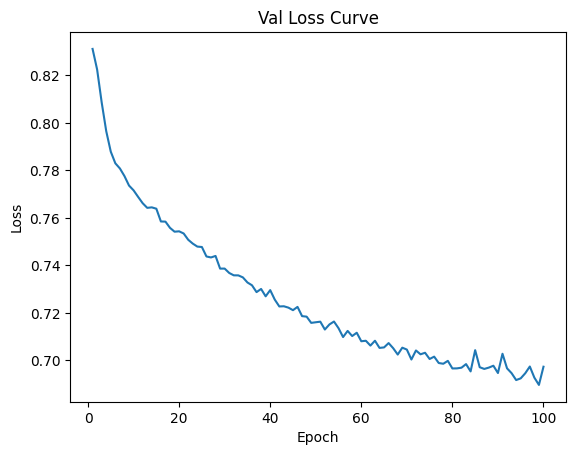

Finished Training Student for lambda value of 0
Student model CustomSmallCNN saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/CustomSmallCNN_lambda0_20231207_032946.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/CustomSmallCNN_weights_lambda0_20231207_032946.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 1/100*****
*****Train Loss:  1.266863 Val Loss:  0.828318*****
*****Validation Accuracy: 21.21%*****
*****Total Avg Disparity: 0.030372552039027167*****

Class Team_Sports: Recall Difference = 0.0014052164376049392
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.059339887640449396
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 2/100*****
*****Train Loss:  1.235785 Val Loss:  0.814544*****
*****Validation Accuracy: 21.41%*****
*****Total Avg Disparity: 0.04273020789968934*****

Class Team_Sports: Recall Difference = -0.016051456055568902
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.0756866416978777
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.036452525945621414
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Models_Not_Pretrained_11/student_validation_0.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 3/100*****
*****Train Loss:  1.216884 Val Loss:  0.801199*****
*****Validation Accuracy: 22.02%*****
*****Total Avg Disparity: 0.03571584367948874*****

Class Team_Sports: Recall Difference = 0.003450206212656126
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.010416666666666666
Class Waiter_Or_Waitress: Recall Difference = -0.030927835051546393
Class Individual_Sports: Recall Difference = 0.10529806491885135
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = -0.020545028741750057
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.04365726048546188
Class Family: Recall Difference = 0.0
Data has been appended to Smaller_Student_Model

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 4/100*****
*****Train Loss:  1.201786 Val Loss:  0.796413*****
*****Validation Accuracy: 22.28%*****
*****Total Avg Disparity: 0.054900550559223105*****

Class Team_Sports: Recall Difference = 0.03901474906033309
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = -0.10309278350515463
Class Individual_Sports: Recall Difference = 0.12285424469413236
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = -0.006919310197998754
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.04237070074620464
Class Family: Recall Difference = -0.015151515151515152
Data has been appended to Smaller_Student_Model

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 5/100*****
*****Train Loss:  1.191979 Val Loss:  0.789499*****
*****Validation Accuracy: 22.97%*****
*****Total Avg Disparity: 0.04019699123846204*****

Class Team_Sports: Recall Difference = 0.006797591710365425
Class Celebration: Recall Difference = -0.01
Class Parade: Recall Difference = -0.02367424242424243
Class Waiter_Or_Waitress: Recall Difference = -0.0660557464681176
Class Individual_Sports: Recall Difference = 0.07139513108614232
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780437
Class Water_Activities: Recall Difference = -0.04449648711943796
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.008319752980530032
Class Family: Recall Difference = 0.018259518259518263
Data has been

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 6/100*****
*****Train Loss:  1.183484 Val Loss:  0.782785*****
*****Validation Accuracy: 24.36%*****
*****Total Avg Disparity: 0.04930421473508923*****

Class Team_Sports: Recall Difference = 0.03287977973517964
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = -0.02935606060606058
Class Waiter_Or_Waitress: Recall Difference = -0.0477281405116457
Class Individual_Sports: Recall Difference = 0.11754837702871407
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.12475049900199602
Class Water_Activities: Recall Difference = -0.003512880562060894
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.038768333476284444
Class Family: Recall Difference = 0.02836052836052835

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 7/100*****
*****Train Loss:  1.176502 Val Loss:  0.781184*****
*****Validation Accuracy: 24.76%*****
*****Total Avg Disparity: 0.045988216713070476*****

Class Team_Sports: Recall Difference = 0.014177834138762169
Class Celebration: Recall Difference = -0.005990099009900995
Class Parade: Recall Difference = -0.05871212121212116
Class Waiter_Or_Waitress: Recall Difference = -0.06223749522718594
Class Individual_Sports: Recall Difference = 0.12304931335830216
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11876247504990019
Class Water_Activities: Recall Difference = -0.02129018522461143
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.005060468307745092
Class Family: Recall Difference =

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 8/100*****
*****Train Loss:  1.169845 Val Loss:  0.775161*****
*****Validation Accuracy: 24.56%*****
*****Total Avg Disparity: 0.050009489749326216*****

Class Team_Sports: Recall Difference = -0.007917195050896275
Class Celebration: Recall Difference = -9.90099009900991e-05
Class Parade: Recall Difference = -0.044507575757575774
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.08017322097378277
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732536
Class Water_Activities: Recall Difference = 0.01149670002129019
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.06844497812848443
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 9/100*****
*****Train Loss:  1.165407 Val Loss:  0.773011*****
*****Validation Accuracy: 25.02%*****
*****Total Avg Disparity: 0.05561690951717625*****

Class Team_Sports: Recall Difference = -0.04078555026219277
Class Celebration: Recall Difference = -0.020099009900990096
Class Parade: Recall Difference = -0.054924242424242375
Class Waiter_Or_Waitress: Recall Difference = -0.10118365788468883
Class Individual_Sports: Recall Difference = 0.06261704119850175
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.002661273153076446
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0756497126683249
Class Family: Recall Difference = 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 10/100*****
*****Train Loss:  1.160698 Val Loss:  0.769661*****
*****Validation Accuracy: 25.54%*****
*****Total Avg Disparity: 0.04369404624221312*****

Class Team_Sports: Recall Difference = 0.0057465355131325335
Class Celebration: Recall Difference = -0.0100990099009901
Class Parade: Recall Difference = -0.03314393939393945
Class Waiter_Or_Waitress: Recall Difference = -0.06643757159221073
Class Individual_Sports: Recall Difference = 0.11938202247191015
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = -0.016666666666666666
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780439
Class Water_Activities: Recall Difference = -0.002129018522461154
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01586757011750578
Class Family: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 11/100*****
*****Train Loss:  1.157713 Val Loss:  0.765859*****
*****Validation Accuracy: 25.86%*****
*****Total Avg Disparity: 0.04652961497563238*****

Class Team_Sports: Recall Difference = -0.017091087728918986
Class Celebration: Recall Difference = 0.028811881188118824
Class Parade: Recall Difference = -0.11079545454545459
Class Waiter_Or_Waitress: Recall Difference = -0.14242077128675068
Class Individual_Sports: Recall Difference = 0.028909176029962458
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = -0.0025821596244131467
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = -0.01511603150947416
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.02667467192726647
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 12/100*****
*****Train Loss:  1.154904 Val Loss:  0.765766*****
*****Validation Accuracy: 25.69%*****
*****Total Avg Disparity: 0.04417633305214869*****

Class Team_Sports: Recall Difference = 0.013777975802858444
Class Celebration: Recall Difference = -0.009999999999999998
Class Parade: Recall Difference = -0.053977272727272735
Class Waiter_Or_Waitress: Recall Difference = -0.14662084765177547
Class Individual_Sports: Recall Difference = 0.04728464419475659
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = -0.009624413145539907
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942116
Class Water_Activities: Recall Difference = 0.011496700021290218
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.034308259713526024
Class Family: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 13/100*****
*****Train Loss:  1.151130 Val Loss:  0.760227*****
*****Validation Accuracy: 26.35%*****
*****Total Avg Disparity: 0.05038845564530752*****

Class Team_Sports: Recall Difference = -0.03505043927294338
Class Celebration: Recall Difference = -0.010297029702970292
Class Parade: Recall Difference = -0.0984848484848484
Class Waiter_Or_Waitress: Recall Difference = -0.13631156930126004
Class Individual_Sports: Recall Difference = 0.08465980024968794
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.02488262910798121
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = 0.03129657228017882
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.002573119478514463
Class Family: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 14/100*****
*****Train Loss:  1.148129 Val Loss:  0.758881*****
*****Validation Accuracy: 26.35%*****
*****Total Avg Disparity: 0.049953366403256164*****

Class Team_Sports: Recall Difference = 0.004055705978453394
Class Celebration: Recall Difference = 0.018712871287128688
Class Parade: Recall Difference = -0.11553030303030298
Class Waiter_Or_Waitress: Recall Difference = -0.08896525391370758
Class Individual_Sports: Recall Difference = 0.11509051186017477
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = -0.017370892018779352
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = 0.020332126889503865
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.008233982331246226
Class Family: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 15/100*****
*****Train Loss:  1.146010 Val Loss:  0.758934*****
*****Validation Accuracy: 26.00%*****
*****Total Avg Disparity: 0.048791181384643584*****

Class Team_Sports: Recall Difference = 0.04590373696176209
Class Celebration: Recall Difference = 0.019504950495049515
Class Parade: Recall Difference = -0.0776515151515152
Class Waiter_Or_Waitress: Recall Difference = -0.08896525391370755
Class Individual_Sports: Recall Difference = 0.09140917602996257
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = 0.01854460093896714
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.046906187624750476
Class Water_Activities: Recall Difference = 0.012880562060889916
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.02581696543442835
Class Family: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 16/100*****
*****Train Loss:  1.143789 Val Loss:  0.755021*****
*****Validation Accuracy: 26.67%*****
*****Total Avg Disparity: 0.056999834802686555*****

Class Team_Sports: Recall Difference = 0.023705887057157038
Class Celebration: Recall Difference = 0.009504950495049513
Class Parade: Recall Difference = -0.07386363636363641
Class Waiter_Or_Waitress: Recall Difference = -0.14242077128675068
Class Individual_Sports: Recall Difference = 0.0793539325842696
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.03450704225352111
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.11277445109780437
Class Water_Activities: Recall Difference = 0.026506280604641247
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0455442147697058
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 17/100*****
*****Train Loss:  1.141000 Val Loss:  0.755729*****
*****Validation Accuracy: 26.32%*****
*****Total Avg Disparity: 0.05393445813758005*****

Class Team_Sports: Recall Difference = 0.050987650089682535
Class Celebration: Recall Difference = -0.010099009900990101
Class Parade: Recall Difference = -0.06628787878787873
Class Waiter_Or_Waitress: Recall Difference = -0.09316533027873236
Class Individual_Sports: Recall Difference = 0.10018726591760296
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = 0.015962441314553995
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = 0.03268043431977857
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.019041084141006942
Class Family: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 18/100*****
*****Train Loss:  1.136824 Val Loss:  0.752516*****
*****Validation Accuracy: 27.10%*****
*****Total Avg Disparity: 0.06391717224109437*****

Class Team_Sports: Recall Difference = 0.016771201060195806
Class Celebration: Recall Difference = -0.005099009900990098
Class Parade: Recall Difference = -0.06628787878787878
Class Waiter_Or_Waitress: Recall Difference = -0.14242077128675074
Class Individual_Sports: Recall Difference = 0.11427122347066171
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.08568075117370888
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.03576751117734728
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.03791062698344627
Class Family: Recall Difference 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 19/100*****
*****Train Loss:  1.133756 Val Loss:  0.748843*****
*****Validation Accuracy: 27.73%*****
*****Total Avg Disparity: 0.06416891738219478*****

Class Team_Sports: Recall Difference = 0.03742674024060044
Class Celebration: Recall Difference = -0.010099009900990101
Class Parade: Recall Difference = -0.08522727272727282
Class Waiter_Or_Waitress: Recall Difference = -0.09736540664375715
Class Individual_Sports: Recall Difference = 0.102020911360799
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.10416666666666667
Class Law_Enforcement: Recall Difference = 0.08239436619718304
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.03493013972055886
Class Water_Activities: Recall Difference = -0.09452842239727488
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.028561626211510427
Class Family: Recall 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 20/100*****
*****Train Loss:  1.133406 Val Loss:  0.752040*****
*****Validation Accuracy: 27.07%*****
*****Total Avg Disparity: 0.0589004211709149*****

Class Team_Sports: Recall Difference = 0.04006580525756598
Class Celebration: Recall Difference = -0.015198019801980198
Class Parade: Recall Difference = -0.07102272727272729
Class Waiter_Or_Waitress: Recall Difference = -0.14662084765177547
Class Individual_Sports: Recall Difference = 0.10365948813982517
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.04788732394366199
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10079840319361276
Class Water_Activities: Recall Difference = -0.02608047690014903
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01775452440174974
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 21/100*****
*****Train Loss:  1.130332 Val Loss:  0.748002*****
*****Validation Accuracy: 26.98%*****
*****Total Avg Disparity: 0.0654087428655732*****

Class Team_Sports: Recall Difference = 0.06131541967988485
Class Celebration: Recall Difference = -0.015297029702970304
Class Parade: Recall Difference = -0.048295454545454475
Class Waiter_Or_Waitress: Recall Difference = -0.1114929362352043
Class Individual_Sports: Recall Difference = 0.12020131086142327
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.06971830985915493
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.09481037924151696
Class Water_Activities: Recall Difference = -0.07611241217798587
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.018183377648168825
Class Family: Recall Difference =

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 22/100*****
*****Train Loss:  1.128543 Val Loss:  0.748767*****
*****Validation Accuracy: 27.07%*****
*****Total Avg Disparity: 0.053779400703894004*****

Class Team_Sports: Recall Difference = 0.03806651357804669
Class Celebration: Recall Difference = -0.025000000000000005
Class Parade: Recall Difference = -0.05871212121212119
Class Waiter_Or_Waitress: Recall Difference = -0.0786559755631921
Class Individual_Sports: Recall Difference = 0.12897940074906367
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = 0.05680751173708923
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.04790419161676647
Class Water_Activities: Recall Difference = -0.07196082605918669
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.009777854018354903
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 23/100*****
*****Train Loss:  1.126084 Val Loss:  0.741216*****
*****Validation Accuracy: 28.23%*****
*****Total Avg Disparity: 0.06859177579701431*****

Class Team_Sports: Recall Difference = 0.0325370440186904
Class Celebration: Recall Difference = -0.0257920792079208
Class Parade: Recall Difference = -0.11742424242424238
Class Waiter_Or_Waitress: Recall Difference = -0.09316533027873233
Class Individual_Sports: Recall Difference = 0.08996566791510618
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333334
Class Law_Enforcement: Recall Difference = 0.09201877934272298
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08882235528942115
Class Water_Activities: Recall Difference = -0.07196082605918674
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.04511536152328677
Class Family: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 24/100*****
*****Train Loss:  1.123372 Val Loss:  0.740081*****
*****Validation Accuracy: 28.25%*****
*****Total Avg Disparity: 0.06377202855362712*****

Class Team_Sports: Recall Difference = 0.06795306805588885
Class Celebration: Recall Difference = -0.0453960396039604
Class Parade: Recall Difference = -0.08617424242424249
Class Waiter_Or_Waitress: Recall Difference = -0.05192821687667046
Class Individual_Sports: Recall Difference = 0.06117353308364548
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.0849765258215962
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.0658682634730539
Class Water_Activities: Recall Difference = -0.13561847988077508
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.023586928553049114
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 25/100*****
*****Train Loss:  1.121948 Val Loss:  0.741358*****
*****Validation Accuracy: 27.73%*****
*****Total Avg Disparity: 0.04611231249071784*****

Class Team_Sports: Recall Difference = 0.008248506243502374
Class Celebration: Recall Difference = -0.010198019801980197
Class Parade: Recall Difference = -0.05303030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.05803741886216113
Class Individual_Sports: Recall Difference = 0.08079744069912609
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.04976525821596242
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.08283433133732535
Class Water_Activities: Recall Difference = -0.045986800085160706
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.029419332704348544
Class Family: Recall Differenc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 26/100*****
*****Train Loss:  1.118973 Val Loss:  0.738183*****
*****Validation Accuracy: 28.37%*****
*****Total Avg Disparity: 0.058355042237317106*****

Class Team_Sports: Recall Difference = 0.04111686145479876
Class Celebration: Recall Difference = -0.02128712871287125
Class Parade: Recall Difference = -0.08143939393939398
Class Waiter_Or_Waitress: Recall Difference = -0.08285605192821685
Class Individual_Sports: Recall Difference = 0.0905898876404494
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.0568075117370892
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0588822355289421
Class Water_Activities: Recall Difference = -0.1054928677879497
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.011407496354747415
Class Family: Recall Difference = 0.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 27/100*****
*****Train Loss:  1.118452 Val Loss:  0.736943*****
*****Validation Accuracy: 28.43%*****
*****Total Avg Disparity: 0.06246336373217864*****

Class Team_Sports: Recall Difference = 0.04147102169517081
Class Celebration: Recall Difference = -0.0068811881188118595
Class Parade: Recall Difference = -0.10227272727272729
Class Waiter_Or_Waitress: Recall Difference = -0.10118365788468885
Class Individual_Sports: Recall Difference = 0.06464575530586769
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = 0.09460093896713612
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.046906187624750476
Class Water_Activities: Recall Difference = -0.1390249095167128
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.02264345141092719
Cla

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 28/100*****
*****Train Loss:  1.115432 Val Loss:  0.735639*****
*****Validation Accuracy: 28.46%*****
*****Total Avg Disparity: 0.06377858257167979*****

Class Team_Sports: Recall Difference = 0.019867247032479995
Class Celebration: Recall Difference = -0.030495049504950487
Class Parade: Recall Difference = -0.10037878787878796
Class Waiter_Or_Waitress: Recall Difference = -0.1156930126002291
Class Individual_Sports: Recall Difference = 0.1273408239700375
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.06643192488262911
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.05389221556886228
Class Water_Activities: Recall Difference = -0.1048541622312113
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0006861651942705604
Class Family: Recall Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 29/100*****
*****Train Loss:  1.113818 Val Loss:  0.734128*****
*****Validation Accuracy: 28.69%*****
*****Total Avg Disparity: 0.06900403789241014*****

Class Team_Sports: Recall Difference = 0.009093921010841832
Class Celebration: Recall Difference = -0.0102970297029703
Class Parade: Recall Difference = -0.11931818181818182
Class Waiter_Or_Waitress: Recall Difference = -0.1405116456662848
Class Individual_Sports: Recall Difference = 0.10997971285892633
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.0875586854460094
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.04091816367265466
Class Water_Activities: Recall Difference = -0.12124760485416225
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.014237927781113296
Clas

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 30/100*****
*****Train Loss:  1.112929 Val Loss:  0.731213*****
*****Validation Accuracy: 29.15%*****
*****Total Avg Disparity: 0.06692307505458715*****

Class Team_Sports: Recall Difference = 0.034284996172784576
Class Celebration: Recall Difference = -0.04059405940594059
Class Parade: Recall Difference = -0.09469696969696972
Class Waiter_Or_Waitress: Recall Difference = -0.06643757159221075
Class Individual_Sports: Recall Difference = 0.060978464419475686
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333334
Class Law_Enforcement: Recall Difference = 0.052347417840375554
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.06487025948103793
Class Water_Activities: Recall Difference = -0.11922503725782424
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.01020670726477399

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 31/100*****
*****Train Loss:  1.109943 Val Loss:  0.731863*****
*****Validation Accuracy: 28.43%*****
*****Total Avg Disparity: 0.06266948104965543*****

Class Team_Sports: Recall Difference = 0.07139184974466195
Class Celebration: Recall Difference = -0.015495049504950488
Class Parade: Recall Difference = -0.06439393939393945
Class Waiter_Or_Waitress: Recall Difference = -0.11149293623520429
Class Individual_Sports: Recall Difference = 0.04361735330836447
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = 0.08685446009389669
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.07684630738522953
Class Water_Activities: Recall Difference = -0.062380242708111544
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.007805129084827167
Class Family: Recall Difference 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 32/100*****
*****Train Loss:  1.108766 Val Loss:  0.729176*****
*****Validation Accuracy: 29.24%*****
*****Total Avg Disparity: 0.06701088621846807*****

Class Team_Sports: Recall Difference = 0.04191657812660665
Class Celebration: Recall Difference = -0.02559405940594059
Class Parade: Recall Difference = -0.10890151515151514
Class Waiter_Or_Waitress: Recall Difference = -0.1611302023673158
Class Individual_Sports: Recall Difference = 0.03604868913857684
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = 0.08755868544600937
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.05389221556886228
Class Water_Activities: Recall Difference = -0.12539919097296143
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.029933956600051465
C

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 33/100*****
*****Train Loss:  1.106458 Val Loss:  0.729703*****
*****Validation Accuracy: 29.06%*****
*****Total Avg Disparity: 0.05375187097026036*****

Class Team_Sports: Recall Difference = 0.03358810021592351
Class Celebration: Recall Difference = -0.05648514851485148
Class Parade: Recall Difference = -0.0558712121212121
Class Waiter_Or_Waitress: Recall Difference = -0.09507445589919816
Class Individual_Sports: Recall Difference = 0.026841448189762862
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.10416666666666667
Class Law_Enforcement: Recall Difference = 0.09906103286384974
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.04790419161676646
Class Water_Activities: Recall Difference = -0.08782201405152235
Class Picnic: Recall Difference = -0.0196078431372549
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.011661211129296235
Class Performance_And_Entertainment: Recall Difference = -0.033

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 34/100*****
*****Train Loss:  1.104637 Val Loss:  0.728075*****
*****Validation Accuracy: 29.18%*****
*****Total Avg Disparity: 0.07548547363581162*****

Class Team_Sports: Recall Difference = 0.04276199289394622
Class Celebration: Recall Difference = -0.0013861386138613874
Class Parade: Recall Difference = -0.08806818181818182
Class Waiter_Or_Waitress: Recall Difference = -0.156930126002291
Class Individual_Sports: Recall Difference = 0.09589575530586769
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.09647887323943657
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.07085828343313372
Class Water_Activities: Recall Difference = -0.050138386203959995
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.008319752980530032
Class Family: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 35/100*****
*****Train Loss:  1.103803 Val Loss:  0.724089*****
*****Validation Accuracy: 29.58%*****
*****Total Avg Disparity: 0.06550521818580796*****

Class Team_Sports: Recall Difference = 0.04107116335926686
Class Celebration: Recall Difference = 0.009009900990099018
Class Parade: Recall Difference = -0.0558712121212121
Class Waiter_Or_Waitress: Recall Difference = -0.08705612829324166
Class Individual_Sports: Recall Difference = 0.0681179775280899
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.08943661971830982
Class Business: Recall Difference = -0.010752688172043012
Class Dresses: Recall Difference = 0.03493013972055886
Class Water_Activities: Recall Difference = -0.16020864381520122
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0155

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 36/100*****
*****Train Loss:  1.102902 Val Loss:  0.723794*****
*****Validation Accuracy: 29.73%*****
*****Total Avg Disparity: 0.06339208288688362*****

Class Team_Sports: Recall Difference = 0.03752956095554727
Class Celebration: Recall Difference = -0.03118811881188116
Class Parade: Recall Difference = -0.051136363636363646
Class Waiter_Or_Waitress: Recall Difference = -0.11798396334478806
Class Individual_Sports: Recall Difference = 0.056882022471910154
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.0849765258215962
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.07684630738522953
Class Water_Activities: Recall Difference = -0.08846071960826069
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340425
Class Performance_And_Entertainment: Recall Difference = 0.05

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 37/100*****
*****Train Loss:  1.101311 Val Loss:  0.728139*****
*****Validation Accuracy: 29.26%*****
*****Total Avg Disparity: 0.061711792678189006*****

Class Team_Sports: Recall Difference = 0.06595377637636957
Class Celebration: Recall Difference = 0.008613861386138594
Class Parade: Recall Difference = -0.0445075757575758
Class Waiter_Or_Waitress: Recall Difference = -0.1011836578846888
Class Individual_Sports: Recall Difference = 0.049742509363295884
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = 0.08051643192488259
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.029940119760479045
Class Water_Activities: Recall Difference = -0.09527357888013632
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.018269148297452603
Class Family: Recall Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 38/100*****
*****Train Loss:  1.099162 Val Loss:  0.721402*****
*****Validation Accuracy: 30.16%*****
*****Total Avg Disparity: 0.07346528215296724*****

Class Team_Sports: Recall Difference = 0.0266534142189625
Class Celebration: Recall Difference = -0.041386138613861395
Class Parade: Recall Difference = -0.05681818181818177
Class Waiter_Or_Waitress: Recall Difference = -0.11569301260022909
Class Individual_Sports: Recall Difference = 0.09261860174781522
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.10539906103286384
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.1554183521396636
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340425
Class Performance_And_Entertainment: Recall D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 39/100*****
*****Train Loss:  1.096875 Val Loss:  0.720782*****
*****Validation Accuracy: 29.99%*****
*****Total Avg Disparity: 0.07084737855913995*****

Class Team_Sports: Recall Difference = 0.05857353394797271
Class Celebration: Recall Difference = -0.021683168316831702
Class Parade: Recall Difference = -0.0710227272727274
Class Waiter_Or_Waitress: Recall Difference = -0.09927453226422298
Class Individual_Sports: Recall Difference = 0.07096598002496879
Class Surgeons: Recall Difference = 0.024390243902439025
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.11314553990610327
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.05389221556886228
Class Water_Activities: Recall Difference = -0.12060889929742397
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.0002

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 40/100*****
*****Train Loss:  1.094710 Val Loss:  0.719050*****
*****Validation Accuracy: 30.07%*****
*****Total Avg Disparity: 0.06445205256424896*****

Class Team_Sports: Recall Difference = 0.05747677965520792
Class Celebration: Recall Difference = -0.06668316831683166
Class Parade: Recall Difference = -0.019886363636363646
Class Waiter_Or_Waitress: Recall Difference = -0.06643757159221075
Class Individual_Sports: Recall Difference = 0.04892322097378271
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.10610328638497654
Class Business: Recall Difference = -0.0008516980730331088
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.1458377687885885
Class Picnic: Recall Difference = -0.03921568627450981
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.01

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 41/100*****
*****Train Loss:  1.094162 Val Loss:  0.718593*****
*****Validation Accuracy: 29.93%*****
*****Total Avg Disparity: 0.06560471660837425*****

Class Team_Sports: Recall Difference = 0.026847631124972904
Class Celebration: Recall Difference = 0.004009900990099027
Class Parade: Recall Difference = -0.024621212121212155
Class Waiter_Or_Waitress: Recall Difference = -0.0561282932416953
Class Individual_Sports: Recall Difference = 0.06975655430711608
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.11126760563380281
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.07784431137724551
Class Water_Activities: Recall Difference = -0.16361507345113907
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.051

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 42/100*****
*****Train Loss:  1.092785 Val Loss:  0.715732*****
*****Validation Accuracy: 30.25%*****
*****Total Avg Disparity: 0.06714172929920696*****

Class Team_Sports: Recall Difference = 0.0381236361974614
Class Celebration: Recall Difference = -0.0462871287128713
Class Parade: Recall Difference = -0.1136363636363637
Class Waiter_Or_Waitress: Recall Difference = -0.15273004963726614
Class Individual_Sports: Recall Difference = 0.060549313358302215
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = 0.04577464788732394
Class Business: Recall Difference = -0.010752688172043008
Class Dresses: Recall Difference = 0.02295409181636726
Class Water_Activities: Recall Difference = -0.13221205024483712
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.026760442576550303

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 43/100*****
*****Train Loss:  1.091645 Val Loss:  0.715365*****
*****Validation Accuracy: 30.97%*****
*****Total Avg Disparity: 0.058703022530067706*****

Class Team_Sports: Recall Difference = 0.037129702619643434
Class Celebration: Recall Difference = -0.017079207920792094
Class Parade: Recall Difference = -0.04640151515151514
Class Waiter_Or_Waitress: Recall Difference = -0.03360061092019856
Class Individual_Sports: Recall Difference = 0.09179931335830216
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.03356807511737092
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = -0.1437125748502994
Class Water_Activities: Recall Difference = -0.11922503725782424
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Dif

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 44/100*****
*****Train Loss:  1.089035 Val Loss:  0.714463*****
*****Validation Accuracy: 30.45%*****
*****Total Avg Disparity: 0.06828054235321764*****

Class Team_Sports: Recall Difference = 0.03538175046554948
Class Celebration: Recall Difference = -0.021386138613861405
Class Parade: Recall Difference = -0.04356060606060602
Class Waiter_Or_Waitress: Recall Difference = -0.07674684994272621
Class Individual_Sports: Recall Difference = 0.1018258426966292
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.1105633802816901
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.0658682634730539
Class Water_Activities: Recall Difference = -0.130083031722376
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.003773908568487860

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 45/100*****
*****Train Loss:  1.088109 Val Loss:  0.711578*****
*****Validation Accuracy: 30.53%*****
*****Total Avg Disparity: 0.06418269017068198*****

Class Team_Sports: Recall Difference = 0.02695045183991951
Class Celebration: Recall Difference = 0.0038118811881188014
Class Parade: Recall Difference = -0.05303030303030304
Class Waiter_Or_Waitress: Recall Difference = 0.02825505918289417
Class Individual_Sports: Recall Difference = 0.09445224719101125
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.06948356807511741
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.11976047904191618
Class Water_Activities: Recall Difference = -0.10283159463487335
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.010978643108328329
Cla

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 46/100*****
*****Train Loss:  1.085773 Val Loss:  0.712954*****
*****Validation Accuracy: 30.30%*****
*****Total Avg Disparity: 0.053408586423590046*****

Class Team_Sports: Recall Difference = 0.0347305526042202
Class Celebration: Recall Difference = 0.029009900990099022
Class Parade: Recall Difference = -0.07102272727272735
Class Waiter_Or_Waitress: Recall Difference = -0.06223749522718591
Class Individual_Sports: Recall Difference = 0.04564606741573035
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.1105633802816901
Class Business: Recall Difference = -0.000851698073033107
Class Dresses: Recall Difference = -0.07784431137724551
Class Water_Activities: Recall Difference = -0.0652544177134341
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 47/100*****
*****Train Loss:  1.085336 Val Loss:  0.710782*****
*****Validation Accuracy: 31.17%*****
*****Total Avg Disparity: 0.06276025672005801*****

Class Team_Sports: Recall Difference = 0.04161954050564953
Class Celebration: Recall Difference = -0.09678217821782178
Class Parade: Recall Difference = -0.05303030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.08705612829324172
Class Individual_Sports: Recall Difference = 0.034410112359550604
Class Surgeons: Recall Difference = -0.005912786400591279
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = -0.024178403755868605
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.07206727698530974
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 48/100*****
*****Train Loss:  1.082932 Val Loss:  0.719169*****
*****Validation Accuracy: 30.13%*****
*****Total Avg Disparity: 0.05752477830058992*****

Class Team_Sports: Recall Difference = 0.01527458843152718
Class Celebration: Recall Difference = 0.013811881188118796
Class Parade: Recall Difference = -0.07196969696969702
Class Waiter_Or_Waitress: Recall Difference = -0.08056510118365787
Class Individual_Sports: Recall Difference = 0.03320068664169795
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.12276995305164318
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.0778443113772455
Class Water_Activities: Recall Difference = -0.07611241217798598
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.01698

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 49/100*****
*****Train Loss:  1.082975 Val Loss:  0.710129*****
*****Validation Accuracy: 31.31%*****
*****Total Avg Disparity: 0.05518315870008401*****

Class Team_Sports: Recall Difference = -0.010007882921479139
Class Celebration: Recall Difference = -0.061485148514851484
Class Parade: Recall Difference = -0.021780303030302983
Class Waiter_Or_Waitress: Recall Difference = -0.01909125620465829
Class Individual_Sports: Recall Difference = 0.11427122347066171
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.025821596244131384
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.14970059880239522
Class Water_Activities: Recall Difference = -0.10826059186714926
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.011661211129296231
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 50/100*****
*****Train Loss:  1.080386 Val Loss:  0.711686*****
*****Validation Accuracy: 30.30%*****
*****Total Avg Disparity: 0.06230568376140215*****

Class Team_Sports: Recall Difference = 0.06855856782168601
Class Celebration: Recall Difference = -0.03599009900990097
Class Parade: Recall Difference = 0.014204545454545525
Class Waiter_Or_Waitress: Recall Difference = -0.10347460862924776
Class Individual_Sports: Recall Difference = 0.0879369538077403
Class Surgeons: Recall Difference = 0.024390243902439025
Class Spa: Recall Difference = -0.18750000000000003
Class Law_Enforcement: Recall Difference = -0.00046948356807507974
Class Business: Recall Difference = -0.01075268817204301
Class Dresses: Recall Difference = -0.15568862275449102
Class Water_Activities: Recall Difference = -0.12060889929742385
Class Picnic: Recall Difference = -0.006535947712418305
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340425
Class Performance_And_En

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 51/100*****
*****Train Loss:  1.077799 Val Loss:  0.705701*****
*****Validation Accuracy: 31.00%*****
*****Total Avg Disparity: 0.06180401911181088*****

Class Team_Sports: Recall Difference = 0.06989523711599321
Class Celebration: Recall Difference = 0.004306930693069297
Class Parade: Recall Difference = -0.055871212121212266
Class Waiter_Or_Waitress: Recall Difference = -0.04390988927071404
Class Individual_Sports: Recall Difference = 0.12613139825218478
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.07840375586854459
Class Business: Recall Difference = -0.0008516980730331088
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.1308281882052374
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Entertainment: Recall Difference =

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 52/100*****
*****Train Loss:  1.077385 Val Loss:  0.703816*****
*****Validation Accuracy: 31.49%*****
*****Total Avg Disparity: 0.04994869733983869*****

Class Team_Sports: Recall Difference = 0.020118586557905105
Class Celebration: Recall Difference = -0.03198019801980198
Class Parade: Recall Difference = -0.0246212121212121
Class Waiter_Or_Waitress: Recall Difference = -0.0397098129056892
Class Individual_Sports: Recall Difference = 0.05196629213483145
Class Surgeons: Recall Difference = -0.005912786400591282
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.06948356807511735
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = -0.09580838323353294
Class Water_Activities: Recall Difference = -0.04747711305088359
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.011661211129296231
Class Performance_And_Entertai

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 53/100*****
*****Train Loss:  1.076504 Val Loss:  0.705033*****
*****Validation Accuracy: 31.86%*****
*****Total Avg Disparity: 0.06100256723155218*****

Class Team_Sports: Recall Difference = 0.04301333241937144
Class Celebration: Recall Difference = -0.056980198019801975
Class Parade: Recall Difference = -0.02083333333333326
Class Waiter_Or_Waitress: Recall Difference = -0.09927453226422298
Class Individual_Sports: Recall Difference = 0.03788233458177276
Class Surgeons: Recall Difference = 0.024390243902439025
Class Spa: Recall Difference = -0.10416666666666667
Class Law_Enforcement: Recall Difference = 0.06690140845070425
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = -0.11377245508982037
Class Water_Activities: Recall Difference = -0.10900574835001059
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.023529411764705885
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertain

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 54/100*****
*****Train Loss:  1.074037 Val Loss:  0.704575*****
*****Validation Accuracy: 31.26%*****
*****Total Avg Disparity: 0.061454225791533916*****

Class Team_Sports: Recall Difference = 0.04031714478299109
Class Celebration: Recall Difference = -0.0067821782178217604
Class Parade: Recall Difference = -0.017045454545454586
Class Waiter_Or_Waitress: Recall Difference = -0.13631156930126
Class Individual_Sports: Recall Difference = 0.057077091136079894
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.09131455399061036
Class Business: Recall Difference = -0.001703396146066214
Class Dresses: Recall Difference = -0.04790419161676647
Class Water_Activities: Recall Difference = -0.12401532893336181
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558094
Class Performance_And_E

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 55/100*****
*****Train Loss:  1.072509 Val Loss:  0.703995*****
*****Validation Accuracy: 32.06%*****
*****Total Avg Disparity: 0.07591373779693779*****

Class Team_Sports: Recall Difference = 0.06601089899578438
Class Celebration: Recall Difference = -0.04336633663366335
Class Parade: Recall Difference = -0.011363636363636298
Class Waiter_Or_Waitress: Recall Difference = -0.06643757159221075
Class Individual_Sports: Recall Difference = 0.0644506866416979
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.10416666666666667
Class Law_Enforcement: Recall Difference = 0.1246478873239436
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.2155688622754491
Class Water_Activities: Recall Difference = -0.1308281882052374
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0181833

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 56/100*****
*****Train Loss:  1.071817 Val Loss:  0.700486*****
*****Validation Accuracy: 31.66%*****
*****Total Avg Disparity: 0.0596804722042001*****

Class Team_Sports: Recall Difference = 0.05144463104500119
Class Celebration: Recall Difference = -0.041287128712871296
Class Parade: Recall Difference = -0.05492424242424243
Class Waiter_Or_Waitress: Recall Difference = -0.11798396334478811
Class Individual_Sports: Recall Difference = 0.04014513108614226
Class Surgeons: Recall Difference = 0.024390243902439025
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = 0.023239436619718223
Class Business: Recall Difference = -0.01160438624507612
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.1212476048541623
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340425
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 57/100*****
*****Train Loss:  1.071261 Val Loss:  0.704253*****
*****Validation Accuracy: 31.63%*****
*****Total Avg Disparity: 0.053994742448850226*****

Class Team_Sports: Recall Difference = 0.022609132764392026
Class Celebration: Recall Difference = -0.04698019801980194
Class Parade: Recall Difference = -0.031249999999999944
Class Waiter_Or_Waitress: Recall Difference = -0.06834669721267661
Class Individual_Sports: Recall Difference = 0.053409800249687944
Class Surgeons: Recall Difference = -0.005912786400591275
Class Spa: Recall Difference = -0.12500000000000003
Class Law_Enforcement: Recall Difference = 0.09319248826291082
Class Business: Recall Difference = -0.0008516980730331088
Class Dresses: Recall Difference = -0.11377245508982037
Class Water_Activities: Recall Difference = -0.06589312327017244
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: R

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 58/100*****
*****Train Loss:  1.070353 Val Loss:  0.699577*****
*****Validation Accuracy: 32.27%*****
*****Total Avg Disparity: 0.07779806297286364*****

Class Team_Sports: Recall Difference = 0.05129611223452257
Class Celebration: Recall Difference = -0.01599009900990099
Class Parade: Recall Difference = -0.013257575757575801
Class Waiter_Or_Waitress: Recall Difference = -0.10576555937380688
Class Individual_Sports: Recall Difference = 0.10916042446941326
Class Surgeons: Recall Difference = 0.048780487804878044
Class Spa: Recall Difference = -0.25000000000000006
Class Law_Enforcement: Recall Difference = 0.10469483568075116
Class Business: Recall Difference = -0.09453848610667516
Class Dresses: Recall Difference = -0.14970059880239522
Class Water_Activities: Recall Difference = -0.10421545667447307
Class Picnic: Recall Difference = -0.006535947712418305
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:22<00:00,  2.41it/s]


*****Epoch 59/100*****
*****Train Loss:  1.067856 Val Loss:  0.695846*****
*****Validation Accuracy: 31.89%*****
*****Total Avg Disparity: 0.07116676968895552*****

Class Team_Sports: Recall Difference = 0.025853697547154608
Class Celebration: Recall Difference = -0.00108910891089109
Class Parade: Recall Difference = -0.07670454545454547
Class Waiter_Or_Waitress: Recall Difference = -0.10385643375334097
Class Individual_Sports: Recall Difference = 0.10486891385767788
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.15023474178403756
Class Business: Recall Difference = -0.053763440860215055
Class Dresses: Recall Difference = -0.10778443113772454
Class Water_Activities: Recall Difference = -0.04886097509048326
Class Picnic: Recall Difference = -0.08496732026143791
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.022299509001636658
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 60/100*****
*****Train Loss:  1.066193 Val Loss:  0.695496*****
*****Validation Accuracy: 32.41%*****
*****Total Avg Disparity: 0.05515805189523794*****

Class Team_Sports: Recall Difference = 0.008694062674938108
Class Celebration: Recall Difference = -0.041386138613861395
Class Parade: Recall Difference = -0.004734848484848453
Class Waiter_Or_Waitress: Recall Difference = -0.11378388697976324
Class Individual_Sports: Recall Difference = 0.06729868913857684
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.1272300469483568
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.016074089844581696
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.022299509001636658
Class Performance_And_En

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 61/100*****
*****Train Loss:  1.064051 Val Loss:  0.697688*****
*****Validation Accuracy: 32.01%*****
*****Total Avg Disparity: 0.054592848351888906*****

Class Team_Sports: Recall Difference = 0.024505603728964598
Class Celebration: Recall Difference = -0.022376237623762313
Class Parade: Recall Difference = -0.02840909090909105
Class Waiter_Or_Waitress: Recall Difference = -0.07254677357770142
Class Individual_Sports: Recall Difference = 0.07752028714107367
Class Surgeons: Recall Difference = -0.005912786400591275
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.11690140845070424
Class Business: Recall Difference = -0.022357074417119132
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.08228656589312333
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558076
Class Performance_And_E

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 62/100*****
*****Train Loss:  1.064598 Val Loss:  0.698215*****
*****Validation Accuracy: 31.52%*****
*****Total Avg Disparity: 0.05541968541527727*****

Class Team_Sports: Recall Difference = 0.09978179159383532
Class Celebration: Recall Difference = -0.08267326732673264
Class Parade: Recall Difference = -0.03977272727272735
Class Waiter_Or_Waitress: Recall Difference = -0.08094692630775102
Class Individual_Sports: Recall Difference = 0.0368679775280899
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = -0.0011737089201878104
Class Business: Recall Difference = 0.009049292025976789
Class Dresses: Recall Difference = -0.10179640718562873
Class Water_Activities: Recall Difference = -0.0782414307004472
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = -0.04465240641711231
Class Cheering: Recall Difference = -0.010638297872340425
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 63/100*****
*****Train Loss:  1.063883 Val Loss:  0.696128*****
*****Validation Accuracy: 32.35%*****
*****Total Avg Disparity: 0.055090843220662315*****

Class Team_Sports: Recall Difference = 0.01782225725742881
Class Celebration: Recall Difference = -0.026980198019802004
Class Parade: Recall Difference = -0.03030303030303033
Class Waiter_Or_Waitress: Recall Difference = -0.0706376479572356
Class Individual_Sports: Recall Difference = 0.08302122347066176
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.025821596244131384
Class Business: Recall Difference = -0.02576386670925155
Class Dresses: Recall Difference = -0.14970059880239522
Class Water_Activities: Recall Difference = -0.03512880562060888
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 64/100*****
*****Train Loss:  1.061356 Val Loss:  0.692978*****
*****Validation Accuracy: 32.61%*****
*****Total Avg Disparity: 0.06238570303819172*****

Class Team_Sports: Recall Difference = 0.016874021775142523
Class Celebration: Recall Difference = -0.03178217821782181
Class Parade: Recall Difference = -0.0028409090909090606
Class Waiter_Or_Waitress: Recall Difference = -0.07674684994272624
Class Individual_Sports: Recall Difference = 0.07486735330836458
Class Surgeons: Recall Difference = 0.024390243902439025
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.12840375586854458
Class Business: Recall Difference = -0.03310976258916214
Class Dresses: Recall Difference = -0.11377245508982037
Class Water_Activities: Recall Difference = -0.1362571854375133
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558076
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 65/100*****
*****Train Loss:  1.060229 Val Loss:  0.698666*****
*****Validation Accuracy: 32.29%*****
*****Total Avg Disparity: 0.06064752849946687*****

Class Team_Sports: Recall Difference = 0.010487712924563741
Class Celebration: Recall Difference = -0.016188118811881202
Class Parade: Recall Difference = -0.058712121212121215
Class Waiter_Or_Waitress: Recall Difference = -0.11378388697976324
Class Individual_Sports: Recall Difference = 0.06729868913857684
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.12499999999999999
Class Law_Enforcement: Recall Difference = 0.14061032863849768
Class Business: Recall Difference = -0.011604386245076119
Class Dresses: Recall Difference = -0.11976047904191618
Class Water_Activities: Recall Difference = -0.038535235256546785
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Entertainment: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 66/100*****
*****Train Loss:  1.059162 Val Loss:  0.695829*****
*****Validation Accuracy: 32.24%*****
*****Total Avg Disparity: 0.05002346847810841*****

Class Team_Sports: Recall Difference = 0.08451862768619112
Class Celebration: Recall Difference = -0.01316831683168318
Class Parade: Recall Difference = -0.021780303030302983
Class Waiter_Or_Waitress: Recall Difference = -0.08094692630775102
Class Individual_Sports: Recall Difference = 0.028284956304619246
Class Surgeons: Recall Difference = 0.018477457501847754
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = -0.007511737089201886
Class Business: Recall Difference = -0.001703396146066221
Class Dresses: Recall Difference = -0.10778443113772455
Class Water_Activities: Recall Difference = -0.009261230572706003
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = 0.0
Class Performance_And_E

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 67/100*****
*****Train Loss:  1.058455 Val Loss:  0.691788*****
*****Validation Accuracy: 33.25%*****
*****Total Avg Disparity: 0.06926567617820407*****

Class Team_Sports: Recall Difference = 0.02081548251476617
Class Celebration: Recall Difference = -0.0327722772277228
Class Parade: Recall Difference = -0.03882575757575757
Class Waiter_Or_Waitress: Recall Difference = -0.08094692630775108
Class Individual_Sports: Recall Difference = 0.1030352684144819
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.1406103286384976
Class Business: Recall Difference = -0.03566485680826148
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.10762188631041097
Class Picnic: Recall Difference = -0.07843137254901959
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.022299509001636658
Class Performance_And_Entertainme

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 68/100*****
*****Train Loss:  1.057334 Val Loss:  0.691386*****
*****Validation Accuracy: 32.73%*****
*****Total Avg Disparity: 0.058006887355076676*****

Class Team_Sports: Recall Difference = 0.06710765328854917
Class Celebration: Recall Difference = -0.06198019801980198
Class Parade: Recall Difference = -0.005681818181818177
Class Waiter_Or_Waitress: Recall Difference = -0.04581901489117984
Class Individual_Sports: Recall Difference = 0.03522940074906372
Class Surgeons: Recall Difference = 0.024390243902439025
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.061032863849765195
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.0776027251437087
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Entertainment: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 69/100*****
*****Train Loss:  1.054630 Val Loss:  0.694050*****
*****Validation Accuracy: 32.21%*****
*****Total Avg Disparity: 0.04716429328453699*****

Class Team_Sports: Recall Difference = 0.002707612160263273
Class Celebration: Recall Difference = -0.0816831683168317
Class Parade: Recall Difference = -0.0018939393939393923
Class Waiter_Or_Waitress: Recall Difference = -0.08476517754868271
Class Individual_Sports: Recall Difference = 0.0170490012484395
Class Surgeons: Recall Difference = -0.005912786400591275
Class Spa: Recall Difference = -0.12499999999999999
Class Law_Enforcement: Recall Difference = 0.023239436619718223
Class Business: Recall Difference = 0.0099009900990099
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.08090270385352355
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 70/100*****
*****Train Loss:  1.056570 Val Loss:  0.687787*****
*****Validation Accuracy: 32.21%*****
*****Total Avg Disparity: 0.06468149514357102*****

Class Team_Sports: Recall Difference = -0.0002856130970741999
Class Celebration: Recall Difference = -0.011584158415841622
Class Parade: Recall Difference = -0.03219696969696978
Class Waiter_Or_Waitress: Recall Difference = -0.08094692630775102
Class Individual_Sports: Recall Difference = 0.10264513108614237
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.13098591549295768
Class Business: Recall Difference = 0.009049292025976792
Class Dresses: Recall Difference = -0.10778443113772455
Class Water_Activities: Recall Difference = -0.10070257611241223
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 71/100*****
*****Train Loss:  1.054027 Val Loss:  0.688563*****
*****Validation Accuracy: 32.41%*****
*****Total Avg Disparity: 0.06927493012396693*****

Class Team_Sports: Recall Difference = 0.07010087854588665
Class Celebration: Recall Difference = -0.012376237623762387
Class Parade: Recall Difference = -0.020833333333333426
Class Waiter_Or_Waitress: Recall Difference = -0.10156548300878199
Class Individual_Sports: Recall Difference = 0.04034019975031211
Class Surgeons: Recall Difference = 0.018477457501847754
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.11173708920187797
Class Business: Recall Difference = 0.0387522623230065
Class Dresses: Recall Difference = -0.10778443113772455
Class Water_Activities: Recall Difference = -0.13561847988077508
Class Picnic: Recall Difference = 0.013071895424836596
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.011661211129296235
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 72/100*****
*****Train Loss:  1.053860 Val Loss:  0.691688*****
*****Validation Accuracy: 32.03%*****
*****Total Avg Disparity: 0.06680162573931388*****

Class Team_Sports: Recall Difference = -0.01580011653014346
Class Celebration: Recall Difference = -0.0006930693069306937
Class Parade: Recall Difference = -0.04356060606060608
Class Waiter_Or_Waitress: Recall Difference = -0.05803741886216113
Class Individual_Sports: Recall Difference = 0.07034176029962547
Class Surgeons: Recall Difference = 0.07317073170731708
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.14953051643192483
Class Business: Recall Difference = -0.06536782710529117
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.027677240791994906
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558094
Class Performance_And_En

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 73/100*****
*****Train Loss:  1.051692 Val Loss:  0.688294*****
*****Validation Accuracy: 33.77%*****
*****Total Avg Disparity: 0.0718581825763854*****

Class Team_Sports: Recall Difference = 0.040419965497937804
Class Celebration: Recall Difference = -0.061287128712871286
Class Parade: Recall Difference = -0.06818181818181812
Class Waiter_Or_Waitress: Recall Difference = -0.0973654066437572
Class Individual_Sports: Recall Difference = 0.04931335830212241
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.053286384976525825
Class Business: Recall Difference = -0.048972639199403825
Class Dresses: Recall Difference = -0.19760479041916168
Class Water_Activities: Recall Difference = -0.007877368533106277
Class Picnic: Recall Difference = -0.06535947712418302
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 74/100*****
*****Train Loss:  1.049772 Val Loss:  0.687142*****
*****Validation Accuracy: 33.22%*****
*****Total Avg Disparity: 0.04259148400500619*****

Class Team_Sports: Recall Difference = 0.04176805931612804
Class Celebration: Recall Difference = -0.04326732673267336
Class Parade: Recall Difference = -0.009469696969697072
Class Waiter_Or_Waitress: Recall Difference = -0.025200458190148878
Class Individual_Sports: Recall Difference = 0.05114700374531833
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.10416666666666666
Class Law_Enforcement: Recall Difference = 0.05211267605633796
Class Business: Recall Difference = 0.005642499733844349
Class Dresses: Recall Difference = -0.09580838323353294
Class Water_Activities: Recall Difference = 0.011922503725782296
Class Picnic: Recall Difference = -0.06535947712418302
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.021276595744680847
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 75/100*****
*****Train Loss:  1.050791 Val Loss:  0.684835*****
*****Validation Accuracy: 32.81%*****
*****Total Avg Disparity: 0.07232340828771727*****

Class Team_Sports: Recall Difference = 0.03757525905107906
Class Celebration: Recall Difference = -0.025693069306930702
Class Parade: Recall Difference = -0.09753787878787884
Class Waiter_Or_Waitress: Recall Difference = -0.1531118747613593
Class Individual_Sports: Recall Difference = 0.056882022471910154
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.13474178403755865
Class Business: Recall Difference = -0.001703396146066221
Class Dresses: Recall Difference = -0.125748502994012
Class Water_Activities: Recall Difference = -0.06727698530977227
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = -0.010962566844919787
Class Cheering: Recall Difference = 0.009615384615384614
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 76/100*****
*****Train Loss:  1.049858 Val Loss:  0.687377*****
*****Validation Accuracy: 32.70%*****
*****Total Avg Disparity: 0.05998207888132921*****

Class Team_Sports: Recall Difference = 0.099930310404314
Class Celebration: Recall Difference = -0.00945544554455452
Class Parade: Recall Difference = -0.013257575757575746
Class Waiter_Or_Waitress: Recall Difference = -0.056128293241695326
Class Individual_Sports: Recall Difference = 0.03522940074906372
Class Surgeons: Recall Difference = 0.018477457501847754
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.09694835680751179
Class Business: Recall Difference = 0.018098584051953585
Class Dresses: Recall Difference = -0.11976047904191618
Class Water_Activities: Recall Difference = -0.0037257824143069884
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.011661211129296236
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 77/100*****
*****Train Loss:  1.047266 Val Loss:  0.687911*****
*****Validation Accuracy: 33.10%*****
*****Total Avg Disparity: 0.07355591676214075*****

Class Team_Sports: Recall Difference = 0.08032582742114225
Class Celebration: Recall Difference = -0.02806930693069304
Class Parade: Recall Difference = -0.03314393939393945
Class Waiter_Or_Waitress: Recall Difference = -0.05231004200076367
Class Individual_Sports: Recall Difference = 0.09792446941323346
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.13802816901408443
Class Business: Recall Difference = 0.004790801660811236
Class Dresses: Recall Difference = -0.2095808383233533
Class Water_Activities: Recall Difference = -0.056418990845220396
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.001022913256955811
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 78/100*****
*****Train Loss:  1.047571 Val Loss:  0.684678*****
*****Validation Accuracy: 32.61%*****
*****Total Avg Disparity: 0.06309804702137049*****

Class Team_Sports: Recall Difference = 0.0740880373810422
Class Celebration: Recall Difference = -0.01658415841584157
Class Parade: Recall Difference = -0.042613636363636354
Class Waiter_Or_Waitress: Recall Difference = -0.0580374188621611
Class Individual_Sports: Recall Difference = -0.004798689138576839
Class Surgeons: Recall Difference = 0.04286770140428677
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.06619718309859146
Class Business: Recall Difference = 0.027147876077930372
Class Dresses: Recall Difference = -0.19760479041916168
Class Water_Activities: Recall Difference = -0.09186714924419853
Class Picnic: Recall Difference = 0.03267973856209151
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.0010229132569558094
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 79/100*****
*****Train Loss:  1.047073 Val Loss:  0.687208*****
*****Validation Accuracy: 32.70%*****
*****Total Avg Disparity: 0.07571824846629831*****

Class Team_Sports: Recall Difference = 0.05463207320834906
Class Celebration: Recall Difference = -0.06688118811881189
Class Parade: Recall Difference = -0.0445075757575758
Class Waiter_Or_Waitress: Recall Difference = -0.14280259641084386
Class Individual_Sports: Recall Difference = 0.09281367041198502
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.24999999999999997
Class Law_Enforcement: Recall Difference = 0.04436619718309853
Class Business: Recall Difference = 0.017246885978920476
Class Dresses: Recall Difference = -0.20359281437125745
Class Water_Activities: Recall Difference = -0.11507345113902484
Class Picnic: Recall Difference = -0.026143790849673193
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558094
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 80/100*****
*****Train Loss:  1.045459 Val Loss:  0.681327*****
*****Validation Accuracy: 33.94%*****
*****Total Avg Disparity: 0.056407702013385276*****

Class Team_Sports: Recall Difference = 0.06550821994493383
Class Celebration: Recall Difference = -0.0570792079207921
Class Parade: Recall Difference = -0.03787878787878779
Class Waiter_Or_Waitress: Recall Difference = -0.0458190148911799
Class Individual_Sports: Recall Difference = 0.003160112359550604
Class Surgeons: Recall Difference = 0.042867701404286765
Class Spa: Recall Difference = -0.12499999999999999
Class Law_Enforcement: Recall Difference = 0.1347417840375587
Class Business: Recall Difference = -0.02320877249015224
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.0714285714285714
Class Picnic: Recall Difference = -0.08496732026143791
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558094
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 81/100*****
*****Train Loss:  1.043984 Val Loss:  0.683237*****
*****Validation Accuracy: 33.13%*****
*****Total Avg Disparity: 0.08236276045835908*****

Class Team_Sports: Recall Difference = 0.07309410380322401
Class Celebration: Recall Difference = -0.032772277227722746
Class Parade: Recall Difference = -0.049242424242424254
Class Waiter_Or_Waitress: Recall Difference = -0.08514700267277586
Class Individual_Sports: Recall Difference = 0.02992353308364548
Class Surgeons: Recall Difference = 0.042867701404286786
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.016197183098591528
Class Business: Recall Difference = 0.018098584051953578
Class Dresses: Recall Difference = -0.22155688622754494
Class Water_Activities: Recall Difference = -0.09463487332339782
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 82/100*****
*****Train Loss:  1.045100 Val Loss:  0.683093*****
*****Validation Accuracy: 33.45%*****
*****Total Avg Disparity: 0.06659481834153501*****

Class Team_Sports: Recall Difference = 0.052941243673669924
Class Celebration: Recall Difference = -0.07346534653465348
Class Parade: Recall Difference = 0.005681818181818121
Class Waiter_Or_Waitress: Recall Difference = -0.0397098129056892
Class Individual_Sports: Recall Difference = -0.009909488139825229
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.09389671361502344
Class Business: Recall Difference = -0.0008516980730331105
Class Dresses: Recall Difference = -0.15568862275449102
Class Water_Activities: Recall Difference = -0.056418990845220285
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558076
Class Performance_And_Entertainment: Recall Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 83/100*****
*****Train Loss:  1.042556 Val Loss:  0.681188*****
*****Validation Accuracy: 33.10%*****
*****Total Avg Disparity: 0.057762572092565696*****

Class Team_Sports: Recall Difference = 0.016222823913813245
Class Celebration: Recall Difference = -0.06118811881188117
Class Parade: Recall Difference = -0.030303030303030276
Class Waiter_Or_Waitress: Recall Difference = -0.1592210767468499
Class Individual_Sports: Recall Difference = 0.03604868913857684
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.09248826291079809
Class Business: Recall Difference = -0.002555094219099323
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.06589312327017233
Class Picnic: Recall Difference = 0.0326797385620915
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.0020458265139116187
Class Per

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 84/100*****
*****Train Loss:  1.040358 Val Loss:  0.679825*****
*****Validation Accuracy: 33.36%*****
*****Total Avg Disparity: 0.06136649149028617*****

Class Team_Sports: Recall Difference = -0.0036786966903152862
Class Celebration: Recall Difference = -0.0014851485148514587
Class Parade: Recall Difference = -0.027462121212121215
Class Waiter_Or_Waitress: Recall Difference = -0.11798396334478808
Class Individual_Sports: Recall Difference = 0.055243445692883975
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.13544600938967138
Class Business: Recall Difference = -0.011604386245076119
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.03587396210347027
Class Picnic: Recall Difference = 0.065359477124183
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.001022913256955811
Class Performance_And_Entertainment: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 85/100*****
*****Train Loss:  1.040285 Val Loss:  0.675759*****
*****Validation Accuracy: 34.08%*****
*****Total Avg Disparity: 0.0664608205229468*****

Class Team_Sports: Recall Difference = 0.033485279500976795
Class Celebration: Recall Difference = -0.012277227722772288
Class Parade: Recall Difference = -0.048295454545454475
Class Waiter_Or_Waitress: Recall Difference = -0.09545628102329135
Class Individual_Sports: Recall Difference = 0.06136860174781528
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.08990610328638493
Class Business: Recall Difference = -0.005961886511231765
Class Dresses: Recall Difference = -0.18562874251497002
Class Water_Activities: Recall Difference = -0.06184798807749625
Class Picnic: Recall Difference = 0.08496732026143791
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0339607201309329
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 86/100*****
*****Train Loss:  1.039959 Val Loss:  0.685246*****
*****Validation Accuracy: 32.67%*****
*****Total Avg Disparity: 0.07702978027399915*****

Class Team_Sports: Recall Difference = -0.016599833201951353
Class Celebration: Recall Difference = -0.031386138613861386
Class Parade: Recall Difference = -0.030303030303030387
Class Waiter_Or_Waitress: Recall Difference = -0.09545628102329129
Class Individual_Sports: Recall Difference = 0.12039637952559301
Class Surgeons: Recall Difference = 0.07317073170731708
Class Spa: Recall Difference = -0.24999999999999997
Class Law_Enforcement: Recall Difference = 0.13802816901408443
Class Business: Recall Difference = -0.04301075268817204
Class Dresses: Recall Difference = -0.21556886227544908
Class Water_Activities: Recall Difference = -0.07472855013838625
Class Picnic: Recall Difference = -0.026143790849673193
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558094
Class Performance_And_E

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 87/100*****
*****Train Loss:  1.039702 Val Loss:  0.681329*****
*****Validation Accuracy: 32.84%*****
*****Total Avg Disparity: 0.044664676829606384*****

Class Team_Sports: Recall Difference = -0.00013709428659558487
Class Celebration: Recall Difference = -0.02638613861386141
Class Parade: Recall Difference = -0.046401515151515305
Class Waiter_Or_Waitress: Recall Difference = -0.13631156930126
Class Individual_Sports: Recall Difference = 0.0023408239700374867
Class Surgeons: Recall Difference = -0.005912786400591282
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.04436619718309859
Class Business: Recall Difference = -0.013307782391142334
Class Dresses: Recall Difference = -0.05988023952095809
Class Water_Activities: Recall Difference = -0.06248669363423459
Class Picnic: Recall Difference = -0.006535947712418305
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.012684124386252042
Cla

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 88/100*****
*****Train Loss:  1.039177 Val Loss:  0.677554*****
*****Validation Accuracy: 33.07%*****
*****Total Avg Disparity: 0.07667678597097063*****

Class Team_Sports: Recall Difference = 0.07269424546732017
Class Celebration: Recall Difference = -0.03247524752475245
Class Parade: Recall Difference = -0.08522727272727271
Class Waiter_Or_Waitress: Recall Difference = -0.08514700267277586
Class Individual_Sports: Recall Difference = 0.06382646691635463
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.1988262910798122
Class Business: Recall Difference = 0.027147876077930372
Class Dresses: Recall Difference = -0.15568862275449102
Class Water_Activities: Recall Difference = -0.052906110283159447
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.0020458265139116187
Class Perf

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 89/100*****
*****Train Loss:  1.037104 Val Loss:  0.678311*****
*****Validation Accuracy: 33.68%*****
*****Total Avg Disparity: 0.05982522547286228*****

Class Team_Sports: Recall Difference = 0.02001576584295861
Class Celebration: Recall Difference = -0.06658415841584164
Class Parade: Recall Difference = -0.02840909090909094
Class Waiter_Or_Waitress: Recall Difference = -0.13249331806032838
Class Individual_Sports: Recall Difference = 0.035034332084893816
Class Surgeons: Recall Difference = 0.018477457501847747
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.09507042253521131
Class Business: Recall Difference = 0.017246885978920476
Class Dresses: Recall Difference = -0.0718562874251497
Class Water_Activities: Recall Difference = -0.09048328720459875
Class Picnic: Recall Difference = -0.04575163398692811
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.008592471358428803
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 90/100*****
*****Train Loss:  1.037071 Val Loss:  0.673551*****
*****Validation Accuracy: 33.88%*****
*****Total Avg Disparity: 0.06023994130795304*****

Class Team_Sports: Recall Difference = 0.020415624178862335
Class Celebration: Recall Difference = -0.07148514851485152
Class Parade: Recall Difference = -0.07670454545454536
Class Waiter_Or_Waitress: Recall Difference = -0.06643757159221075
Class Individual_Sports: Recall Difference = 0.04747971285892638
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.10586854460093886
Class Business: Recall Difference = -0.004258490365165547
Class Dresses: Recall Difference = -0.11976047904191618
Class Water_Activities: Recall Difference = -0.04886097509048326
Class Picnic: Recall Difference = 0.08496732026143791
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.011661211129296235
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 91/100*****
*****Train Loss:  1.035828 Val Loss:  0.677341*****
*****Validation Accuracy: 33.80%*****
*****Total Avg Disparity: 0.0709437112149165*****

Class Team_Sports: Recall Difference = 0.0013595183420730406
Class Celebration: Recall Difference = -0.027178217821782175
Class Parade: Recall Difference = -0.05018939393939398
Class Waiter_Or_Waitress: Recall Difference = -0.1592210767468499
Class Individual_Sports: Recall Difference = 0.026022159800249633
Class Surgeons: Recall Difference = 0.04286770140428678
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.18990610328638502
Class Business: Recall Difference = -0.03481315873522835
Class Dresses: Recall Difference = -0.07784431137724551
Class Water_Activities: Recall Difference = 0.011922503725782296
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.022299509001636658
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 92/100*****
*****Train Loss:  1.035861 Val Loss:  0.680989*****
*****Validation Accuracy: 33.56%*****
*****Total Avg Disparity: 0.07498025227768054*****

Class Team_Sports: Recall Difference = 0.09594315156915839
Class Celebration: Recall Difference = -0.03707920792079206
Class Parade: Recall Difference = -0.053030303030303094
Class Waiter_Or_Waitress: Recall Difference = -0.10576555937380683
Class Individual_Sports: Recall Difference = 0.0180633583021223
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.11549295774647883
Class Business: Recall Difference = 0.024592781858831042
Class Dresses: Recall Difference = -0.17365269461077845
Class Water_Activities: Recall Difference = -0.08856717053438368
Class Picnic: Recall Difference = -0.006535947712418305
Class Rescue: Recall Difference = 0.023529411764705882
Class Cheering: Recall Difference = 0.01411620294599017
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 93/100*****
*****Train Loss:  1.033602 Val Loss:  0.673905*****
*****Validation Accuracy: 33.88%*****
*****Total Avg Disparity: 0.06644035074870222*****

Class Team_Sports: Recall Difference = 0.09398955798517106
Class Celebration: Recall Difference = -0.03618811881188118
Class Parade: Recall Difference = -0.07670454545454547
Class Waiter_Or_Waitress: Recall Difference = -0.04581901489117984
Class Individual_Sports: Recall Difference = -0.0530196629213483
Class Surgeons: Recall Difference = 0.042867701404286765
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.13920187793427224
Class Business: Recall Difference = 0.008197593952943682
Class Dresses: Recall Difference = -0.10778443113772455
Class Water_Activities: Recall Difference = -0.016819246327443027
Class Picnic: Recall Difference = 0.065359477124183
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.011661211129296235
Class Performance_And_Entertai

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 94/100*****
*****Train Loss:  1.033177 Val Loss:  0.678202*****
*****Validation Accuracy: 34.23%*****
*****Total Avg Disparity: 0.061047416596763424*****

Class Team_Sports: Recall Difference = 0.036775542379271386
Class Celebration: Recall Difference = -0.10579207920792079
Class Parade: Recall Difference = -0.02462121212121221
Class Waiter_Or_Waitress: Recall Difference = -0.09736540664375715
Class Individual_Sports: Recall Difference = -0.0005071785268414564
Class Surgeons: Recall Difference = -0.011825572801182564
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.11103286384976524
Class Business: Recall Difference = -0.028318960928350914
Class Dresses: Recall Difference = -0.0718562874251497
Class Water_Activities: Recall Difference = -0.023525654673195617
Class Picnic: Recall Difference = -0.04575163398692811
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558094
Class Performance_And_Entertainment

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 95/100*****
*****Train Loss:  1.032719 Val Loss:  0.670928*****
*****Validation Accuracy: 34.43%*****
*****Total Avg Disparity: 0.07581158631027729*****

Class Team_Sports: Recall Difference = 0.05842501513749421
Class Celebration: Recall Difference = -0.04099009900990097
Class Parade: Recall Difference = -0.04734848484848492
Class Waiter_Or_Waitress: Recall Difference = -0.12829324169530354
Class Individual_Sports: Recall Difference = -0.03238139825218478
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.16807511737089198
Class Business: Recall Difference = -0.014159480464175457
Class Dresses: Recall Difference = -0.20359281437125748
Class Water_Activities: Recall Difference = -0.057057696401958735
Class Picnic: Recall Difference = 0.065359477124183
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.012684124386252042
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 96/100*****
*****Train Loss:  1.031488 Val Loss:  0.673488*****
*****Validation Accuracy: 33.88%*****
*****Total Avg Disparity: 0.06497517765996451*****

Class Team_Sports: Recall Difference = 0.033485279500976795
Class Celebration: Recall Difference = -0.012079207920792118
Class Parade: Recall Difference = -0.03882575757575757
Class Waiter_Or_Waitress: Recall Difference = -0.11798396334478806
Class Individual_Sports: Recall Difference = 0.04154962546816482
Class Surgeons: Recall Difference = -0.005912786400591282
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.14436619718309857
Class Business: Recall Difference = -0.003406792292132442
Class Dresses: Recall Difference = -0.16766467065868262
Class Water_Activities: Recall Difference = -0.03587396210347027
Class Picnic: Recall Difference = 0.04575163398692808
Class Rescue: Recall Difference = 0.0008021390374331576
Class Cheering: Recall Difference = -0.01779869067103111
Class Pe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 97/100*****
*****Train Loss:  1.031105 Val Loss:  0.669564*****
*****Validation Accuracy: 34.00%*****
*****Total Avg Disparity: 0.05976100037229525*****

Class Team_Sports: Recall Difference = 0.02395722658258226
Class Celebration: Recall Difference = -0.006386138613861392
Class Parade: Recall Difference = -0.04640151515151508
Class Waiter_Or_Waitress: Recall Difference = -0.07674684994272624
Class Individual_Sports: Recall Difference = 0.025007802746566832
Class Surgeons: Recall Difference = 0.012564671101256475
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.11549295774647883
Class Business: Recall Difference = 0.005642499733844349
Class Dresses: Recall Difference = -0.11377245508982037
Class Water_Activities: Recall Difference = -0.0044709388971683195
Class Picnic: Recall Difference = 0.1045751633986928
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.012684124386252042
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 98/100*****
*****Train Loss:  1.030361 Val Loss:  0.675862*****
*****Validation Accuracy: 34.89%*****
*****Total Avg Disparity: 0.0726019180451616*****

Class Team_Sports: Recall Difference = 0.03483337331916703
Class Celebration: Recall Difference = -0.05247524752475241
Class Parade: Recall Difference = -0.10132575757575746
Class Waiter_Or_Waitress: Recall Difference = -0.04581901489117984
Class Individual_Sports: Recall Difference = 0.04931335830212241
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.08591549295774648
Class Business: Recall Difference = -0.0017033961460662175
Class Dresses: Recall Difference = -0.2934131736526946
Class Water_Activities: Recall Difference = -0.019480519480519543
Class Picnic: Recall Difference = -0.17647058823529413
Class Rescue: Recall Difference = -0.04465240641711231
Class Cheering: Recall Difference = 0.009615384615384614
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 99/100*****
*****Train Loss:  1.029039 Val Loss:  0.671635*****
*****Validation Accuracy: 33.71%*****
*****Total Avg Disparity: 0.05522206088172911*****

Class Team_Sports: Recall Difference = 0.04276199289394611
Class Celebration: Recall Difference = -0.06257425742574257
Class Parade: Recall Difference = -0.0511363636363637
Class Waiter_Or_Waitress: Recall Difference = -0.025200458190148906
Class Individual_Sports: Recall Difference = 0.04400749063670417
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.096244131455399
Class Business: Recall Difference = -0.014159480464175457
Class Dresses: Recall Difference = -0.10778443113772455
Class Water_Activities: Recall Difference = -0.06589312327017255
Class Picnic: Recall Difference = 0.013071895424836596
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0010229132569558076
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 100/100*****
*****Train Loss:  1.028962 Val Loss:  0.668621*****
*****Validation Accuracy: 34.89%*****
*****Total Avg Disparity: 0.08219750323463532*****

Class Team_Sports: Recall Difference = 0.060721344437970615
Class Celebration: Recall Difference = -0.0768811881188119
Class Parade: Recall Difference = -0.07481060606060608
Class Waiter_Or_Waitress: Recall Difference = -0.13860252004581902
Class Individual_Sports: Recall Difference = 0.06729868913857684
Class Surgeons: Recall Difference = 0.03695491500369549
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.08849765258215958
Class Business: Recall Difference = -0.03992334717342701
Class Dresses: Recall Difference = -0.19161676646706588
Class Water_Activities: Recall Difference = -0.08505428997232273
Class Picnic: Recall Difference = 0.08496732026143791
Class Rescue: Recall Difference = -0.010160427807486633
Class Cheering: Recall Difference = -0.011661211129296233
Class Perfo

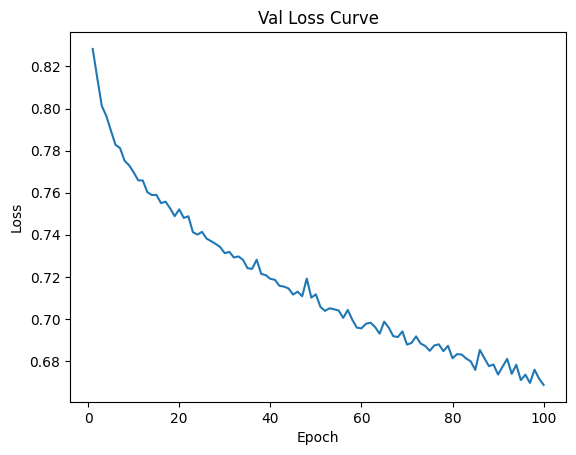

Finished Training Student for lambda value of 0
Student model CustomMediumCNN saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/CustomMediumCNN_lambda0_20231207_053525.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/CustomMediumCNN_weights_lambda0_20231207_053525.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 1/100*****
*****Train Loss:  1.233726 Val Loss:  0.784630*****
*****Validation Accuracy: 23.41%*****
*****Total Avg Disparity: 0.034119622593351766*****

Class Team_Sports: Recall Difference = 0.008591241959991391
Class Celebration: Recall Difference = -0.005
Class Parade: Recall Difference = -0.07386363636363635
Class Waiter_Or_Waitress: Recall Difference = -0.020618556701030927
Class Individual_Sports: Recall Difference = 0.07915886392009991
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.011976047904191617
Class Water_Activities: Recall Difference = -0.043751330636576546
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.030705892443605776
Class Family: Recall Difference = 0.033411033411033415
Data ha

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 2/100*****
*****Train Loss:  1.174914 Val Loss:  0.768349*****
*****Validation Accuracy: 24.94%*****
*****Total Avg Disparity: 0.034358867147869905*****

Class Team_Sports: Recall Difference = -0.004375592647176574
Class Celebration: Recall Difference = 0.0041089108910891126
Class Parade: Recall Difference = -0.09374999999999994
Class Waiter_Or_Waitress: Recall Difference = -0.09087437953417335
Class Individual_Sports: Recall Difference = 0.061797752808988804
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = -0.016666666666666663
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.029940119760479045
Class Water_Activities: Recall Difference = -0.0021290185224611263
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.025645424135860715
Class Fam

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 3/100*****
*****Train Loss:  1.151936 Val Loss:  0.771037*****
*****Validation Accuracy: 25.83%*****
*****Total Avg Disparity: 0.04343392144418254*****

Class Team_Sports: Recall Difference = 0.0402600221635766
Class Celebration: Recall Difference = -0.0008910891089108919
Class Parade: Recall Difference = -0.036931818181818205
Class Waiter_Or_Waitress: Recall Difference = -0.05803741886216118
Class Individual_Sports: Recall Difference = 0.11875780274656683
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.007042253521126761
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.07085828343313373
Class Water_Activities: Recall Difference = -0.010325739833936573
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.036280984647053774
Class Family: R

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 4/100*****
*****Train Loss:  1.131569 Val Loss:  0.749248*****
*****Validation Accuracy: 26.32%*****
*****Total Avg Disparity: 0.07141699005060023*****

Class Team_Sports: Recall Difference = 0.032628440209754195
Class Celebration: Recall Difference = -0.009999999999999998
Class Parade: Recall Difference = -0.0757575757575758
Class Waiter_Or_Waitress: Recall Difference = -0.010309278350515464
Class Individual_Sports: Recall Difference = 0.11485642946317104
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.11314553990610329
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.10678642714570857
Class Water_Activities: Recall Difference = -0.06174153715137326
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.017840295051033545
Class Family: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 5/100*****
*****Train Loss:  1.116818 Val Loss:  0.726743*****
*****Validation Accuracy: 28.63%*****
*****Total Avg Disparity: 0.07008258148744359*****

Class Team_Sports: Recall Difference = 0.02775016851172729
Class Celebration: Recall Difference = -0.0755940594059406
Class Parade: Recall Difference = -0.05397727272727271
Class Waiter_Or_Waitress: Recall Difference = -0.12180221458571974
Class Individual_Sports: Recall Difference = 0.04666042446941332
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.1572769953051643
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.023952095808383235
Class Water_Activities: Recall Difference = -0.12199276133702358
Class Picnic: Recall Difference = 0.1241830065359477
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.014666781027532383
Clas

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 6/100*****
*****Train Loss:  1.101210 Val Loss:  0.713185*****
*****Validation Accuracy: 30.76%*****
*****Total Avg Disparity: 0.06335248068368372*****

Class Team_Sports: Recall Difference = 0.03084621448401137
Class Celebration: Recall Difference = -0.09148514851485148
Class Parade: Recall Difference = -0.004734848484848453
Class Waiter_Or_Waitress: Recall Difference = -0.08476517754868272
Class Individual_Sports: Recall Difference = 0.0021457553058676915
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.06690140845070425
Class Business: Recall Difference = -0.0008516980730331088
Class Dresses: Recall Difference = -0.05389221556886228
Class Water_Activities: Recall Difference = -0.11986374281456252
Class Picnic: Recall Difference = 0.1633986928104575
Class Rescue: Recall Difference = -0.022727272727272728
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 7/100*****
*****Train Loss:  1.089017 Val Loss:  0.705596*****
*****Validation Accuracy: 31.08%*****
*****Total Avg Disparity: 0.06646092232758757*****

Class Team_Sports: Recall Difference = 0.07957180884486637
Class Celebration: Recall Difference = -0.031485148514851485
Class Parade: Recall Difference = -0.05018939393939395
Class Waiter_Or_Waitress: Recall Difference = -0.05383734249713633
Class Individual_Sports: Recall Difference = 0.020326154806491803
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.06361502347417847
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.03493013972055889
Class Water_Activities: Recall Difference = -0.1526506280604642
Class Picnic: Recall Difference = -0.0196078431372549
Class Rescue: Recall Difference = -0.010962566844919787
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.02984

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 8/100*****
*****Train Loss:  1.075881 Val Loss:  0.696874*****
*****Validation Accuracy: 31.34%*****
*****Total Avg Disparity: 0.06171191624590433*****

Class Team_Sports: Recall Difference = 0.033188241880019564
Class Celebration: Recall Difference = -0.02207920792079207
Class Parade: Recall Difference = 0.10132575757575757
Class Waiter_Or_Waitress: Recall Difference = -0.09927453226422298
Class Individual_Sports: Recall Difference = 0.03218632958801493
Class Surgeons: Recall Difference = 0.024390243902439025
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.07863849765258213
Class Business: Recall Difference = -0.001703396146066221
Class Dresses: Recall Difference = -0.08383233532934131
Class Water_Activities: Recall Difference = -0.13966361507345126
Class Picnic: Recall Difference = 0.04575163398692808
Class Rescue: Recall Difference = -0.010962566844919783
Class Cheering: Recall Difference = 0.028846153846153844
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 9/100*****
*****Train Loss:  1.068168 Val Loss:  0.700603*****
*****Validation Accuracy: 31.72%*****
*****Total Avg Disparity: 0.07730652632254553*****

Class Team_Sports: Recall Difference = 0.05827649632701548
Class Celebration: Recall Difference = -0.136980198019802
Class Parade: Recall Difference = 0.03409090909090906
Class Waiter_Or_Waitress: Recall Difference = 0.030546009927453238
Class Individual_Sports: Recall Difference = -0.025007802746566776
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.164319248826291
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.059880239520958084
Class Water_Activities: Recall Difference = -0.10208643815201185
Class Picnic: Recall Difference = -0.06535947712418302
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.047945792949652635
Clas

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 10/100*****
*****Train Loss:  1.057928 Val Loss:  0.685295*****
*****Validation Accuracy: 32.24%*****
*****Total Avg Disparity: 0.07273186835177319*****

Class Team_Sports: Recall Difference = 0.03582730689698499
Class Celebration: Recall Difference = -0.030990099009900962
Class Parade: Recall Difference = -0.012310606060606077
Class Waiter_Or_Waitress: Recall Difference = -0.056128293241695326
Class Individual_Sports: Recall Difference = 0.07525749063670417
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.08075117370892015
Class Business: Recall Difference = -0.03481315873522836
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.1246540344901001
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0020458265139116187
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 11/100*****
*****Train Loss:  1.050114 Val Loss:  0.683622*****
*****Validation Accuracy: 32.78%*****
*****Total Avg Disparity: 0.08198239646068096*****

Class Team_Sports: Recall Difference = 0.011881504838285761
Class Celebration: Recall Difference = -0.006881188118811915
Class Parade: Recall Difference = 0.03693181818181812
Class Waiter_Or_Waitress: Recall Difference = -0.13669339442535317
Class Individual_Sports: Recall Difference = 0.042563982521847676
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.37499999999999994
Class Law_Enforcement: Recall Difference = 0.052347417840375554
Class Business: Recall Difference = -0.023208772490152237
Class Dresses: Recall Difference = -0.1437125748502994
Class Water_Activities: Recall Difference = -0.02565467319565673
Class Picnic: Recall Difference = -0.08496732026143791
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 12/100*****
*****Train Loss:  1.044488 Val Loss:  0.674757*****
*****Validation Accuracy: 34.83%*****
*****Total Avg Disparity: 0.06820164800467633*****

Class Team_Sports: Recall Difference = 0.05119329151957597
Class Celebration: Recall Difference = -0.0873762376237624
Class Parade: Recall Difference = -0.0511363636363637
Class Waiter_Or_Waitress: Recall Difference = -0.0893470790378007
Class Individual_Sports: Recall Difference = -0.026685393258427004
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.13145539906103287
Class Business: Recall Difference = -0.0877249015224103
Class Dresses: Recall Difference = -0.09580838323353294
Class Water_Activities: Recall Difference = -0.0038322333404300357
Class Picnic: Recall Difference = -0.08496732026143791
Class Rescue: Recall Difference = -0.04545454545454545
Class Cheering: Recall Difference = -0.010638297872340425
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 13/100*****
*****Train Loss:  1.037891 Val Loss:  0.667570*****
*****Validation Accuracy: 34.29%*****
*****Total Avg Disparity: 0.08601420359033067*****

Class Team_Sports: Recall Difference = 0.006797591710365425
Class Celebration: Recall Difference = -0.06549504950495047
Class Parade: Recall Difference = -0.048295454545454475
Class Waiter_Or_Waitress: Recall Difference = -0.0893470790378007
Class Individual_Sports: Recall Difference = 0.067064606741573
Class Surgeons: Recall Difference = 0.042867701404286786
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.18286384976525816
Class Business: Recall Difference = -0.10614287235175134
Class Dresses: Recall Difference = -0.17964071856287425
Class Water_Activities: Recall Difference = -0.09122844368746008
Class Picnic: Recall Difference = 0.08496732026143791
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.01370703764320786
Class Performance_And_Entertain

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 14/100*****
*****Train Loss:  1.030659 Val Loss:  0.683450*****
*****Validation Accuracy: 33.04%*****
*****Total Avg Disparity: 0.0701711185306225*****

Class Team_Sports: Recall Difference = 0.017422398921524973
Class Celebration: Recall Difference = -0.08118811881188116
Class Parade: Recall Difference = -0.025568181818181823
Class Waiter_Or_Waitress: Recall Difference = -0.15120274914089343
Class Individual_Sports: Recall Difference = 0.010923845193508142
Class Surgeons: Recall Difference = 0.018477457501847747
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.11596244131455402
Class Business: Recall Difference = -0.03225806451612903
Class Dresses: Recall Difference = -0.1497005988023952
Class Water_Activities: Recall Difference = -0.14243133915265055
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0008021390374331541
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 15/100*****
*****Train Loss:  1.025869 Val Loss:  0.661443*****
*****Validation Accuracy: 34.17%*****
*****Total Avg Disparity: 0.08326350517426147*****

Class Team_Sports: Recall Difference = 0.14297791639533425
Class Celebration: Recall Difference = -0.032871287128712845
Class Parade: Recall Difference = -0.012310606060606133
Class Waiter_Or_Waitress: Recall Difference = -0.04429171439480728
Class Individual_Sports: Recall Difference = 0.006437265917602852
Class Surgeons: Recall Difference = 0.055432372505543226
Class Spa: Recall Difference = -0.3541666666666667
Class Law_Enforcement: Recall Difference = 0.12957746478873233
Class Business: Recall Difference = -0.01586287661024166
Class Dresses: Recall Difference = -0.10179640718562874
Class Water_Activities: Recall Difference = -0.11645731317862473
Class Picnic: Recall Difference = 0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 16/100*****
*****Train Loss:  1.020285 Val Loss:  0.658340*****
*****Validation Accuracy: 34.86%*****
*****Total Avg Disparity: 0.08402430398801843*****

Class Team_Sports: Recall Difference = 0.11998034981892136
Class Celebration: Recall Difference = -0.07386138613861382
Class Parade: Recall Difference = -0.037878787878787845
Class Waiter_Or_Waitress: Recall Difference = -0.12638411607483763
Class Individual_Sports: Recall Difference = 0.012133270911360738
Class Surgeons: Recall Difference = -0.01773835920177383
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.1558685446009389
Class Business: Recall Difference = -0.03396146066219526
Class Dresses: Recall Difference = -0.3293413173652695
Class Water_Activities: Recall Difference = 0.02427081115605695
Class Picnic: Recall Difference = 0.026143790849673193
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.001022913256955811
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 17/100*****
*****Train Loss:  1.014706 Val Loss:  0.658823*****
*****Validation Accuracy: 35.04%*****
*****Total Avg Disparity: 0.07207309808178827*****

Class Team_Sports: Recall Difference = 0.007997166718076931
Class Celebration: Recall Difference = -0.06178217821782178
Class Parade: Recall Difference = -0.03977272727272724
Class Waiter_Or_Waitress: Recall Difference = -0.12447499045437194
Class Individual_Sports: Recall Difference = -0.011743133583021148
Class Surgeons: Recall Difference = -0.036215816703621576
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.12394366197183099
Class Business: Recall Difference = -0.06962631747045672
Class Dresses: Recall Difference = -0.18562874251497005
Class Water_Activities: Recall Difference = -0.06312539919097299
Class Picnic: Recall Difference = 0.08496732026143791
Class Rescue: Recall Difference = -0.010962566844919787
Class Cheering: Recall Difference = -0.011661211129296235
Class P

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 18/100*****
*****Train Loss:  1.011732 Val Loss:  0.650125*****
*****Validation Accuracy: 36.02%*****
*****Total Avg Disparity: 0.08330061377125715*****

Class Team_Sports: Recall Difference = 0.07887491288800541
Class Celebration: Recall Difference = -0.07628712871287127
Class Parade: Recall Difference = -0.015151515151515194
Class Waiter_Or_Waitress: Recall Difference = -0.1450935471554028
Class Individual_Sports: Recall Difference = -0.05668695380774025
Class Surgeons: Recall Difference = 0.031042128603104235
Class Spa: Recall Difference = -0.3333333333333333
Class Law_Enforcement: Recall Difference = 0.08145539906103277
Class Business: Recall Difference = -0.002874480996486767
Class Dresses: Recall Difference = -0.16766467065868262
Class Water_Activities: Recall Difference = -0.06866084734937195
Class Picnic: Recall Difference = -0.04575163398692811
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = 0.018207855973813414
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 19/100*****
*****Train Loss:  1.002728 Val Loss:  0.657510*****
*****Validation Accuracy: 34.81%*****
*****Total Avg Disparity: 0.07195907777238043*****

Class Team_Sports: Recall Difference = 0.06755320971998502
Class Celebration: Recall Difference = -0.027178217821782202
Class Parade: Recall Difference = 0.03693181818181818
Class Waiter_Or_Waitress: Recall Difference = 0.022145857197403557
Class Individual_Sports: Recall Difference = 0.019897003745318387
Class Surgeons: Recall Difference = 0.03769401330376945
Class Spa: Recall Difference = -0.125
Class Law_Enforcement: Recall Difference = 0.18474178403755864
Class Business: Recall Difference = 0.018950282124986693
Class Dresses: Recall Difference = -0.3532934131736527
Class Water_Activities: Recall Difference = 0.001064509261230695
Class Picnic: Recall Difference = -0.006535947712418305
Class Rescue: Recall Difference = 0.013368983957219263
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 20/100*****
*****Train Loss:  1.000012 Val Loss:  0.654611*****
*****Validation Accuracy: 35.47%*****
*****Total Avg Disparity: 0.06735260435708493*****

Class Team_Sports: Recall Difference = 0.07299128308827729
Class Celebration: Recall Difference = -0.0816831683168317
Class Parade: Recall Difference = -0.06439393939393956
Class Waiter_Or_Waitress: Recall Difference = -0.08743795341733485
Class Individual_Sports: Recall Difference = 0.0049937578027466345
Class Surgeons: Recall Difference = 0.04286770140428678
Class Spa: Recall Difference = -0.10416666666666666
Class Law_Enforcement: Recall Difference = 0.13544600938967133
Class Business: Recall Difference = -0.048972639199403825
Class Dresses: Recall Difference = -0.19161676646706588
Class Water_Activities: Recall Difference = -0.05567383436235901
Class Picnic: Recall Difference = -0.01307189542483661
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.017184942716857613
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 21/100*****
*****Train Loss:  0.995199 Val Loss:  0.642640*****
*****Validation Accuracy: 36.33%*****
*****Total Avg Disparity: 0.08734508552220993*****

Class Team_Sports: Recall Difference = 0.08131976099896032
Class Celebration: Recall Difference = -0.0274752475247525
Class Parade: Recall Difference = 5.551115123125783e-17
Class Waiter_Or_Waitress: Recall Difference = -0.01947308132875153
Class Individual_Sports: Recall Difference = 0.011118913857677937
Class Surgeons: Recall Difference = -0.03621581670362159
Class Spa: Recall Difference = -0.4166666666666667
Class Law_Enforcement: Recall Difference = 0.08544600938967145
Class Business: Recall Difference = -0.035664856808261466
Class Dresses: Recall Difference = -0.4191616766467066
Class Water_Activities: Recall Difference = -0.1090057483500107
Class Picnic: Recall Difference = 0.039215686274509776
Class Rescue: Recall Difference = 0.011764705882352943
Class Cheering: Recall Difference = -0.0020458265139116187
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 22/100*****
*****Train Loss:  0.989355 Val Loss:  0.641270*****
*****Validation Accuracy: 35.67%*****
*****Total Avg Disparity: 0.0796245035543404*****

Class Team_Sports: Recall Difference = 0.1198318310084428
Class Celebration: Recall Difference = -0.03767326732673265
Class Parade: Recall Difference = -0.012310606060606077
Class Waiter_Or_Waitress: Recall Difference = 0.03016418480336014
Class Individual_Sports: Recall Difference = -0.01970193508114859
Class Surgeons: Recall Difference = -0.03621581670362158
Class Spa: Recall Difference = -0.20833333333333331
Class Law_Enforcement: Recall Difference = 0.1051643192488263
Class Business: Recall Difference = -0.04641754498030448
Class Dresses: Recall Difference = -0.33532934131736525
Class Water_Activities: Recall Difference = -0.04332552693208436
Class Picnic: Recall Difference = 0.08496732026143791
Class Rescue: Recall Difference = 0.013368983957219263
Class Cheering: Recall Difference = 0.00756955810147299
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 23/100*****
*****Train Loss:  0.982867 Val Loss:  0.642331*****
*****Validation Accuracy: 36.42%*****
*****Total Avg Disparity: 0.09631796092949095*****

Class Team_Sports: Recall Difference = 0.12242519792987622
Class Celebration: Recall Difference = -0.05257425742574251
Class Parade: Recall Difference = -0.010416666666666574
Class Waiter_Or_Waitress: Recall Difference = -0.12256586483390614
Class Individual_Sports: Recall Difference = 0.04053526841448185
Class Surgeons: Recall Difference = 0.0007390983000739038
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.1518779342723004
Class Business: Recall Difference = 0.0061748110294900516
Class Dresses: Recall Difference = -0.47904191616766467
Class Water_Activities: Recall Difference = -0.07345113902490957
Class Picnic: Recall Difference = -0.039215686274509796
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = -0.022299509001636658
Class P

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 24/100*****
*****Train Loss:  0.985382 Val Loss:  0.639172*****
*****Validation Accuracy: 36.59%*****
*****Total Avg Disparity: 0.071561193568553*****

Class Team_Sports: Recall Difference = 0.07194022689104418
Class Celebration: Recall Difference = -0.06168316831683168
Class Parade: Recall Difference = -0.09280303030303039
Class Waiter_Or_Waitress: Recall Difference = -0.046200840015273026
Class Individual_Sports: Recall Difference = -0.01767322097378271
Class Surgeons: Recall Difference = -0.017738359201773843
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.1389671361502347
Class Business: Recall Difference = -0.04247844139252634
Class Dresses: Recall Difference = -0.16167664670658682
Class Water_Activities: Recall Difference = -0.039919097296146566
Class Picnic: Recall Difference = -0.058823529411764705
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = 0.0055237315875613716
Class Per

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 25/100*****
*****Train Loss:  0.977735 Val Loss:  0.643982*****
*****Validation Accuracy: 37.14%*****
*****Total Avg Disparity: 0.0748082903270823*****

Class Team_Sports: Recall Difference = 0.009288137916852235
Class Celebration: Recall Difference = -0.045891089108910904
Class Parade: Recall Difference = -0.045454545454545414
Class Waiter_Or_Waitress: Recall Difference = -0.06261932035127915
Class Individual_Sports: Recall Difference = 0.05013264669163542
Class Surgeons: Recall Difference = 0.031042128603104208
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.165962441314554
Class Business: Recall Difference = -0.10273608005961889
Class Dresses: Recall Difference = -0.2874251497005988
Class Water_Activities: Recall Difference = -0.039919097296146344
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = 0.01820785597381342
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 26/100*****
*****Train Loss:  0.970646 Val Loss:  0.636690*****
*****Validation Accuracy: 37.06%*****
*****Total Avg Disparity: 0.07633031519404991*****

Class Team_Sports: Recall Difference = 0.07992596908523841
Class Celebration: Recall Difference = -0.07737623762376239
Class Parade: Recall Difference = 0.0037878787878788955
Class Waiter_Or_Waitress: Recall Difference = -0.13058419243986258
Class Individual_Sports: Recall Difference = 0.0342150436953807
Class Surgeons: Recall Difference = 0.04951958610495197
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.10845070422535213
Class Business: Recall Difference = -0.05131480890024487
Class Dresses: Recall Difference = -0.18562874251497002
Class Water_Activities: Recall Difference = -0.0433255269320843
Class Picnic: Recall Difference = 0.006535947712418277
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.02536824877250409
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 27/100*****
*****Train Loss:  0.970822 Val Loss:  0.629657*****
*****Validation Accuracy: 37.66%*****
*****Total Avg Disparity: 0.08785777010265333*****

Class Team_Sports: Recall Difference = 0.05682558179387864
Class Celebration: Recall Difference = -0.021386138613861405
Class Parade: Recall Difference = -0.05397727272727271
Class Waiter_Or_Waitress: Recall Difference = -0.09774723176785033
Class Individual_Sports: Recall Difference = 0.015020287141073618
Class Surgeons: Recall Difference = 0.04951958610495194
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.10586854460093886
Class Business: Recall Difference = 0.008729905248589381
Class Dresses: Recall Difference = -0.44311377245508987
Class Water_Activities: Recall Difference = 0.015435384287843246
Class Picnic: Recall Difference = -0.04575163398692811
Class Rescue: Recall Difference = 0.047058823529411764
Class Cheering: Recall Difference = 0.01411620294599017
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 28/100*****
*****Train Loss:  0.965464 Val Loss:  0.642765*****
*****Validation Accuracy: 36.28%*****
*****Total Avg Disparity: 0.07246898765639648*****

Class Team_Sports: Recall Difference = 0.011881504838285761
Class Celebration: Recall Difference = 0.018613861386138603
Class Parade: Recall Difference = -0.06060606060606066
Class Waiter_Or_Waitress: Recall Difference = -0.00496372661321115
Class Individual_Sports: Recall Difference = -0.02239388264669162
Class Surgeons: Recall Difference = 0.0376940133037694
Class Spa: Recall Difference = -0.31249999999999994
Class Law_Enforcement: Recall Difference = 0.08356807511737091
Class Business: Recall Difference = -0.0877249015224103
Class Dresses: Recall Difference = -0.22754491017964074
Class Water_Activities: Recall Difference = -0.018735362997658156
Class Picnic: Recall Difference = 0.09150326797385616
Class Rescue: Recall Difference = 0.02513368983957219
Class Cheering: Recall Difference = -0.0036824877250409283
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 29/100*****
*****Train Loss:  0.962363 Val Loss:  0.629382*****
*****Validation Accuracy: 37.52%*****
*****Total Avg Disparity: 0.08688735079360076*****

Class Team_Sports: Recall Difference = 0.09982748968936728
Class Celebration: Recall Difference = -0.0332673267326733
Class Parade: Recall Difference = -0.015151515151515138
Class Waiter_Or_Waitress: Recall Difference = -0.1183657884688813
Class Individual_Sports: Recall Difference = -0.07506242197253427
Class Surgeons: Recall Difference = -0.017738359201773843
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.17816901408450697
Class Business: Recall Difference = -0.03736825295432769
Class Dresses: Recall Difference = -0.22754491017964074
Class Water_Activities: Recall Difference = -0.04747711305088348
Class Picnic: Recall Difference = -0.07189542483660133
Class Rescue: Recall Difference = -0.044652406417112295
Class Cheering: Recall Difference = -0.0020458265139116187
Class Per

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 30/100*****
*****Train Loss:  0.958954 Val Loss:  0.619480*****
*****Validation Accuracy: 38.41%*****
*****Total Avg Disparity: 0.09880251464248713*****

Class Team_Sports: Recall Difference = 0.07543613119923231
Class Celebration: Recall Difference = -0.10267326732673265
Class Parade: Recall Difference = -0.035037878787878896
Class Waiter_Or_Waitress: Recall Difference = -0.1267659411989308
Class Individual_Sports: Recall Difference = 0.009090199750312111
Class Surgeons: Recall Difference = 0.03104212860310422
Class Spa: Recall Difference = -0.31249999999999994
Class Law_Enforcement: Recall Difference = 0.15140845070422532
Class Business: Recall Difference = 0.02033429149366546
Class Dresses: Recall Difference = -0.31137724550898205
Class Water_Activities: Recall Difference = -0.07685756866084742
Class Picnic: Recall Difference = 0.15032679738562088
Class Rescue: Recall Difference = 0.024331550802139036
Class Cheering: Recall Difference = -0.012684124386252042
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 31/100*****
*****Train Loss:  0.953325 Val Loss:  0.621499*****
*****Validation Accuracy: 38.85%*****
*****Total Avg Disparity: 0.08460193961426082*****

Class Team_Sports: Recall Difference = 0.06156675920531007
Class Celebration: Recall Difference = -0.06128712871287126
Class Parade: Recall Difference = -0.048295454545454475
Class Waiter_Or_Waitress: Recall Difference = -0.10194730813287517
Class Individual_Sports: Recall Difference = 0.0019506866416978408
Class Surgeons: Recall Difference = 0.031042128603104235
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.1518779342723004
Class Business: Recall Difference = -0.014478867241562887
Class Dresses: Recall Difference = -0.25748502994011974
Class Water_Activities: Recall Difference = -0.04811581860762182
Class Picnic: Recall Difference = 0.04575163398692808
Class Rescue: Recall Difference = 0.03529411764705882
Class Cheering: Recall Difference = -0.007160392798690671
Class Perf

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 32/100*****
*****Train Loss:  0.949461 Val Loss:  0.622527*****
*****Validation Accuracy: 39.08%*****
*****Total Avg Disparity: 0.07844934310567667*****

Class Team_Sports: Recall Difference = 0.09299562440735287
Class Celebration: Recall Difference = 0.0060396039603959895
Class Parade: Recall Difference = -0.028409090909090717
Class Waiter_Or_Waitress: Recall Difference = -0.10614738449790001
Class Individual_Sports: Recall Difference = 0.0015215355805244246
Class Surgeons: Recall Difference = -0.023651145602365087
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.1462441314553991
Class Business: Recall Difference = -0.05834131800276804
Class Dresses: Recall Difference = -0.281437125748503
Class Water_Activities: Recall Difference = -0.06046412603789658
Class Picnic: Recall Difference = -0.019607843137254943
Class Rescue: Recall Difference = 0.0008021390374331541
Class Cheering: Recall Difference = 0.006546644844517183
Class Pe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 33/100*****
*****Train Loss:  0.946326 Val Loss:  0.627448*****
*****Validation Accuracy: 37.84%*****
*****Total Avg Disparity: 0.08217582482219807*****

Class Team_Sports: Recall Difference = 0.036272863328420835
Class Celebration: Recall Difference = -0.031485148514851485
Class Parade: Recall Difference = -0.048295454545454586
Class Waiter_Or_Waitress: Recall Difference = -0.12867506681939672
Class Individual_Sports: Recall Difference = 0.04299313358302126
Class Surgeons: Recall Difference = 0.0672579453067258
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.14812206572769943
Class Business: Recall Difference = -0.007132971361652307
Class Dresses: Recall Difference = -0.2095808383233533
Class Water_Activities: Recall Difference = -0.011922503725782463
Class Picnic: Recall Difference = -0.052287581699346386
Class Rescue: Recall Difference = 0.035294117647058816
Class Cheering: Recall Difference = 0.030278232405891975
Class Performance_And_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 34/100*****
*****Train Loss:  0.944058 Val Loss:  0.609194*****
*****Validation Accuracy: 38.99%*****
*****Total Avg Disparity: 0.11161253533667523*****

Class Team_Sports: Recall Difference = 0.13159909060789887
Class Celebration: Recall Difference = -0.05237623762376237
Class Parade: Recall Difference = 0.005681818181818232
Class Waiter_Or_Waitress: Recall Difference = -0.1328751431844215
Class Individual_Sports: Recall Difference = 0.001326466916354574
Class Surgeons: Recall Difference = 0.06208425720620847
Class Spa: Recall Difference = -0.35416666666666663
Class Law_Enforcement: Recall Difference = 0.1718309859154929
Class Business: Recall Difference = -0.03002235707441711
Class Dresses: Recall Difference = -0.37125748502994005
Class Water_Activities: Recall Difference = -0.039919097296146566
Class Picnic: Recall Difference = -0.08496732026143791
Class Rescue: Recall Difference = -0.010962566844919785
Class Cheering: Recall Difference = 0.0398936170212766
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 35/100*****
*****Train Loss:  0.936995 Val Loss:  0.621407*****
*****Validation Accuracy: 39.34%*****
*****Total Avg Disparity: 0.08550268355665865*****

Class Team_Sports: Recall Difference = 0.04076270121442682
Class Celebration: Recall Difference = -0.06306930693069313
Class Parade: Recall Difference = -0.02367424242424243
Class Waiter_Or_Waitress: Recall Difference = -0.009163802978235991
Class Individual_Sports: Recall Difference = -0.028519038701622923
Class Surgeons: Recall Difference = -0.059866962305986704
Class Spa: Recall Difference = -0.24999999999999997
Class Law_Enforcement: Recall Difference = 0.2544600938967136
Class Business: Recall Difference = -0.1052911742787182
Class Dresses: Recall Difference = -0.34131736526946105
Class Water_Activities: Recall Difference = -0.011922503725782463
Class Picnic: Recall Difference = 0.019607843137254888
Class Rescue: Recall Difference = 0.03529411764705883
Class Cheering: Recall Difference = -0.014729950900163678
Class Per

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 36/100*****
*****Train Loss:  0.934352 Val Loss:  0.623404*****
*****Validation Accuracy: 38.24%*****
*****Total Avg Disparity: 0.09027542469662124*****

Class Team_Sports: Recall Difference = 0.05747677965520792
Class Celebration: Recall Difference = -0.041386138613861395
Class Parade: Recall Difference = -0.05208333333333337
Class Waiter_Or_Waitress: Recall Difference = -0.09774723176785033
Class Individual_Sports: Recall Difference = 0.016853932584269593
Class Surgeons: Recall Difference = -0.011086474501108667
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.15328638497652586
Class Business: Recall Difference = -0.016182263387629098
Class Dresses: Recall Difference = -0.38922155688622756
Class Water_Activities: Recall Difference = -0.0050031935277836115
Class Picnic: Recall Difference = -0.04575163398692811
Class Rescue: Recall Difference = 0.047860962566844925
Class Cheering: Recall Difference = -0.04418985270049103
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 37/100*****
*****Train Loss:  0.931053 Val Loss:  0.639269*****
*****Validation Accuracy: 37.89%*****
*****Total Avg Disparity: 0.08437931103182465*****

Class Team_Sports: Recall Difference = 0.05223292319292583
Class Celebration: Recall Difference = -0.0017821782178217838
Class Parade: Recall Difference = -0.03693181818181812
Class Waiter_Or_Waitress: Recall Difference = -0.06071019473081335
Class Individual_Sports: Recall Difference = -0.018297440699126144
Class Surgeons: Recall Difference = -0.01773835920177383
Class Spa: Recall Difference = -0.3541666666666667
Class Law_Enforcement: Recall Difference = 0.19295774647887326
Class Business: Recall Difference = -0.044714148834238264
Class Dresses: Recall Difference = -0.24550898203592816
Class Water_Activities: Recall Difference = -0.055673834362358954
Class Picnic: Recall Difference = -0.10457516339869283
Class Rescue: Recall Difference = 0.03529411764705882
Class Cheering: Recall Difference = -0.01636661211129295
Class Pe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 38/100*****
*****Train Loss:  0.931105 Val Loss:  0.628127*****
*****Validation Accuracy: 38.93%*****
*****Total Avg Disparity: 0.09974361507599822*****

Class Team_Sports: Recall Difference = 0.051490329140532975
Class Celebration: Recall Difference = -0.056980198019802
Class Parade: Recall Difference = -0.0445075757575758
Class Waiter_Or_Waitress: Recall Difference = -0.10194730813287517
Class Individual_Sports: Recall Difference = -0.061173533083645426
Class Surgeons: Recall Difference = -0.03547671840354766
Class Spa: Recall Difference = -0.3333333333333333
Class Law_Enforcement: Recall Difference = 0.13286384976525817
Class Business: Recall Difference = -0.007665282657297975
Class Dresses: Recall Difference = -0.5209580838323353
Class Water_Activities: Recall Difference = -0.0494996806472216
Class Picnic: Recall Difference = -0.026143790849673193
Class Rescue: Recall Difference = 0.03529411764705882
Class Cheering: Recall Difference = -0.00306873977086743
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 39/100*****
*****Train Loss:  0.923963 Val Loss:  0.611950*****
*****Validation Accuracy: 40.35%*****
*****Total Avg Disparity: 0.11721241048617612*****

Class Team_Sports: Recall Difference = 0.07448789571694614
Class Celebration: Recall Difference = -0.0326732673267327
Class Parade: Recall Difference = -0.019886363636363646
Class Waiter_Or_Waitress: Recall Difference = -0.05231004200076367
Class Individual_Sports: Recall Difference = -0.009909488139825229
Class Surgeons: Recall Difference = 0.0679970436067997
Class Spa: Recall Difference = -0.3958333333333333
Class Law_Enforcement: Recall Difference = 0.23262910798122055
Class Business: Recall Difference = -0.09539018417970829
Class Dresses: Recall Difference = -0.5269461077844311
Class Water_Activities: Recall Difference = -0.07685756866084742
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.012566844919786095
Class Cheering: Recall Difference = 0.01411620294599017
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 40/100*****
*****Train Loss:  0.925061 Val Loss:  0.603975*****
*****Validation Accuracy: 40.66%*****
*****Total Avg Disparity: 0.10115364472077232*****

Class Team_Sports: Recall Difference = 0.07897773360295213
Class Celebration: Recall Difference = -0.04688118811881181
Class Parade: Recall Difference = 0.0028409090909090606
Class Waiter_Or_Waitress: Recall Difference = -0.10194730813287517
Class Individual_Sports: Recall Difference = -0.045450998751560445
Class Surgeons: Recall Difference = -0.005173688100517382
Class Spa: Recall Difference = -0.39583333333333337
Class Law_Enforcement: Recall Difference = 0.21408450704225357
Class Business: Recall Difference = -0.03151282870222505
Class Dresses: Recall Difference = -0.4251497005988024
Class Water_Activities: Recall Difference = -0.0044709388971683195
Class Picnic: Recall Difference = -0.052287581699346386
Class Rescue: Recall Difference = -0.010160427807486626
Class Cheering: Recall Difference = 0.03641571194762684
Class 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 41/100*****
*****Train Loss:  0.916392 Val Loss:  0.608204*****
*****Validation Accuracy: 39.48%*****
*****Total Avg Disparity: 0.09345714940486721*****

Class Team_Sports: Recall Difference = 0.07708126263837956
Class Celebration: Recall Difference = 0.022425742574257473
Class Parade: Recall Difference = -0.01799242424242431
Class Waiter_Or_Waitress: Recall Difference = -0.10194730813287511
Class Individual_Sports: Recall Difference = -0.040340199750312056
Class Surgeons: Recall Difference = 0.0007390983000739038
Class Spa: Recall Difference = -0.2916666666666667
Class Law_Enforcement: Recall Difference = 0.1711267605633804
Class Business: Recall Difference = -0.010220376876397305
Class Dresses: Recall Difference = -0.32335329341317365
Class Water_Activities: Recall Difference = -0.04886097509048326
Class Picnic: Recall Difference = -0.052287581699346386
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = 0.002454991816693966
Class Pe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 42/100*****
*****Train Loss:  0.915280 Val Loss:  0.623578*****
*****Validation Accuracy: 39.28%*****
*****Total Avg Disparity: 0.1015557882386576*****

Class Team_Sports: Recall Difference = 0.11289714501148163
Class Celebration: Recall Difference = -0.02207920792079207
Class Parade: Recall Difference = 0.008522727272727237
Class Waiter_Or_Waitress: Recall Difference = -0.08514700267277586
Class Individual_Sports: Recall Difference = -0.06995162297128599
Class Surgeons: Recall Difference = 0.006651884700665189
Class Spa: Recall Difference = -0.39583333333333337
Class Law_Enforcement: Recall Difference = 0.2030516431924883
Class Business: Recall Difference = -0.09624188225274141
Class Dresses: Recall Difference = -0.29940119760479045
Class Water_Activities: Recall Difference = -0.029061102831594576
Class Picnic: Recall Difference = -0.1111111111111111
Class Rescue: Recall Difference = 0.0008021390374331576
Class Cheering: Recall Difference = -0.014729950900163678
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 43/100*****
*****Train Loss:  0.912934 Val Loss:  0.614046*****
*****Validation Accuracy: 39.05%*****
*****Total Avg Disparity: 0.11256349000725174*****

Class Team_Sports: Recall Difference = 0.07219156641646962
Class Celebration: Recall Difference = -0.015990099009900977
Class Parade: Recall Difference = 0.007575757575757569
Class Waiter_Or_Waitress: Recall Difference = -0.09774723176785027
Class Individual_Sports: Recall Difference = -0.05239544319600503
Class Surgeons: Recall Difference = 0.07390983000739101
Class Spa: Recall Difference = -0.41666666666666663
Class Law_Enforcement: Recall Difference = 0.18145539906103292
Class Business: Recall Difference = -0.06313211966357926
Class Dresses: Recall Difference = -0.39520958083832336
Class Water_Activities: Recall Difference = -0.05982542048115813
Class Picnic: Recall Difference = 0.09150326797385616
Class Rescue: Recall Difference = 0.025935828877005337
Class Cheering: Recall Difference = 0.03580196399345337
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 44/100*****
*****Train Loss:  0.911743 Val Loss:  0.613281*****
*****Validation Accuracy: 39.57%*****
*****Total Avg Disparity: 0.10424035767147784*****

Class Team_Sports: Recall Difference = 0.099176291828038
Class Celebration: Recall Difference = -0.03128712871287129
Class Parade: Recall Difference = -0.013257575757575801
Class Waiter_Or_Waitress: Recall Difference = -0.09774723176785027
Class Individual_Sports: Recall Difference = -0.07771535580524347
Class Surgeons: Recall Difference = 0.006651884700665203
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.2300469483568075
Class Business: Recall Difference = 0.038432875545619055
Class Dresses: Recall Difference = -0.39520958083832336
Class Water_Activities: Recall Difference = 0.005854800936768101
Class Picnic: Recall Difference = -0.10457516339869283
Class Rescue: Recall Difference = -0.021122994652406427
Class Cheering: Recall Difference = 0.012070376432078561
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 45/100*****
*****Train Loss:  0.904325 Val Loss:  0.617416*****
*****Validation Accuracy: 38.96%*****
*****Total Avg Disparity: 0.09967833609494317*****

Class Team_Sports: Recall Difference = 0.11629022860472288
Class Celebration: Recall Difference = -0.05648514851485148
Class Parade: Recall Difference = 0.0492424242424242
Class Waiter_Or_Waitress: Recall Difference = -0.1576937762504773
Class Individual_Sports: Recall Difference = -0.019506866416978685
Class Surgeons: Recall Difference = -0.10125646711012559
Class Spa: Recall Difference = -0.35416666666666663
Class Law_Enforcement: Recall Difference = 0.0995305164319249
Class Business: Recall Difference = 0.016288725646758206
Class Dresses: Recall Difference = -0.3413173652694611
Class Water_Activities: Recall Difference = -0.007877368533106166
Class Picnic: Recall Difference = -0.1437908496732026
Class Rescue: Recall Difference = 0.013368983957219263
Class Cheering: Recall Difference = -0.015343698854337173
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 46/100*****
*****Train Loss:  0.905364 Val Loss:  0.618564*****
*****Validation Accuracy: 39.65%*****
*****Total Avg Disparity: 0.08797922103936899*****

Class Team_Sports: Recall Difference = 0.08815162628097484
Class Celebration: Recall Difference = 0.018712871287128716
Class Parade: Recall Difference = 0.058712121212121215
Class Waiter_Or_Waitress: Recall Difference = -0.08743795341733485
Class Individual_Sports: Recall Difference = -0.07159019975031217
Class Surgeons: Recall Difference = 0.04286770140428678
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.09507042253521125
Class Business: Recall Difference = -0.07388480783562228
Class Dresses: Recall Difference = -0.3293413173652695
Class Water_Activities: Recall Difference = 0.029699808388333082
Class Picnic: Recall Difference = -0.006535947712418333
Class Rescue: Recall Difference = 0.02513368983957219
Class Cheering: Recall Difference = -0.005319148936170137
Class Performance_And_Ent

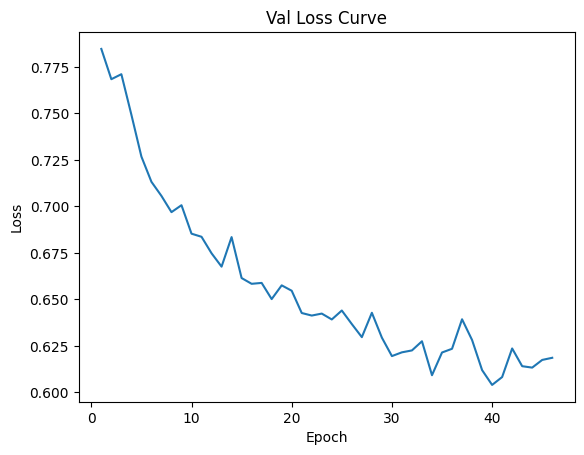

Finished Training Student for lambda value of 0
Student model CustomLargeCNN saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/CustomLargeCNN_lambda0_20231207_074258.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/CustomLargeCNN_weights_lambda0_20231207_074258.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 1/100*****
*****Train Loss:  1.247810 Val Loss:  0.897394*****
*****Validation Accuracy: 21.85%*****
*****Total Avg Disparity: 0.06257582678875122*****

Class Team_Sports: Recall Difference = 0.017719436542482203
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = -0.08049242424242425
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.1017868289637952
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = -0.06807511737089206
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.08982035928143713
Class Water_Activities: Recall Difference = -0.03779007877368534
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = -0.04234654234654236
Data has been appended to Smalle

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 2/100*****
*****Train Loss:  1.159915 Val Loss:  0.741308*****
*****Validation Accuracy: 26.98%*****
*****Total Avg Disparity: 0.08466455906631777*****

Class Team_Sports: Recall Difference = 0.014543418903017247
Class Celebration: Recall Difference = -0.0455940594059406
Class Parade: Recall Difference = -0.09280303030303039
Class Waiter_Or_Waitress: Recall Difference = -0.19587628865979378
Class Individual_Sports: Recall Difference = 0.0793539325842696
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.08802816901408445
Class Business: Recall Difference = -0.07612051527733418
Class Dresses: Recall Difference = -0.22255489021956096
Class Water_Activities: Recall Difference = -0.08228656589312333
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.001022913256955811
Class Performance_And_Entertainment: Recall Difference = 0.014838322326100009
Cla

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 3/100*****
*****Train Loss:  1.111872 Val Loss:  0.735303*****
*****Validation Accuracy: 28.46%*****
*****Total Avg Disparity: 0.07759596354971549*****

Class Team_Sports: Recall Difference = 0.09069929510687635
Class Celebration: Recall Difference = 0.023217821782178183
Class Parade: Recall Difference = 0.03693181818181818
Class Waiter_Or_Waitress: Recall Difference = 0.019473081328751363
Class Individual_Sports: Recall Difference = 0.047245630461922594
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.19765258215962447
Class Business: Recall Difference = -0.027467262855317795
Class Dresses: Recall Difference = 0.027944111776447067
Class Water_Activities: Recall Difference = 0.05716414732808178
Class Picnic: Recall Difference = -0.1568627450980392
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.040483

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 4/100*****
*****Train Loss:  1.068811 Val Loss:  0.699991*****
*****Validation Accuracy: 31.66%*****
*****Total Avg Disparity: 0.11486975372357314*****

Class Team_Sports: Recall Difference = 0.14312643520581292
Class Celebration: Recall Difference = -0.0014851485148514587
Class Parade: Recall Difference = 0.06628787878787873
Class Waiter_Or_Waitress: Recall Difference = -0.22107674684994277
Class Individual_Sports: Recall Difference = -0.0029650436953807535
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.193661971830986
Class Business: Recall Difference = -0.008516980730331095
Class Dresses: Recall Difference = -0.2105788423153693
Class Water_Activities: Recall Difference = -0.09804130295933572
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0894

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.65it/s]


*****Epoch 5/100*****
*****Train Loss:  1.042656 Val Loss:  0.703114*****
*****Validation Accuracy: 31.63%*****
*****Total Avg Disparity: 0.06763531879011311*****

Class Team_Sports: Recall Difference = 0.1417326432920908
Class Celebration: Recall Difference = 0.01381188118811881
Class Parade: Recall Difference = -0.013257575757575801
Class Waiter_Or_Waitress: Recall Difference = -0.08896525391370758
Class Individual_Sports: Recall Difference = -0.0979634831460674
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.10416666666666667
Class Law_Enforcement: Recall Difference = 0.13661971830985914
Class Business: Recall Difference = -0.022357074417119132
Class Dresses: Recall Difference = -0.186626746506986
Class Water_Activities: Recall Difference = -0.08388332978496926
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0008021390374331576
Class Cheering: Recall Difference = 0.009615384615384616
Class Performance_And_Entertainm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 6/100*****
*****Train Loss:  1.004184 Val Loss:  0.666468*****
*****Validation Accuracy: 34.57%*****
*****Total Avg Disparity: 0.12036717201383079*****

Class Team_Sports: Recall Difference = 0.12008317053386797
Class Celebration: Recall Difference = -0.021386138613861405
Class Parade: Recall Difference = 0.03693181818181812
Class Waiter_Or_Waitress: Recall Difference = -0.2562046582665139
Class Individual_Sports: Recall Difference = -0.000936329588014928
Class Surgeons: Recall Difference = -0.030303030303030304
Class Spa: Recall Difference = -0.41666666666666663
Class Law_Enforcement: Recall Difference = 0.15046948356807516
Class Business: Recall Difference = -0.13190673906100292
Class Dresses: Recall Difference = -0.43113772455089816
Class Water_Activities: Recall Difference = -0.0044709388971683195
Class Picnic: Recall Difference = -0.17647058823529413
Class Rescue: Recall Difference = 0.03529411764705882
Class Cheering: Recall Difference = -0.0020458265139116187
Class Pe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 7/100*****
*****Train Loss:  0.976503 Val Loss:  0.651803*****
*****Validation Accuracy: 36.02%*****
*****Total Avg Disparity: 0.13939244570690662*****

Class Team_Sports: Recall Difference = 0.13833955969884942
Class Celebration: Recall Difference = 0.05212871287128709
Class Parade: Recall Difference = -0.008522727272727293
Class Waiter_Or_Waitress: Recall Difference = -0.22909507445589916
Class Individual_Sports: Recall Difference = 0.009675405742821497
Class Surgeons: Recall Difference = -0.04804138950480415
Class Spa: Recall Difference = -0.31249999999999994
Class Law_Enforcement: Recall Difference = 0.14084507042253525
Class Business: Recall Difference = -0.14351112530607896
Class Dresses: Recall Difference = -0.4910179640718563
Class Water_Activities: Recall Difference = -0.04683840749414514
Class Picnic: Recall Difference = -0.3398692810457517
Class Rescue: Recall Difference = 0.013368983957219256
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertain

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.64it/s]


*****Epoch 8/100*****
*****Train Loss:  0.938346 Val Loss:  0.670620*****
*****Validation Accuracy: 35.18%*****
*****Total Avg Disparity: 0.09422212662981856*****

Class Team_Sports: Recall Difference = 0.09584033085421162
Class Celebration: Recall Difference = -0.006386138613861364
Class Parade: Recall Difference = -0.02178030303030315
Class Waiter_Or_Waitress: Recall Difference = -0.19816723940435277
Class Individual_Sports: Recall Difference = -0.07381398252184768
Class Surgeons: Recall Difference = 0.025129342202512978
Class Spa: Recall Difference = -0.5416666666666666
Class Law_Enforcement: Recall Difference = 0.11502347417840375
Class Business: Recall Difference = -0.02469924411796015
Class Dresses: Recall Difference = -0.19860279441117765
Class Water_Activities: Recall Difference = 0.034596550989993646
Class Picnic: Recall Difference = 0.006535947712418277
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.008592471358428803
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 9/100*****
*****Train Loss:  0.897454 Val Loss:  0.675266*****
*****Validation Accuracy: 36.10%*****
*****Total Avg Disparity: 0.10904735106676877*****

Class Team_Sports: Recall Difference = 0.14103574733522983
Class Celebration: Recall Difference = 0.0972277227722772
Class Parade: Recall Difference = -0.008522727272727293
Class Waiter_Or_Waitress: Recall Difference = -0.2993508972890415
Class Individual_Sports: Recall Difference = 0.009909488139825062
Class Surgeons: Recall Difference = 0.09164818920916483
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.08450704225352113
Class Business: Recall Difference = -0.06313211966357922
Class Dresses: Recall Difference = -0.47904191616766467
Class Water_Activities: Recall Difference = -0.015435384287843301
Class Picnic: Recall Difference = -0.05228758169934633
Class Rescue: Recall Difference = 0.025935828877005337
Class Cheering: Recall Difference = 0.008592471358428808
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 10/100*****
*****Train Loss:  0.856484 Val Loss:  0.676109*****
*****Validation Accuracy: 35.93%*****
*****Total Avg Disparity: 0.12002245998873876*****

Class Team_Sports: Recall Difference = 0.09529195370782922
Class Celebration: Recall Difference = -0.016584158415841627
Class Parade: Recall Difference = -0.0625
Class Waiter_Or_Waitress: Recall Difference = -0.18403970981290574
Class Individual_Sports: Recall Difference = -0.08528401997503116
Class Surgeons: Recall Difference = -0.005173688100517354
Class Spa: Recall Difference = -0.4791666666666666
Class Law_Enforcement: Recall Difference = 0.15375586854460083
Class Business: Recall Difference = -0.07218141168955604
Class Dresses: Recall Difference = -0.23952095808383236
Class Water_Activities: Recall Difference = 0.0290611028315948
Class Picnic: Recall Difference = 0.2941176470588235
Class Rescue: Recall Difference = -0.010962566844919787
Class Cheering: Recall Difference = 0.017184942716857613
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 11/100*****
*****Train Loss:  0.814303 Val Loss:  0.686211*****
*****Validation Accuracy: 36.88%*****
*****Total Avg Disparity: 0.09013167812841529*****

Class Team_Sports: Recall Difference = 0.04107116335926697
Class Celebration: Recall Difference = -0.03668316831683169
Class Parade: Recall Difference = -0.05587121212121221
Class Waiter_Or_Waitress: Recall Difference = -0.13669339442535317
Class Individual_Sports: Recall Difference = 0.06585518102372034
Class Surgeons: Recall Difference = 0.019955654101995568
Class Spa: Recall Difference = -0.3333333333333333
Class Law_Enforcement: Recall Difference = 0.10633802816901411
Class Business: Recall Difference = -0.08069839241988713
Class Dresses: Recall Difference = -0.26447105788423153
Class Water_Activities: Recall Difference = 0.05705769640195857
Class Picnic: Recall Difference = 0.05882352941176472
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.011661211129296235
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 12/100*****
*****Train Loss:  0.769211 Val Loss:  0.732310*****
*****Validation Accuracy: 36.85%*****
*****Total Avg Disparity: 0.10501503058820175*****

Class Team_Sports: Recall Difference = 0.05079343318367213
Class Celebration: Recall Difference = -0.016485148514851472
Class Parade: Recall Difference = -0.06060606060606061
Class Waiter_Or_Waitress: Recall Difference = -0.27262313860252
Class Individual_Sports: Recall Difference = 0.1281601123595506
Class Surgeons: Recall Difference = -0.005173688100517354
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.10610328638497651
Class Business: Recall Difference = -0.07729160012775474
Class Dresses: Recall Difference = -0.39520958083832336
Class Water_Activities: Recall Difference = -0.00042580370449196714
Class Picnic: Recall Difference = -0.1111111111111111
Class Rescue: Recall Difference = -0.0077540106951871635
Class Cheering: Recall Difference = -0.04562193126022912
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 13/100*****
*****Train Loss:  0.726766 Val Loss:  0.749075*****
*****Validation Accuracy: 34.92%*****
*****Total Avg Disparity: 0.12559067802011264*****

Class Team_Sports: Recall Difference = 0.06507408803738102
Class Celebration: Recall Difference = -0.06287128712871293
Class Parade: Recall Difference = -0.12405303030303039
Class Waiter_Or_Waitress: Recall Difference = -0.23100420007636502
Class Individual_Sports: Recall Difference = 0.019897003745318387
Class Surgeons: Recall Difference = 0.06799704360679973
Class Spa: Recall Difference = -0.6041666666666665
Class Law_Enforcement: Recall Difference = 0.0795774647887324
Class Business: Recall Difference = 0.034174385180453515
Class Dresses: Recall Difference = -0.3473053892215569
Class Water_Activities: Recall Difference = -0.02778369171811801
Class Picnic: Recall Difference = -0.09803921568627455
Class Rescue: Recall Difference = -0.05320855614973262
Class Cheering: Recall Difference = 0.04603109656301145
Class Performanc

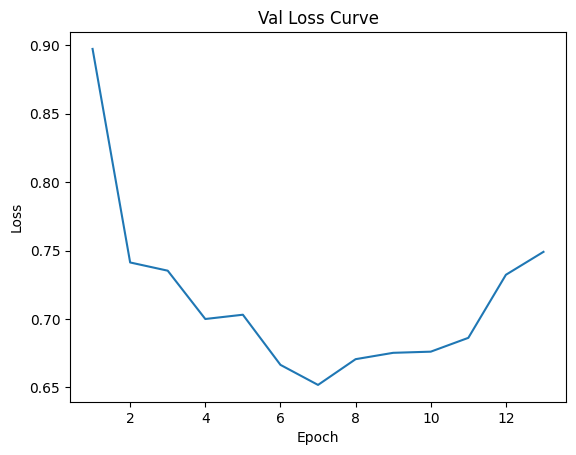

Finished Training Student for lambda value of 0
Student model EfficientNet saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/EfficientNet_lambda0_20231207_084703.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/EfficientNet_weights_lambda0_20231207_084703.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 1/100*****
*****Train Loss:  1.263872 Val Loss:  0.821776*****
*****Validation Accuracy: 21.67%*****
*****Total Avg Disparity: 0.029755264209041447*****

Class Team_Sports: Recall Difference = -0.020689812752053394
Class Celebration: Recall Difference = 0.04361386138613858
Class Parade: Recall Difference = -0.011363636363636354
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.08239700374531839
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = -0.012206572769953048
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.013625718543751317
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to Sm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 2/100*****
*****Train Loss:  1.191960 Val Loss:  0.782018*****
*****Validation Accuracy: 25.66%*****
*****Total Avg Disparity: 0.06919136244806541*****

Class Team_Sports: Recall Difference = 0.11295426763089655
Class Celebration: Recall Difference = 0.009306930693069301
Class Parade: Recall Difference = -0.07102272727272718
Class Waiter_Or_Waitress: Recall Difference = -0.010309278350515464
Class Individual_Sports: Recall Difference = -0.06792290886392
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.08615023474178402
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.005988023952095809
Class Water_Activities: Recall Difference = -0.14104747711305093
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.11802041341452957
Class Family: Recall Difference = 0.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 3/100*****
*****Train Loss:  1.130796 Val Loss:  0.745852*****
*****Validation Accuracy: 26.41%*****
*****Total Avg Disparity: 0.0752058652182044*****

Class Team_Sports: Recall Difference = 0.1442231894985776
Class Celebration: Recall Difference = -0.06797029702970303
Class Parade: Recall Difference = -0.03125
Class Waiter_Or_Waitress: Recall Difference = 0.013745704467353903
Class Individual_Sports: Recall Difference = -0.08208489388264666
Class Surgeons: Recall Difference = -0.005912786400591279
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.16619718309859155
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.2664670658682635
Class Water_Activities: Recall Difference = -0.04939322972109861
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384614
Class Performance_And_Entertainment: Recall Difference = -0.02015610258169654
Class Family: Rec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 4/100*****
*****Train Loss:  1.092839 Val Loss:  0.726661*****
*****Validation Accuracy: 28.60%*****
*****Total Avg Disparity: 0.08909272624494222*****

Class Team_Sports: Recall Difference = 0.09997600849984556
Class Celebration: Recall Difference = 0.0443069306930693
Class Parade: Recall Difference = 0.0009469696969697239
Class Waiter_Or_Waitress: Recall Difference = -0.11798396334478803
Class Individual_Sports: Recall Difference = 0.11302278401997501
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.20117370892018777
Class Business: Recall Difference = -0.026615564782284676
Class Dresses: Recall Difference = -0.16167664670658682
Class Water_Activities: Recall Difference = -0.05769640195869713
Class Picnic: Recall Difference = 0.1111111111111111
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.005746

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 5/100*****
*****Train Loss:  1.056717 Val Loss:  0.696481*****
*****Validation Accuracy: 32.47%*****
*****Total Avg Disparity: 0.09627323622080171*****

Class Team_Sports: Recall Difference = 0.13838525779438138
Class Celebration: Recall Difference = 0.04752475247524757
Class Parade: Recall Difference = -0.02840909090909094
Class Waiter_Or_Waitress: Recall Difference = -0.06032836960672017
Class Individual_Sports: Recall Difference = -0.05181023720349559
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.33333333333333337
Class Law_Enforcement: Recall Difference = 0.24483568075117373
Class Business: Recall Difference = -0.04556584690727136
Class Dresses: Recall Difference = 0.1646706586826347
Class Water_Activities: Recall Difference = 0.029061102831594687
Class Picnic: Recall Difference = 0.026143790849673193
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0088343

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 6/100*****
*****Train Loss:  1.024863 Val Loss:  0.694200*****
*****Validation Accuracy: 29.67%*****
*****Total Avg Disparity: 0.09906440304956346*****

Class Team_Sports: Recall Difference = 0.14902148952942385
Class Celebration: Recall Difference = 0.09712871287128719
Class Parade: Recall Difference = 0.049242424242424254
Class Waiter_Or_Waitress: Recall Difference = -0.01909125620465829
Class Individual_Sports: Recall Difference = -0.023603308364544273
Class Surgeons: Recall Difference = -0.011825572801182557
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.2115023474178403
Class Business: Recall Difference = 0.006494197806877468
Class Dresses: Recall Difference = -0.23552894211576852
Class Water_Activities: Recall Difference = -0.13827975303385137
Class Picnic: Recall Difference = -0.11764705882352941
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.65it/s]


*****Epoch 7/100*****
*****Train Loss:  0.991345 Val Loss:  0.670778*****
*****Validation Accuracy: 33.80%*****
*****Total Avg Disparity: 0.10106555169885462*****

Class Team_Sports: Recall Difference = 0.08546686316847735
Class Celebration: Recall Difference = 0.07732673267326731
Class Parade: Recall Difference = -0.024621212121212155
Class Waiter_Or_Waitress: Recall Difference = -0.21916762122947686
Class Individual_Sports: Recall Difference = -0.028089887640449396
Class Surgeons: Recall Difference = 0.06134515890613451
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.1161971830985915
Class Business: Recall Difference = -0.03257745129351644
Class Dresses: Recall Difference = -0.46107784431137727
Class Water_Activities: Recall Difference = -0.031083670427932752
Class Picnic: Recall Difference = -0.01307189542483661
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = 0.0
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.69it/s]


*****Epoch 8/100*****
*****Train Loss:  0.965596 Val Loss:  0.705490*****
*****Validation Accuracy: 34.08%*****
*****Total Avg Disparity: 0.1119747085396244*****

Class Team_Sports: Recall Difference = 0.07183740617609757
Class Celebration: Recall Difference = -0.045792079207920805
Class Parade: Recall Difference = -0.02083333333333348
Class Waiter_Or_Waitress: Recall Difference = -0.2145857197403589
Class Individual_Sports: Recall Difference = -0.041393570536829016
Class Surgeons: Recall Difference = -0.03621581670362159
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.2633802816901408
Class Business: Recall Difference = -0.025763866709251557
Class Dresses: Recall Difference = -0.3772455089820359
Class Water_Activities: Recall Difference = -0.11017670853736425
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010638297872340425
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 9/100*****
*****Train Loss:  0.926305 Val Loss:  0.686011*****
*****Validation Accuracy: 32.41%*****
*****Total Avg Disparity: 0.08828926597513546*****

Class Team_Sports: Recall Difference = 0.14552558522123593
Class Celebration: Recall Difference = 0.017128712871287144
Class Parade: Recall Difference = 0.008522727272727237
Class Waiter_Or_Waitress: Recall Difference = -0.0706376479572356
Class Individual_Sports: Recall Difference = -0.08282615480649197
Class Surgeons: Recall Difference = 0.04286770140428678
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.09835680751173709
Class Business: Recall Difference = -0.02352815926753965
Class Dresses: Recall Difference = -0.3293413173652695
Class Water_Activities: Recall Difference = -0.015967638918458593
Class Picnic: Recall Difference = -0.16993464052287582
Class Rescue: Recall Difference = 0.02433155080213904
Class Cheering: Recall Difference = 0.009615384615384616
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 10/100*****
*****Train Loss:  0.890022 Val Loss:  0.662210*****
*****Validation Accuracy: 35.76%*****
*****Total Avg Disparity: 0.12445740072631592*****

Class Team_Sports: Recall Difference = 0.12202533959397244
Class Celebration: Recall Difference = 0.052821782178217896
Class Parade: Recall Difference = 0.05303030303030304
Class Waiter_Or_Waitress: Recall Difference = -0.2829324169530355
Class Individual_Sports: Recall Difference = -0.03768726591760302
Class Surgeons: Recall Difference = -0.05986696230598669
Class Spa: Recall Difference = -0.39583333333333337
Class Law_Enforcement: Recall Difference = 0.1776995305164319
Class Business: Recall Difference = -0.04109443202384755
Class Dresses: Recall Difference = -0.282435129740519
Class Water_Activities: Recall Difference = -0.08090270385352355
Class Picnic: Recall Difference = -0.04575163398692811
Class Rescue: Recall Difference = 0.03770053475935829
Class Cheering: Recall Difference = 0.07487725040916532
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 11/100*****
*****Train Loss:  0.853971 Val Loss:  0.716474*****
*****Validation Accuracy: 32.06%*****
*****Total Avg Disparity: 0.10725387159262216*****

Class Team_Sports: Recall Difference = 0.09360112417315014
Class Celebration: Recall Difference = -0.07178217821782173
Class Parade: Recall Difference = -0.0037878787878787845
Class Waiter_Or_Waitress: Recall Difference = -0.16953035509736541
Class Individual_Sports: Recall Difference = -0.04911828963795262
Class Surgeons: Recall Difference = 0.05617147080561727
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.11502347417840375
Class Business: Recall Difference = -0.0591930160758011
Class Dresses: Recall Difference = -0.34331337325349315
Class Water_Activities: Recall Difference = -0.03087076857568663
Class Picnic: Recall Difference = 0.05882352941176472
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.05

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 12/100*****
*****Train Loss:  0.806439 Val Loss:  0.731917*****
*****Validation Accuracy: 36.28%*****
*****Total Avg Disparity: 0.096172451049247*****

Class Team_Sports: Recall Difference = 0.08505558030869065
Class Celebration: Recall Difference = -0.0012871287128712883
Class Parade: Recall Difference = 0.08901515151515149
Class Waiter_Or_Waitress: Recall Difference = -0.21878579610538373
Class Individual_Sports: Recall Difference = -0.008504993757802781
Class Surgeons: Recall Difference = -0.059866962305986704
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.15117370892018778
Class Business: Recall Difference = 0.0027680187373576304
Class Dresses: Recall Difference = -0.41317365269461076
Class Water_Activities: Recall Difference = -0.11038961038961037
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.0008021390374331541
Class Cheering: Recall Difference = -0.021276595744680847
Class Performance_And_E

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 13/100*****
*****Train Loss:  0.763988 Val Loss:  0.755470*****
*****Validation Accuracy: 32.78%*****
*****Total Avg Disparity: 0.10105161140722385*****

Class Team_Sports: Recall Difference = 0.08053146885103568
Class Celebration: Recall Difference = -0.09589108910891089
Class Parade: Recall Difference = -0.0075757575757576245
Class Waiter_Or_Waitress: Recall Difference = -0.159602901870943
Class Individual_Sports: Recall Difference = -0.061173533083645426
Class Surgeons: Recall Difference = -0.01108647450110864
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.1377934272300469
Class Business: Recall Difference = 0.008729905248589381
Class Dresses: Recall Difference = -0.40718562874251496
Class Water_Activities: Recall Difference = 0.1007025761124124
Class Picnic: Recall Difference = -0.1372549019607843
Class Rescue: Recall Difference = 0.03529411764705882
Class Cheering: Recall Difference = -0.007160392798690685
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 14/100*****
*****Train Loss:  0.718330 Val Loss:  0.750626*****
*****Validation Accuracy: 34.11%*****
*****Total Avg Disparity: 0.09878810584360366*****

Class Team_Sports: Recall Difference = 0.13604323039837302
Class Celebration: Recall Difference = -0.011782178217821765
Class Parade: Recall Difference = -0.05776515151515149
Class Waiter_Or_Waitress: Recall Difference = -0.30775105001909125
Class Individual_Sports: Recall Difference = 0.039091760299625467
Class Surgeons: Recall Difference = -0.04730229120473026
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.1349765258215962
Class Business: Recall Difference = 0.03108697966570849
Class Dresses: Recall Difference = -0.33632734530938135
Class Water_Activities: Recall Difference = -0.013945071322120473
Class Picnic: Recall Difference = -0.17647058823529413
Class Rescue: Recall Difference = -0.0069518716577539885
Class Cheering: Recall Difference = 0.035392798690671017
Class Per

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 15/100*****
*****Train Loss:  0.678939 Val Loss:  0.764662*****
*****Validation Accuracy: 33.22%*****
*****Total Avg Disparity: 0.0941162610287762*****

Class Team_Sports: Recall Difference = 0.08676925889113568
Class Celebration: Recall Difference = 0.02742574257425745
Class Parade: Recall Difference = -0.002840909090909005
Class Waiter_Or_Waitress: Recall Difference = -0.0912562046582665
Class Individual_Sports: Recall Difference = -0.08793695380774025
Class Surgeons: Recall Difference = -0.07834441980783441
Class Spa: Recall Difference = -0.3333333333333333
Class Law_Enforcement: Recall Difference = 0.048826291079812234
Class Business: Recall Difference = 0.035026083253486634
Class Dresses: Recall Difference = -0.43712574850299407
Class Water_Activities: Recall Difference = -0.035235256546731875
Class Picnic: Recall Difference = -0.01307189542483661
Class Rescue: Recall Difference = -0.010160427807486626
Class Cheering: Recall Difference = 0.028846153846153844
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 16/100*****
*****Train Loss:  0.628729 Val Loss:  0.852111*****
*****Validation Accuracy: 30.71%*****
*****Total Avg Disparity: 0.08211460817834557*****

Class Team_Sports: Recall Difference = 0.15176337526133604
Class Celebration: Recall Difference = 0.06792079207920793
Class Parade: Recall Difference = 0.02367424242424243
Class Waiter_Or_Waitress: Recall Difference = -0.03398243604429163
Class Individual_Sports: Recall Difference = 0.03807740324594261
Class Surgeons: Recall Difference = -0.028824833702882496
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.04389671361502345
Class Business: Recall Difference = -0.06259980836793358
Class Dresses: Recall Difference = -0.29940119760479045
Class Water_Activities: Recall Difference = -0.11102831594634871
Class Picnic: Recall Difference = -0.06535947712418302
Class Rescue: Recall Difference = 0.06042780748663102
Class Cheering: Recall Difference = -0.022913256955810174
Class Perform

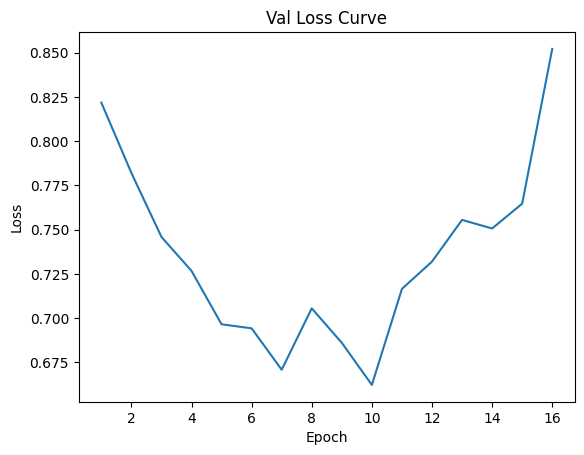

Finished Training Student for lambda value of 0
Student model EfficientNet saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/EfficientNet_lambda0_20231207_091501.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/EfficientNet_weights_lambda0_20231207_091501.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 1/100*****
*****Train Loss:  1.210851 Val Loss:  0.759449*****
*****Validation Accuracy: 25.34%*****
*****Total Avg Disparity: 0.07730579190670019*****

Class Team_Sports: Recall Difference = -0.0009710845300521243
Class Celebration: Recall Difference = -0.03257425742574255
Class Parade: Recall Difference = 0.07386363636363641
Class Waiter_Or_Waitress: Recall Difference = -0.1714394807178312
Class Individual_Sports: Recall Difference = 0.0746332709113608
Class Surgeons: Recall Difference = -0.03621581670362157
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.13802816901408443
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.023952095808383235
Class Water_Activities: Recall Difference = -0.04524164360229935
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.03600654664484451
Class Performance_And_Entertainment: Recall Difference = 0.0648

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 2/100*****
*****Train Loss:  1.116910 Val Loss:  0.725874*****
*****Validation Accuracy: 27.59%*****
*****Total Avg Disparity: 0.07516794749735761*****

Class Team_Sports: Recall Difference = 0.11643874741520155
Class Celebration: Recall Difference = 0.036732673267326654
Class Parade: Recall Difference = 0.04356060606060608
Class Waiter_Or_Waitress: Recall Difference = -0.08476517754868272
Class Individual_Sports: Recall Difference = 0.006788389513108645
Class Surgeons: Recall Difference = -0.09090909090909091
Class Spa: Recall Difference = -0.24999999999999997
Class Law_Enforcement: Recall Difference = 0.07934272300469483
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.0658682634730539
Class Water_Activities: Recall Difference = -0.022993400042580325
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Cla

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 3/100*****
*****Train Loss:  1.062570 Val Loss:  0.701730*****
*****Validation Accuracy: 32.41%*****
*****Total Avg Disparity: 0.11663420076517464*****

Class Team_Sports: Recall Difference = 0.09548617061383968
Class Celebration: Recall Difference = 0.03851485148514851
Class Parade: Recall Difference = 0.12121212121212116
Class Waiter_Or_Waitress: Recall Difference = -0.07674684994272621
Class Individual_Sports: Recall Difference = -0.016073657927590468
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.20328638497652585
Class Business: Recall Difference = -0.10475886298307249
Class Dresses: Recall Difference = -0.3712574850299401
Class Water_Activities: Recall Difference = -0.09463487332339793
Class Picnic: Recall Difference = 0.1241830065359477
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.10172399

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 4/100*****
*****Train Loss:  1.021170 Val Loss:  0.700652*****
*****Validation Accuracy: 32.21%*****
*****Total Avg Disparity: 0.07715347418497133*****

Class Team_Sports: Recall Difference = 0.07728690406827299
Class Celebration: Recall Difference = -0.0818811881188119
Class Parade: Recall Difference = 0.07670454545454553
Class Waiter_Or_Waitress: Recall Difference = -0.32798778159602904
Class Individual_Sports: Recall Difference = 0.007841760299625522
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = 0.02723004694835679
Class Business: Recall Difference = -0.04418183753859259
Class Dresses: Recall Difference = -0.21057884231536925
Class Water_Activities: Recall Difference = 0.016606344475197043
Class Picnic: Recall Difference = -0.019607843137254943
Class Rescue: Recall Difference = 0.03529411764705882
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Diff

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 5/100*****
*****Train Loss:  0.986241 Val Loss:  0.712427*****
*****Validation Accuracy: 33.42%*****
*****Total Avg Disparity: 0.09895048973350912*****

Class Team_Sports: Recall Difference = 0.06531400303892332
Class Celebration: Recall Difference = -0.001980198019801982
Class Parade: Recall Difference = 0.035037878787878785
Class Waiter_Or_Waitress: Recall Difference = -0.20007636502481865
Class Individual_Sports: Recall Difference = -0.005227840199750311
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.09765258215962436
Class Business: Recall Difference = -0.06057702544447993
Class Dresses: Recall Difference = -0.23453093812375256
Class Water_Activities: Recall Difference = -0.1027251437087503
Class Picnic: Recall Difference = -0.17647058823529413
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = 0.04950900163666121
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 6/100*****
*****Train Loss:  0.941591 Val Loss:  0.697000*****
*****Validation Accuracy: 33.97%*****
*****Total Avg Disparity: 0.10622788774459371*****

Class Team_Sports: Recall Difference = 0.05578595012052867
Class Celebration: Recall Difference = -0.08217821782178222
Class Parade: Recall Difference = 0.0018939393939393367
Class Waiter_Or_Waitress: Recall Difference = -0.14662084765177547
Class Individual_Sports: Recall Difference = 0.042563982521847676
Class Surgeons: Recall Difference = 0.0975609756097561
Class Spa: Recall Difference = -0.25
Class Law_Enforcement: Recall Difference = 0.15563380281690148
Class Business: Recall Difference = -0.1384009368678803
Class Dresses: Recall Difference = -0.32335329341317365
Class Water_Activities: Recall Difference = -0.07132212050244835
Class Picnic: Recall Difference = -0.15686274509803924
Class Rescue: Recall Difference = 0.05882352941176471
Class Cheering: Recall Difference = -0.0010229132569558094
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 7/100*****
*****Train Loss:  0.896811 Val Loss:  0.662837*****
*****Validation Accuracy: 37.23%*****
*****Total Avg Disparity: 0.13212122787393615*****

Class Team_Sports: Recall Difference = 0.07872639407752702
Class Celebration: Recall Difference = -0.0461881188118812
Class Parade: Recall Difference = 0.04166666666666663
Class Waiter_Or_Waitress: Recall Difference = -0.25009545628102325
Class Individual_Sports: Recall Difference = -0.0017556179775281566
Class Surgeons: Recall Difference = 0.1286031042128603
Class Spa: Recall Difference = -0.24999999999999997
Class Law_Enforcement: Recall Difference = 0.16220657276995304
Class Business: Recall Difference = -0.12200574896199301
Class Dresses: Recall Difference = -0.5269461077844312
Class Water_Activities: Recall Difference = 0.03310623802427104
Class Picnic: Recall Difference = -0.16339869281045755
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.01677577741407528
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 8/100*****
*****Train Loss:  0.850652 Val Loss:  0.736750*****
*****Validation Accuracy: 34.31%*****
*****Total Avg Disparity: 0.0965373430629047*****

Class Team_Sports: Recall Difference = 0.07010087854588665
Class Celebration: Recall Difference = -0.022376237623762396
Class Parade: Recall Difference = 0.04166666666666663
Class Waiter_Or_Waitress: Recall Difference = -0.2294768995799924
Class Individual_Sports: Recall Difference = -0.04935237203495635
Class Surgeons: Recall Difference = -0.05321507760532154
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.035446009389671296
Class Business: Recall Difference = -0.052379431491536246
Class Dresses: Recall Difference = -0.44311377245508976
Class Water_Activities: Recall Difference = -0.12401532893336181
Class Picnic: Recall Difference = -0.019607843137254898
Class Rescue: Recall Difference = -0.021122994652406413
Class Cheering: Recall Difference = 0.008592471358428808
Class Perf

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 9/100*****
*****Train Loss:  0.796578 Val Loss:  0.750018*****
*****Validation Accuracy: 34.57%*****
*****Total Avg Disparity: 0.0908630445609418*****

Class Team_Sports: Recall Difference = 0.08555825935954131
Class Celebration: Recall Difference = 0.004207920792079198
Class Parade: Recall Difference = 0.06534090909090909
Class Waiter_Or_Waitress: Recall Difference = -0.2107674684994273
Class Individual_Sports: Recall Difference = -0.011118913857677826
Class Surgeons: Recall Difference = 0.15890613451589064
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.046478873239436586
Class Business: Recall Difference = -0.005429575215586069
Class Dresses: Recall Difference = -0.4491017964071856
Class Water_Activities: Recall Difference = -0.017351500958058375
Class Picnic: Recall Difference = 0.013071895424836596
Class Rescue: Recall Difference = 0.023529411764705882
Class Cheering: Recall Difference = -0.0051145662847790554
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 10/100*****
*****Train Loss:  0.750003 Val Loss:  0.766946*****
*****Validation Accuracy: 34.52%*****
*****Total Avg Disparity: 0.12941300776320952*****

Class Team_Sports: Recall Difference = 0.10222663970479023
Class Celebration: Recall Difference = 0.04252475247524748
Class Parade: Recall Difference = 0.12026515151515155
Class Waiter_Or_Waitress: Recall Difference = -0.19243986254295536
Class Individual_Sports: Recall Difference = -0.02567103620474409
Class Surgeons: Recall Difference = -0.05395417590539543
Class Spa: Recall Difference = 0.4166666666666667
Class Law_Enforcement: Recall Difference = 0.15563380281690137
Class Business: Recall Difference = 0.02374108378579795
Class Dresses: Recall Difference = -0.6107784431137724
Class Water_Activities: Recall Difference = -0.05503512880562067
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.036096256684491984
Class Cheering: Recall Difference = 0.002454991816693966
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 11/100*****
*****Train Loss:  0.700687 Val Loss:  0.867900*****
*****Validation Accuracy: 31.17%*****
*****Total Avg Disparity: 0.1267645116570287*****

Class Team_Sports: Recall Difference = 0.04946818841324788
Class Celebration: Recall Difference = -0.04247524752475246
Class Parade: Recall Difference = 0.06439393939393928
Class Waiter_Or_Waitress: Recall Difference = -0.10576555937380683
Class Individual_Sports: Recall Difference = 0.026451310861423216
Class Surgeons: Recall Difference = 0.08647450110864752
Class Spa: Recall Difference = -0.4791666666666666
Class Law_Enforcement: Recall Difference = 0.062206572769953006
Class Business: Recall Difference = -0.01671457468327478
Class Dresses: Recall Difference = -0.4910179640718563
Class Water_Activities: Recall Difference = 0.020225675963380818
Class Picnic: Recall Difference = -0.2156862745098039
Class Rescue: Recall Difference = 0.08315508021390375
Class Cheering: Recall Difference = 0.06423895253682488
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 12/100*****
*****Train Loss:  0.648993 Val Loss:  0.781508*****
*****Validation Accuracy: 33.56%*****
*****Total Avg Disparity: 0.09376764586618183*****

Class Team_Sports: Recall Difference = 0.042921936228307644
Class Celebration: Recall Difference = -0.02668316831683168
Class Parade: Recall Difference = 0.05681818181818177
Class Waiter_Or_Waitress: Recall Difference = -0.1405116456662848
Class Individual_Sports: Recall Difference = 0.048689138576779034
Class Surgeons: Recall Difference = -0.05986696230598666
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = 0.010328638497652531
Class Business: Recall Difference = 0.059086553816671994
Class Dresses: Recall Difference = -0.41317365269461076
Class Water_Activities: Recall Difference = 0.025654673195656952
Class Picnic: Recall Difference = -0.37254901960784315
Class Rescue: Recall Difference = 0.028342245989304793
Class Cheering: Recall Difference = 0.020049099836333878
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 13/100*****
*****Train Loss:  0.594382 Val Loss:  0.829028*****
*****Validation Accuracy: 32.93%*****
*****Total Avg Disparity: 0.09612655767543857*****

Class Team_Sports: Recall Difference = 0.11140053238281289
Class Celebration: Recall Difference = -0.007376237623762383
Class Parade: Recall Difference = -0.0018939393939393923
Class Waiter_Or_Waitress: Recall Difference = -0.17143948071783122
Class Individual_Sports: Recall Difference = -0.007919787765293368
Class Surgeons: Recall Difference = 0.007390983000739149
Class Spa: Recall Difference = 0.0625
Class Law_Enforcement: Recall Difference = 0.0624413145539906
Class Business: Recall Difference = -0.09656126903012885
Class Dresses: Recall Difference = -0.4730538922155688
Class Water_Activities: Recall Difference = -0.001596763891845876
Class Picnic: Recall Difference = -0.3137254901960784
Class Rescue: Recall Difference = 0.07379679144385028
Class Cheering: Recall Difference = -0.052782324058919805
Class Performance_And_E

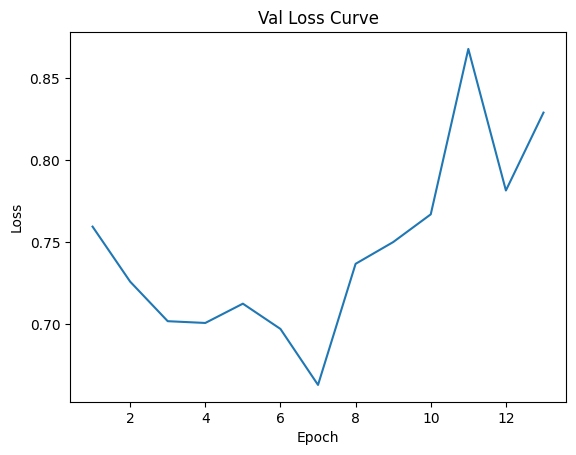

Finished Training Student for lambda value of 0
Student model EfficientNet saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/EfficientNet_lambda0_20231207_094802.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/EfficientNet_weights_lambda0_20231207_094802.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 1/100*****
*****Train Loss:  1.198177 Val Loss:  0.778226*****
*****Validation Accuracy: 26.06%*****
*****Total Avg Disparity: 0.042294929262679755*****

Class Team_Sports: Recall Difference = 0.03698118380916482
Class Celebration: Recall Difference = 0.039207920792079194
Class Parade: Recall Difference = -0.01704545454545453
Class Waiter_Or_Waitress: Recall Difference = -0.1405116456662848
Class Individual_Sports: Recall Difference = 0.030352684144819064
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = -0.006103286384976536
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.03592814371257485
Class Water_Activities: Recall Difference = -0.015861187992335574
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.07376275838408097
Class Family: Recall Difference = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 2/100*****
*****Train Loss:  1.112616 Val Loss:  0.724754*****
*****Validation Accuracy: 29.00%*****
*****Total Avg Disparity: 0.07580518280324001*****

Class Team_Sports: Recall Difference = 0.09579463275867989
Class Celebration: Recall Difference = 0.021930693069306895
Class Parade: Recall Difference = -0.011363636363636354
Class Waiter_Or_Waitress: Recall Difference = -0.12829324169530354
Class Individual_Sports: Recall Difference = -0.05629681647940071
Class Surgeons: Recall Difference = -0.07243163340724318
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = 0.1833333333333333
Class Business: Recall Difference = -0.022357074417119132
Class Dresses: Recall Difference = -0.1317365269461078
Class Water_Activities: Recall Difference = -0.07611241217798598
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.098

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 3/100*****
*****Train Loss:  1.062310 Val Loss:  0.710577*****
*****Validation Accuracy: 31.52%*****
*****Total Avg Disparity: 0.0765690032048194*****

Class Team_Sports: Recall Difference = 0.0880602300899111
Class Celebration: Recall Difference = -0.0203960396039604
Class Parade: Recall Difference = -0.04356060606060608
Class Waiter_Or_Waitress: Recall Difference = -0.2168766704849179
Class Individual_Sports: Recall Difference = -0.08735174781523097
Class Surgeons: Recall Difference = 0.03104212860310422
Class Spa: Recall Difference = -0.10416666666666667
Class Law_Enforcement: Recall Difference = 0.055868544600938985
Class Business: Recall Difference = -0.10305546683700628
Class Dresses: Recall Difference = -0.125748502994012
Class Water_Activities: Recall Difference = -0.017457951884181422
Class Picnic: Recall Difference = -0.09803921568627451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Differe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 4/100*****
*****Train Loss:  1.026578 Val Loss:  0.702028*****
*****Validation Accuracy: 32.15%*****
*****Total Avg Disparity: 0.07673855181020407*****

Class Team_Sports: Recall Difference = 0.03922039049022641
Class Celebration: Recall Difference = 0.003712871287128716
Class Parade: Recall Difference = -0.10700757575757591
Class Waiter_Or_Waitress: Recall Difference = -0.13440244368079418
Class Individual_Sports: Recall Difference = 0.09012172284644196
Class Surgeons: Recall Difference = -0.01773835920177383
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.11220657276995305
Class Business: Recall Difference = -0.04588523368465883
Class Dresses: Recall Difference = -0.2754491017964072
Class Water_Activities: Recall Difference = -0.013945071322120584
Class Picnic: Recall Difference = -0.0392156862745098
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.031914893617021274
Class Performance_And_Entertai

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 5/100*****
*****Train Loss:  0.994164 Val Loss:  0.715262*****
*****Validation Accuracy: 31.54%*****
*****Total Avg Disparity: 0.07819234953378464*****

Class Team_Sports: Recall Difference = 0.1092070237972832
Class Celebration: Recall Difference = 0.05311881188118811
Class Parade: Recall Difference = 0.02935606060606058
Class Waiter_Or_Waitress: Recall Difference = -0.040091638029782384
Class Individual_Sports: Recall Difference = 0.05360486891385774
Class Surgeons: Recall Difference = 0.04878048780487805
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.10892018779342727
Class Business: Recall Difference = -0.16363249228148624
Class Dresses: Recall Difference = -0.31137724550898205
Class Water_Activities: Recall Difference = -0.06589312327017244
Class Picnic: Recall Difference = 0.013071895424836596
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.012684124386252042
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 6/100*****
*****Train Loss:  0.961519 Val Loss:  0.691474*****
*****Validation Accuracy: 33.62%*****
*****Total Avg Disparity: 0.07027022262243197*****

Class Team_Sports: Recall Difference = 0.10246655470633281
Class Celebration: Recall Difference = 0.013712871287128739
Class Parade: Recall Difference = -0.009469696969696961
Class Waiter_Or_Waitress: Recall Difference = -0.06223749522718594
Class Individual_Sports: Recall Difference = 0.01845349563046189
Class Surgeons: Recall Difference = 0.048780487804878044
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.07136150234741784
Class Business: Recall Difference = -0.03768763973171513
Class Dresses: Recall Difference = -0.05988023952095809
Class Water_Activities: Recall Difference = -0.05301256120928244
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Di

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 7/100*****
*****Train Loss:  0.920922 Val Loss:  0.665405*****
*****Validation Accuracy: 35.53%*****
*****Total Avg Disparity: 0.09759832518820957*****

Class Team_Sports: Recall Difference = 0.08262215672161866
Class Celebration: Recall Difference = -0.07257425742574258
Class Parade: Recall Difference = -0.026515151515151436
Class Waiter_Or_Waitress: Recall Difference = -0.0893470790378007
Class Individual_Sports: Recall Difference = -0.08528401997503116
Class Surgeons: Recall Difference = -0.028085735402808565
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.06666666666666676
Class Business: Recall Difference = -0.12849994676887044
Class Dresses: Recall Difference = -0.5149700598802396
Class Water_Activities: Recall Difference = -0.051522248243559776
Class Picnic: Recall Difference = 0.15032679738562088
Class Rescue: Recall Difference = -0.010962566844919783
Class Cheering: Recall Difference = -0.023322422258592473
Class Perf

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 8/100*****
*****Train Loss:  0.882826 Val Loss:  0.735646*****
*****Validation Accuracy: 30.04%*****
*****Total Avg Disparity: 0.0930951209624446*****

Class Team_Sports: Recall Difference = 0.0710605385520558
Class Celebration: Recall Difference = 0.05272277227722774
Class Parade: Recall Difference = -0.025568181818181823
Class Waiter_Or_Waitress: Recall Difference = 0.021764032073310458
Class Individual_Sports: Recall Difference = 0.046465355805243524
Class Surgeons: Recall Difference = 0.07464892830746489
Class Spa: Recall Difference = -0.4583333333333333
Class Law_Enforcement: Recall Difference = 0.19788732394366199
Class Business: Recall Difference = -0.08155009049292028
Class Dresses: Recall Difference = -0.251497005988024
Class Water_Activities: Recall Difference = -0.051522248243559776
Class Picnic: Recall Difference = -0.0196078431372549
Class Rescue: Recall Difference = 0.023529411764705882
Class Cheering: Recall Difference = -0.025368248772504084
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 9/100*****
*****Train Loss:  0.839438 Val Loss:  0.701717*****
*****Validation Accuracy: 36.80%*****
*****Total Avg Disparity: 0.09963652587335853*****

Class Team_Sports: Recall Difference = 0.11239446596063107
Class Celebration: Recall Difference = 0.06792079207920795
Class Parade: Recall Difference = -5.551115123125783e-17
Class Waiter_Or_Waitress: Recall Difference = -0.0912562046582665
Class Individual_Sports: Recall Difference = -0.006437265917603019
Class Surgeons: Recall Difference = 0.0029563932002957816
Class Spa: Recall Difference = -0.5833333333333333
Class Law_Enforcement: Recall Difference = 0.07347417840375586
Class Business: Recall Difference = -0.028638347705738337
Class Dresses: Recall Difference = -0.282435129740519
Class Water_Activities: Recall Difference = 0.01671279540131998
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.001022913256955811
Class Performance_And_Entertai

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 10/100*****
*****Train Loss:  0.802199 Val Loss:  0.847657*****
*****Validation Accuracy: 29.24%*****
*****Total Avg Disparity: 0.09938996109452475*****

Class Team_Sports: Recall Difference = 0.07291131142109653
Class Celebration: Recall Difference = 0.06252475247524752
Class Parade: Recall Difference = -0.06060606060606072
Class Waiter_Or_Waitress: Recall Difference = -0.04581901489117987
Class Individual_Sports: Recall Difference = -0.03179619225967545
Class Surgeons: Recall Difference = 0.04434589800443456
Class Spa: Recall Difference = -0.10416666666666667
Class Law_Enforcement: Recall Difference = 0.19413145539906113
Class Business: Recall Difference = -0.10337485361439364
Class Dresses: Recall Difference = -0.6526946107784432
Class Water_Activities: Recall Difference = -0.058335107515435414
Class Picnic: Recall Difference = 0.026143790849673193
Class Rescue: Recall Difference = 0.02433155080213904
Class Cheering: Recall Difference = 0.002454991816693952
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 11/100*****
*****Train Loss:  0.751394 Val Loss:  0.769069*****
*****Validation Accuracy: 35.90%*****
*****Total Avg Disparity: 0.1419830636411864*****

Class Team_Sports: Recall Difference = 0.08825444699592144
Class Celebration: Recall Difference = 0.04831683168316832
Class Parade: Recall Difference = -0.03598484848484851
Class Waiter_Or_Waitress: Recall Difference = -0.18403970981290574
Class Individual_Sports: Recall Difference = -0.1046738451935082
Class Surgeons: Recall Difference = 0.18920916481892092
Class Spa: Recall Difference = -0.3541666666666667
Class Law_Enforcement: Recall Difference = 0.13286384976525822
Class Business: Recall Difference = -0.018417970829341004
Class Dresses: Recall Difference = -0.37724550898203596
Class Water_Activities: Recall Difference = -0.1116670215030871
Class Picnic: Recall Difference = 0.2026143790849673
Class Rescue: Recall Difference = -0.010160427807486633
Class Cheering: Recall Difference = -0.00306873977086743
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 12/100*****
*****Train Loss:  0.704544 Val Loss:  0.748962*****
*****Validation Accuracy: 34.75%*****
*****Total Avg Disparity: 0.10475253404726828*****

Class Team_Sports: Recall Difference = 0.1396876535170397
Class Celebration: Recall Difference = -0.012673267326732685
Class Parade: Recall Difference = -0.016098484848484862
Class Waiter_Or_Waitress: Recall Difference = 0.030546009927453266
Class Individual_Sports: Recall Difference = -0.04790886392009985
Class Surgeons: Recall Difference = -0.20990391722099033
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.08802816901408445
Class Business: Recall Difference = -0.04620462046204621
Class Dresses: Recall Difference = -0.311377245508982
Class Water_Activities: Recall Difference = -0.1472216308281883
Class Picnic: Recall Difference = -0.0784313725490196
Class Rescue: Recall Difference = 0.03850267379679147
Class Cheering: Recall Difference = -0.007774140752864145
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 13/100*****
*****Train Loss:  0.642443 Val Loss:  0.782733*****
*****Validation Accuracy: 34.57%*****
*****Total Avg Disparity: 0.11493715153744047*****

Class Team_Sports: Recall Difference = 0.06706195519301739
Class Celebration: Recall Difference = 0.035643564356435564
Class Parade: Recall Difference = 0.02651515151515149
Class Waiter_Or_Waitress: Recall Difference = -0.12409316533027867
Class Individual_Sports: Recall Difference = -0.005227840199750311
Class Surgeons: Recall Difference = 0.11603843311160386
Class Spa: Recall Difference = -0.37499999999999994
Class Law_Enforcement: Recall Difference = 0.22136150234741778
Class Business: Recall Difference = -0.027467262855317795
Class Dresses: Recall Difference = -0.4491017964071856
Class Water_Activities: Recall Difference = -0.0283159463487333
Class Picnic: Recall Difference = -0.0196078431372549
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.08694762684124385
Class Performance_And_Entertainm

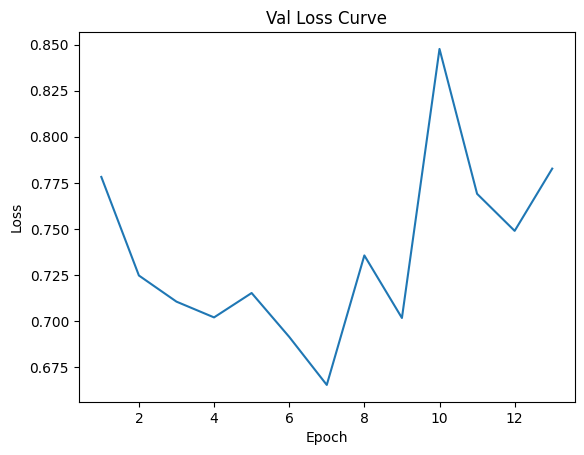

Finished Training Student for lambda value of 0
Student model MobileNetV2 saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/MobileNetV2_lambda0_20231207_101005.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/MobileNetV2_weights_lambda0_20231207_101005.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 1/100*****
*****Train Loss:  1.116622 Val Loss:  0.548885*****
*****Validation Accuracy: 43.78%*****
*****Total Avg Disparity: 0.10414598105310667*****

Class Team_Sports: Recall Difference = 0.039014749060332754
Class Celebration: Recall Difference = -0.13455445544554467
Class Parade: Recall Difference = -0.0028409090909089496
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.1557428214731585
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.1715962441314553
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.3253493013972057
Class Water_Activities: Recall Difference = -0.01139024909516706
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.09177459473368213
Class Family: Recall Difference = -0.00505050505050505

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 2/100*****
*****Train Loss:  0.818408 Val Loss:  0.456101*****
*****Validation Accuracy: 51.17%*****
*****Total Avg Disparity: 0.12748421771052854*****

Class Team_Sports: Recall Difference = 0.07817801693114435
Class Celebration: Recall Difference = 0.04985148514851484
Class Parade: Recall Difference = 0.015151515151515138
Class Waiter_Or_Waitress: Recall Difference = -0.05269186712485696
Class Individual_Sports: Recall Difference = -0.15266073657927592
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.28309859154929584
Class Business: Recall Difference = -0.05951240285318854
Class Dresses: Recall Difference = -0.5998003992015969
Class Water_Activities: Recall Difference = -0.05375771769214388
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = -0.06818181818181818
Class Cheering: Recall Difference = 0.047463175122749585
Class Performance_And_Entertainment: Recall Difference = 0.095548

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 3/100*****
*****Train Loss:  0.651615 Val Loss:  0.434165*****
*****Validation Accuracy: 53.04%*****
*****Total Avg Disparity: 0.13379925268376258*****

Class Team_Sports: Recall Difference = 0.046851972444048484
Class Celebration: Recall Difference = 0.08415841584158401
Class Parade: Recall Difference = 0.05113636363636376
Class Waiter_Or_Waitress: Recall Difference = -0.1351660939289806
Class Individual_Sports: Recall Difference = -0.16206304619225975
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.16009389671361507
Class Business: Recall Difference = -0.037474715213456855
Class Dresses: Recall Difference = -0.658682634730539
Class Water_Activities: Recall Difference = 0.02618692782627219
Class Picnic: Recall Difference = -0.12418300653594772
Class Rescue: Recall Difference = -0.043850267379679134
Class Cheering: Recall Difference = 0.11067921440261869
Class Performance_And_Entertainment: Recall Differ

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 4/100*****
*****Train Loss:  0.513434 Val Loss:  0.439122*****
*****Validation Accuracy: 54.72%*****
*****Total Avg Disparity: 0.13556773824042345*****

Class Team_Sports: Recall Difference = 0.057922336086643655
Class Celebration: Recall Difference = 0.10574257425742584
Class Parade: Recall Difference = 0.027462121212121327
Class Waiter_Or_Waitress: Recall Difference = 0.014891179839633284
Class Individual_Sports: Recall Difference = -0.11711922596754065
Class Surgeons: Recall Difference = -0.015521064301551979
Class Spa: Recall Difference = -0.41666666666666663
Class Law_Enforcement: Recall Difference = 0.19530516431924883
Class Business: Recall Difference = 0.07739806238688385
Class Dresses: Recall Difference = -0.7125748502994012
Class Water_Activities: Recall Difference = -0.0216095380029806
Class Picnic: Recall Difference = -0.1437908496732026
Class Rescue: Recall Difference = -0.01871657754010693
Class Cheering: Recall Difference = 0.023527004909983662
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 5/100*****
*****Train Loss:  0.392933 Val Loss:  0.442283*****
*****Validation Accuracy: 55.64%*****
*****Total Avg Disparity: 0.12698431293411233*****

Class Team_Sports: Recall Difference = 0.11119489095291946
Class Celebration: Recall Difference = 0.15044554455445547
Class Parade: Recall Difference = 0.13257575757575762
Class Waiter_Or_Waitress: Recall Difference = -0.00152730049637273
Class Individual_Sports: Recall Difference = -0.15777153558052437
Class Surgeons: Recall Difference = 0.03325942350332595
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.147887323943662
Class Business: Recall Difference = 0.05365697860108598
Class Dresses: Recall Difference = -0.7365269461077845
Class Water_Activities: Recall Difference = -0.08654460293804567
Class Picnic: Recall Difference = -0.11764705882352944
Class Rescue: Recall Difference = 0.015240641711229963
Class Cheering: Recall Difference = -0.06055646481178395
Class Performance_And_Entertainm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 6/100*****
*****Train Loss:  0.305079 Val Loss:  0.528084*****
*****Validation Accuracy: 54.55%*****
*****Total Avg Disparity: 0.09926309061536451*****

Class Team_Sports: Recall Difference = 0.08635797603134887
Class Celebration: Recall Difference = 0.060643564356435586
Class Parade: Recall Difference = 0.03409090909090906
Class Waiter_Or_Waitress: Recall Difference = -0.07101947308132872
Class Individual_Sports: Recall Difference = -0.147159800249688
Class Surgeons: Recall Difference = -0.0761271249076127
Class Spa: Recall Difference = 0.020833333333333315
Class Law_Enforcement: Recall Difference = 0.14201877934272322
Class Business: Recall Difference = -0.025870328968380762
Class Dresses: Recall Difference = -0.6167664670658684
Class Water_Activities: Recall Difference = -0.040770704705131
Class Picnic: Recall Difference = -0.04575163398692811
Class Rescue: Recall Difference = -0.024064171122994638
Class Cheering: Recall Difference = 0.046644844517184814
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 7/100*****
*****Train Loss:  0.235132 Val Loss:  0.539961*****
*****Validation Accuracy: 53.04%*****
*****Total Avg Disparity: 0.0988037048814846*****

Class Team_Sports: Recall Difference = 0.06641075733168811
Class Celebration: Recall Difference = 0.06544554455445545
Class Parade: Recall Difference = 0.044507575757575746
Class Waiter_Or_Waitress: Recall Difference = -0.01565483008781976
Class Individual_Sports: Recall Difference = -0.06768882646691632
Class Surgeons: Recall Difference = -0.008869179600886956
Class Spa: Recall Difference = 0.12500000000000006
Class Law_Enforcement: Recall Difference = 0.09600938967136152
Class Business: Recall Difference = 0.010326839135526511
Class Dresses: Recall Difference = -0.4980039920159681
Class Water_Activities: Recall Difference = -0.003193527783691752
Class Picnic: Recall Difference = -0.30718954248366026
Class Rescue: Recall Difference = 0.08262032085561494
Class Cheering: Recall Difference = 0.05380523731587561
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 8/100*****
*****Train Loss:  0.177645 Val Loss:  0.521637*****
*****Validation Accuracy: 55.58%*****
*****Total Avg Disparity: 0.12533339494577295*****

Class Team_Sports: Recall Difference = 0.09228730392660889
Class Celebration: Recall Difference = 0.10584158415841588
Class Parade: Recall Difference = 0.03409090909090917
Class Waiter_Or_Waitress: Recall Difference = 0.0397098129056892
Class Individual_Sports: Recall Difference = -0.1246878901373285
Class Surgeons: Recall Difference = 0.027346637102734883
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.08192488262910802
Class Business: Recall Difference = -0.0267220270414138
Class Dresses: Recall Difference = -0.6287425149700598
Class Water_Activities: Recall Difference = -0.018203108367042753
Class Picnic: Recall Difference = 0.019607843137254943
Class Rescue: Recall Difference = 0.11310160427807486
Class Cheering: Recall Difference = 0.019435351882160445
Class Performance_And_Entertainment

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 9/100*****
*****Train Loss:  0.143676 Val Loss:  0.514638*****
*****Validation Accuracy: 55.09%*****
*****Total Avg Disparity: 0.1299546779473568*****

Class Team_Sports: Recall Difference = 0.06306337183397881
Class Celebration: Recall Difference = 0.024851485148514818
Class Parade: Recall Difference = 0.04356060606060619
Class Waiter_Or_Waitress: Recall Difference = 0.07063764795723548
Class Individual_Sports: Recall Difference = -0.11161828963795262
Class Surgeons: Recall Difference = 0.11160384331116036
Class Spa: Recall Difference = -0.4791666666666667
Class Law_Enforcement: Recall Difference = 0.10680751173708936
Class Business: Recall Difference = 0.0033003300330033403
Class Dresses: Recall Difference = -0.7724550898203594
Class Water_Activities: Recall Difference = -0.0366191185863316
Class Picnic: Recall Difference = -0.13725490196078433
Class Rescue: Recall Difference = 0.0002673796791443639
Class Cheering: Recall Difference = 0.0057283142389525366
Class Performanc

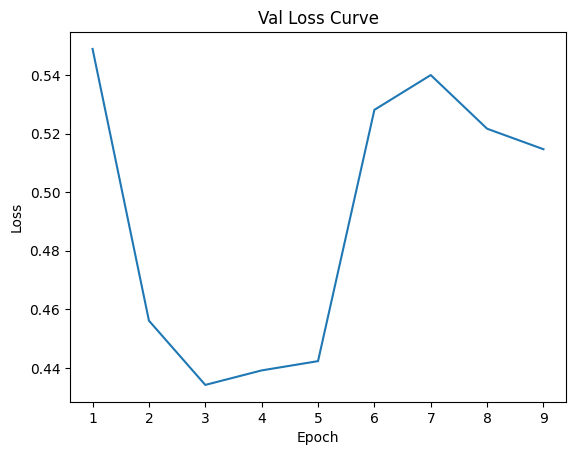

Finished Training Student for lambda value of 0
Student model ShuffleNetV2 saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/ShuffleNetV2_lambda0_20231207_102933.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/ShuffleNetV2_weights_lambda0_20231207_102933.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 1/100*****
*****Train Loss:  1.148650 Val Loss:  0.663913*****
*****Validation Accuracy: 33.54%*****
*****Total Avg Disparity: 0.07466178066493155*****

Class Team_Sports: Recall Difference = 0.06331471135940425
Class Celebration: Recall Difference = 0.02311881188118811
Class Parade: Recall Difference = 0.009469696969696961
Class Waiter_Or_Waitress: Recall Difference = 0.0717831233295151
Class Individual_Sports: Recall Difference = 0.07139513108614232
Class Surgeons: Recall Difference = -0.030303030303030304
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.11666666666666664
Class Business: Recall Difference = 0.014691791759821132
Class Dresses: Recall Difference = -0.3063872255489022
Class Water_Activities: Recall Difference = -0.05354481583989784
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.014973262032085571
Class Cheering: Recall Difference = 0.01861702127659573
Class Performance_And_Entertainment: Recall Differe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 2/100*****
*****Train Loss:  0.997450 Val Loss:  0.612729*****
*****Validation Accuracy: 38.10%*****
*****Total Avg Disparity: 0.08546551439336762*****

Class Team_Sports: Recall Difference = 0.19091521860826455
Class Celebration: Recall Difference = 0.022821782178217842
Class Parade: Recall Difference = 0.020833333333333315
Class Waiter_Or_Waitress: Recall Difference = -0.1718213058419244
Class Individual_Sports: Recall Difference = -0.03971598002496879
Class Surgeons: Recall Difference = 0.0014781966001478353
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = 0.10140845070422527
Class Business: Recall Difference = 0.10199084424571492
Class Dresses: Recall Difference = -0.2574850299401198
Class Water_Activities: Recall Difference = -0.019480519480519543
Class Picnic: Recall Difference = 0.02614379084967322
Class Rescue: Recall Difference = 0.036096256684491984
Class Cheering: Recall Difference = -0.01943535188216039
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 3/100*****
*****Train Loss:  0.909558 Val Loss:  0.620570*****
*****Validation Accuracy: 39.77%*****
*****Total Avg Disparity: 0.09293163855283881*****

Class Team_Sports: Recall Difference = 0.10760759045366786
Class Celebration: Recall Difference = 0.012821782178217833
Class Parade: Recall Difference = 0.005681818181818177
Class Waiter_Or_Waitress: Recall Difference = -0.1909125620465828
Class Individual_Sports: Recall Difference = -0.09441323345817709
Class Surgeons: Recall Difference = -0.15594974131559491
Class Spa: Recall Difference = -0.35416666666666663
Class Law_Enforcement: Recall Difference = 0.07652582159624416
Class Business: Recall Difference = 0.015224103055466842
Class Dresses: Recall Difference = -0.36526946107784436
Class Water_Activities: Recall Difference = 0.017457951884181366
Class Picnic: Recall Difference = 0.026143790849673193
Class Rescue: Recall Difference = 0.0008021390374331541
Class Cheering: Recall Difference = 0.026800327332242236
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 4/100*****
*****Train Loss:  0.854019 Val Loss:  0.488156*****
*****Validation Accuracy: 49.32%*****
*****Total Avg Disparity: 0.09641909383702316*****

Class Team_Sports: Recall Difference = 0.02246061395391341
Class Celebration: Recall Difference = -0.039455445544554435
Class Parade: Recall Difference = 0.0842803030303031
Class Waiter_Or_Waitress: Recall Difference = -0.11683848797250873
Class Individual_Sports: Recall Difference = -0.09078495630461925
Class Surgeons: Recall Difference = -0.1618625277161862
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.04178403755868548
Class Business: Recall Difference = 0.007239433620781388
Class Dresses: Recall Difference = -0.4730538922155688
Class Water_Activities: Recall Difference = 0.024164360229934068
Class Picnic: Recall Difference = -0.006535947712418333
Class Rescue: Recall Difference = 0.04171122994652404
Class Cheering: Recall Difference = -0.039075286415711966
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 5/100*****
*****Train Loss:  0.797686 Val Loss:  0.519729*****
*****Validation Accuracy: 48.51%*****
*****Total Avg Disparity: 0.14221128644772837*****

Class Team_Sports: Recall Difference = 0.1422695959145902
Class Celebration: Recall Difference = 0.04693069306930692
Class Parade: Recall Difference = 0.08806818181818188
Class Waiter_Or_Waitress: Recall Difference = -0.030546009927453266
Class Individual_Sports: Recall Difference = -0.009714419475655378
Class Surgeons: Recall Difference = -0.11899482631189956
Class Spa: Recall Difference = -0.4375
Class Law_Enforcement: Recall Difference = 0.2171361502347418
Class Business: Recall Difference = 0.038645800063877356
Class Dresses: Recall Difference = -0.6167664670658682
Class Water_Activities: Recall Difference = -0.07217372791143284
Class Picnic: Recall Difference = -0.20261437908496732
Class Rescue: Recall Difference = 0.03155080213903744
Class Cheering: Recall Difference = -0.060965630114566266
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 6/100*****
*****Train Loss:  0.763622 Val Loss:  0.486311*****
*****Validation Accuracy: 50.22%*****
*****Total Avg Disparity: 0.12741287040847166*****

Class Team_Sports: Recall Difference = 0.043161851229849946
Class Celebration: Recall Difference = 0.04742574257425741
Class Parade: Recall Difference = 0.0
Class Waiter_Or_Waitress: Recall Difference = 0.004581901489117857
Class Individual_Sports: Recall Difference = -0.0797440699126093
Class Surgeons: Recall Difference = -0.10051736881005163
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.21971830985915497
Class Business: Recall Difference = 0.015437027573725115
Class Dresses: Recall Difference = -0.6407185628742516
Class Water_Activities: Recall Difference = -0.083776878858846
Class Picnic: Recall Difference = -0.15032679738562094
Class Rescue: Recall Difference = 0.02754010695187166
Class Cheering: Recall Difference = -0.018617021276595758
Class Performance_And_Entertainmen

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 7/100*****
*****Train Loss:  0.712341 Val Loss:  0.489302*****
*****Validation Accuracy: 50.74%*****
*****Total Avg Disparity: 0.12115426533625222*****

Class Team_Sports: Recall Difference = 0.13408963681438568
Class Celebration: Recall Difference = 0.004851485148514967
Class Parade: Recall Difference = 0.021780303030302983
Class Waiter_Or_Waitress: Recall Difference = -0.10003818251240937
Class Individual_Sports: Recall Difference = -0.07061485642946319
Class Surgeons: Recall Difference = 0.014781966001478297
Class Spa: Recall Difference = -0.3333333333333333
Class Law_Enforcement: Recall Difference = 0.22605633802816888
Class Business: Recall Difference = -0.02416693282231447
Class Dresses: Recall Difference = -0.5808383233532933
Class Water_Activities: Recall Difference = -0.01958697040664248
Class Picnic: Recall Difference = -0.08496732026143794
Class Rescue: Recall Difference = 0.06684491978609627
Class Cheering: Recall Difference = -0.06342062193126018
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 8/100*****
*****Train Loss:  0.684293 Val Loss:  0.538718*****
*****Validation Accuracy: 47.04%*****
*****Total Avg Disparity: 0.13058233477519018*****

Class Team_Sports: Recall Difference = 0.08846008842581482
Class Celebration: Recall Difference = 0.03935643564356428
Class Parade: Recall Difference = 0.030303030303030276
Class Waiter_Or_Waitress: Recall Difference = -0.19854906452844595
Class Individual_Sports: Recall Difference = -0.04564606741573041
Class Surgeons: Recall Difference = -0.02143385070214321
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.2356807511737089
Class Business: Recall Difference = 0.020014904716278092
Class Dresses: Recall Difference = -0.6407185628742514
Class Water_Activities: Recall Difference = -0.010645092612305729
Class Picnic: Recall Difference = -0.17647058823529413
Class Rescue: Recall Difference = -0.048395721925133695
Class Cheering: Recall Difference = -0.017798690671031098
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 9/100*****
*****Train Loss:  0.648912 Val Loss:  0.499939*****
*****Validation Accuracy: 51.86%*****
*****Total Avg Disparity: 0.13816068392338895*****

Class Team_Sports: Recall Difference = 0.09184174749517315
Class Celebration: Recall Difference = -0.09445544554455448
Class Parade: Recall Difference = 0.12215909090909094
Class Waiter_Or_Waitress: Recall Difference = -0.1042382588774341
Class Individual_Sports: Recall Difference = -0.07073189762796517
Class Surgeons: Recall Difference = -0.06577974870657799
Class Spa: Recall Difference = -0.5416666666666666
Class Law_Enforcement: Recall Difference = 0.14295774647887316
Class Business: Recall Difference = -0.06632598743745344
Class Dresses: Recall Difference = -0.5568862275449102
Class Water_Activities: Recall Difference = -0.06323185011709598
Class Picnic: Recall Difference = -0.05882352941176472
Class Rescue: Recall Difference = 0.07459893048128342
Class Cheering: Recall Difference = 0.008797054009819949
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 10/100*****
*****Train Loss:  0.609300 Val Loss:  0.481964*****
*****Validation Accuracy: 50.59%*****
*****Total Avg Disparity: 0.11665556271138869*****

Class Team_Sports: Recall Difference = 0.1499583004878272
Class Celebration: Recall Difference = 0.012227722772277183
Class Parade: Recall Difference = 0.02272727272727293
Class Waiter_Or_Waitress: Recall Difference = -0.06529209621993137
Class Individual_Sports: Recall Difference = -0.06339731585518105
Class Surgeons: Recall Difference = 0.08721359940872125
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.07887323943661972
Class Business: Recall Difference = 0.08847013733631426
Class Dresses: Recall Difference = -0.6047904191616768
Class Water_Activities: Recall Difference = -0.01139024909516706
Class Picnic: Recall Difference = -0.06535947712418311
Class Rescue: Recall Difference = 0.004010695187165791
Class Cheering: Recall Difference = 0.0038870703764320724
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 11/100*****
*****Train Loss:  0.571631 Val Loss:  0.464717*****
*****Validation Accuracy: 52.47%*****
*****Total Avg Disparity: 0.11506385081002718*****

Class Team_Sports: Recall Difference = 0.06989523711599333
Class Celebration: Recall Difference = 0.021534653465346554
Class Parade: Recall Difference = -0.03882575757575768
Class Waiter_Or_Waitress: Recall Difference = -0.022145857197403584
Class Individual_Sports: Recall Difference = -0.08895131086142322
Class Surgeons: Recall Difference = 0.06947524020694751
Class Spa: Recall Difference = -0.4791666666666667
Class Law_Enforcement: Recall Difference = 0.12065727699530515
Class Business: Recall Difference = 0.018843819865857536
Class Dresses: Recall Difference = -0.562874251497006
Class Water_Activities: Recall Difference = 0.04534809452842237
Class Picnic: Recall Difference = -0.04575163398692811
Class Rescue: Recall Difference = 0.07700534759358293
Class Cheering: Recall Difference = -0.04603109656301152
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 12/100*****
*****Train Loss:  0.543969 Val Loss:  0.498213*****
*****Validation Accuracy: 52.70%*****
*****Total Avg Disparity: 0.08943539735866224*****

Class Team_Sports: Recall Difference = 0.05836789251807939
Class Celebration: Recall Difference = -0.0038613861386138093
Class Parade: Recall Difference = -0.02462121212121221
Class Waiter_Or_Waitress: Recall Difference = 0.012982054219167538
Class Individual_Sports: Recall Difference = -0.038896691635455505
Class Surgeons: Recall Difference = 0.04508499630450852
Class Spa: Recall Difference = 0.04166666666666663
Class Law_Enforcement: Recall Difference = 0.15046948356807527
Class Business: Recall Difference = -0.016501650165016535
Class Dresses: Recall Difference = -0.5578842315369262
Class Water_Activities: Recall Difference = 0.011922503725782407
Class Picnic: Recall Difference = -0.2679738562091504
Class Rescue: Recall Difference = 0.022994652406417126
Class Cheering: Recall Difference = -0.03355155482815056
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 13/100*****
*****Train Loss:  0.516367 Val Loss:  0.502382*****
*****Validation Accuracy: 51.08%*****
*****Total Avg Disparity: 0.1438175005489411*****

Class Team_Sports: Recall Difference = 0.06106408015445952
Class Celebration: Recall Difference = 0.038514851485148494
Class Parade: Recall Difference = -0.02556818181818188
Class Waiter_Or_Waitress: Recall Difference = -0.2088583428789615
Class Individual_Sports: Recall Difference = -0.12347846441947569
Class Surgeons: Recall Difference = 0.01552106430155209
Class Spa: Recall Difference = -0.20833333333333334
Class Law_Enforcement: Recall Difference = 0.2305164319248827
Class Business: Recall Difference = 0.07601405301820507
Class Dresses: Recall Difference = -0.6526946107784432
Class Water_Activities: Recall Difference = 0.06238024270811171
Class Picnic: Recall Difference = -0.19607843137254904
Class Rescue: Recall Difference = 0.02219251336898398
Class Cheering: Recall Difference = -0.08183306055646483
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 14/100*****
*****Train Loss:  0.478377 Val Loss:  0.488533*****
*****Validation Accuracy: 53.54%*****
*****Total Avg Disparity: 0.10813400355594971*****

Class Team_Sports: Recall Difference = 0.1713564337206247
Class Celebration: Recall Difference = -0.015148514851485162
Class Parade: Recall Difference = -0.02083333333333337
Class Waiter_Or_Waitress: Recall Difference = -0.046582665139366375
Class Individual_Sports: Recall Difference = -0.0895365168539326
Class Surgeons: Recall Difference = -0.045824094604582255
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.07535211267605635
Class Business: Recall Difference = 0.04205259235600989
Class Dresses: Recall Difference = -0.592814371257485
Class Water_Activities: Recall Difference = -0.048222269533744866
Class Picnic: Recall Difference = -0.065359477124183
Class Rescue: Recall Difference = -0.024064171122994638
Class Cheering: Recall Difference = -0.07017184942716853
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 15/100*****
*****Train Loss:  0.447571 Val Loss:  0.470879*****
*****Validation Accuracy: 52.21%*****
*****Total Avg Disparity: 0.13017416210421523*****

Class Team_Sports: Recall Difference = 0.116987124561584
Class Celebration: Recall Difference = -0.038762376237623686
Class Parade: Recall Difference = -0.02367424242424243
Class Waiter_Or_Waitress: Recall Difference = -0.08972890416189383
Class Individual_Sports: Recall Difference = -0.12343945068664164
Class Surgeons: Recall Difference = 0.008869179600887012
Class Spa: Recall Difference = -0.35416666666666663
Class Law_Enforcement: Recall Difference = 0.10821596244131454
Class Business: Recall Difference = -0.01937613116150322
Class Dresses: Recall Difference = -0.6407185628742513
Class Water_Activities: Recall Difference = 0.0022354694485842153
Class Picnic: Recall Difference = -0.09803921568627455
Class Rescue: Recall Difference = 0.10053475935828879
Class Cheering: Recall Difference = -0.043780687397708656
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 16/100*****
*****Train Loss:  0.410465 Val Loss:  0.536646*****
*****Validation Accuracy: 51.77%*****
*****Total Avg Disparity: 0.12890365455129266*****

Class Team_Sports: Recall Difference = 0.06839862448732448
Class Celebration: Recall Difference = 0.09584158415841587
Class Parade: Recall Difference = -0.058712121212121104
Class Waiter_Or_Waitress: Recall Difference = -0.21076746849942726
Class Individual_Sports: Recall Difference = -0.04439762796504376
Class Surgeons: Recall Difference = 0.033259423503326
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.20352112676056333
Class Business: Recall Difference = -0.0066006600660065695
Class Dresses: Recall Difference = -0.7245508982035928
Class Water_Activities: Recall Difference = -0.058441558441558406
Class Picnic: Recall Difference = -0.02614379084967322
Class Rescue: Recall Difference = -0.04999999999999999
Class Cheering: Recall Difference = -0.0036824877250409283
Class Perf

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 17/100*****
*****Train Loss:  0.378007 Val Loss:  0.614451*****
*****Validation Accuracy: 52.29%*****
*****Total Avg Disparity: 0.11479495565323028*****

Class Team_Sports: Recall Difference = 0.03418217545783775
Class Celebration: Recall Difference = 0.05633663366336633
Class Parade: Recall Difference = 0.005681818181818232
Class Waiter_Or_Waitress: Recall Difference = -0.20694921725849552
Class Individual_Sports: Recall Difference = -0.020911360799001355
Class Surgeons: Recall Difference = 0.057649667405765104
Class Spa: Recall Difference = -0.12499999999999989
Class Law_Enforcement: Recall Difference = 0.12816901408450698
Class Business: Recall Difference = -0.06174811029490046
Class Dresses: Recall Difference = -0.7005988023952097
Class Water_Activities: Recall Difference = -0.02437726208218005
Class Picnic: Recall Difference = -0.065359477124183
Class Rescue: Recall Difference = -0.006149732620320814
Class Cheering: Recall Difference = -0.007774140752864173
Class Perfor

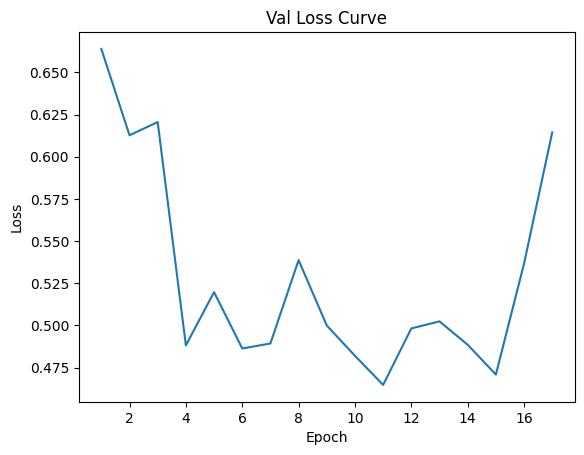

Finished Training Student for lambda value of 0
Student model SqueezeNet saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/models/SqueezeNet_lambda0_20231207_104100.pth
Weights saved for lambda 0 to Smaller_Student_Models_Not_Pretrained_11/weights/SqueezeNet_weights_lambda0_20231207_104100.pth


In [31]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # Load the teacher model with lambda 0
    teacher_model_path = os.path.join(output_dir, 'teacher_model_ckd_wider_lambda0.pth')
    teacher_model = torch.load(teacher_model_path)
    teacher_model_weights_path = os.path.join(output_dir, 'teacher_model_weights_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load(teacher_model_weights_path))
    teacher_model = teacher_model.to(device)
        
    for student_model in student_models:
        model_name = type(student_model).__name__
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"{model_name}_lambda{i}_{timestamp}.pth"
        weights_filename = f"{model_name}_weights_lambda{i}_{timestamp}.pth"

        # Reset the optimizer for the student model for each lambda
        student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
        
        # Initialize the adversary
        adv = Adversary()
        student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
        
        # Pretrain student and adversary if i != 0
        if i != 0:
            pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
            pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
        
        # Train the student model with knowledge distillation and disparity reduction
        student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, 
                                                                                   adv_criterion, student_optimizer, student_optimizer_adv, device, alpha, 
                                                                                   temperature, epochs, lmda=i, patience=patience_student)
    
        # Save the trained student model and its weights
        model_save_path = os.path.join(models_dir, model_filename)
        weights_save_path = os.path.join(weights_dir, weights_filename)
    
        torch.save(student_model, model_save_path)
        torch.save(student_model.state_dict(), weights_save_path)
    
        print(f"Student model {model_name} saved for lambda {i} to {model_save_path}")
        print(f"Weights saved for lambda {i} to {weights_save_path}")
    
        # Update the dictionary with the student results
        if i not in lambda_results:
            lambda_results[i] = {model_name: {'student_mean_abs_val_disparity': student_mean_abs_val_disparity}}
        else:
            if model_name not in lambda_results[i]:
                lambda_results[i][model_name] = {'student_mean_abs_val_disparity': student_mean_abs_val_disparity}
            else:
                lambda_results[i][model_name].update({'student_mean_abs_val_disparity': student_mean_abs_val_disparity})


In [32]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time


In [33]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load the teacher model for the current lambda from the 'output_dir'
        teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
        teacher_model = torch.load(teacher_model_path)
        
        # Load the student model for the current lambda from the 'output_dir'
        student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
        student_model = torch.load(student_model_path)
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }


FileNotFoundError: [Errno 2] No such file or directory: 'Smaller_Student_Models_Not_Pretrained_11/student_model_ckd_wider_lambda0.pth'

In [ ]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting only with markers and no lines
plt.scatter(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.scatter(student_lambdas, student_acc, label='Student Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()

# Show plot
plt.show()


In [ ]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# Extracting lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.scatter(student_lambdas, student_prec, label='Student Precision', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# Extracting lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.scatter(student_lambdas, student_rec, label='Student Recall', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# Extracting lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.scatter(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# Extracting lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.scatter(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model for the current lambda
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in lmda_list_student:
    # Load the student model for the current lambda
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Extracting lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.scatter(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            # Take the last value if there are multiple
            teacher_disparity = teacher_disparity[-1] if isinstance(teacher_disparity, list) else teacher_disparity
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            # Take the last value if there are multiple
            student_disparity = student_disparity[-1] if isinstance(student_disparity, list) else student_disparity
            student_disparities.append((key, student_disparity))

# Extracting lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Creating a scatter plot
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.scatter(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.scatter(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model from the 'output_dir'
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model from the 'output_dir'
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [ ]:
def plot_images_with_class_filter(info_list, display_class, new_label_mapping, rows=10, cols=5):
    # Filter the info list based on the specified class, student correct and teacher incorrect predictions
    filtered_info = [info for info in info_list if info['actual_class'] == display_class and 
                     info['student_pred_class'] == display_class and 
                     info['teacher_pred_class'] != display_class]

    # Calculate the number of images to display based on the length of the filtered list
    num_images = len(filtered_info)
    total_plots = min(rows * cols, num_images)  # Ensure we don't exceed the number of filtered images

    # Determine the number of rows needed based on the number of images
    rows = (num_images + cols - 1) // cols

    # Create a figure with the adjusted number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.ravel()

    for i in range(total_plots):
        data = filtered_info[i]
        image = data['image']
        actual_class = new_label_mapping[data['actual_class']]  # Get class name from the mapping
        teacher_pred_class = new_label_mapping[data['teacher_pred_class']]  # Get class name from the mapping
        student_pred_class = new_label_mapping[data['student_pred_class']]  # Get class name from the mapping
        actual_attribute = round(data['actual_attribute'], 3)
    
        # Normalize the image for display
        image_display = image.cpu().numpy().transpose(1, 2, 0)
        image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())
    
        # Set the title with the class and attribute information
        title = f'Attr: {actual_attribute}\nTrue: {actual_class}\nTeacher: {teacher_pred_class}\nStudent: {student_pred_class}'
    
        axes[i].imshow(image_display)
        axes[i].set_title(title, fontsize=12, pad=4)
        axes[i].axis('off')

    # Turn off any unused axes
    for i in range(total_plots, len(axes)):
        axes[i].axis('off')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.show()


In [ ]:
teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda0.pth')
teacher_model = torch.load(teacher_model_path)
student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda4.pth')
student_model = torch.load(student_model_path)

# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

for i in range(num_classes):
    # Display images with details
    print('#'*60)
    print(f'CLASS {i}: {new_label_mapping[i]}')
    print('#'*60)
    plot_images_with_class_filter(detailed_info, display_class=i, new_label_mapping=new_label_mapping, rows=10, cols=5)


In [ ]:
def get_disparities_accuracies_student(lmda, dataloader):
    model_path = os.path.join(output_dir,f'student_model_ckd_wider_lambda{lmda}.pth') 
    model = torch.load(model_path)
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [ ]:
for i in lmda_list_student:
    get_disparities_accuracies_student(i, testloader)

In [ ]:
def get_disparities_accuracies_teacher(lmda, dataloader):
    model_path = os.path.join(output_dir,f'teacher_model_ckd_wider_lambda{lmda}.pth') 
    model = torch.load(model_path)
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [ ]:
get_disparities_accuracies_teacher(0, testloader)

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Data for plotting
labels = ['Teacher (λ=0)', 'Student (λ=0)', 'Student (λ=8)']
waiter_or_waitress_values = [-0.0925, -0.1082, 0.0046]
individual_sports_values = [-0.1208, -0.1345, -0.0794]

# Number of bars
n_bars = len(labels)

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of the bars

# Positions of the bars on the x-axis
r1 = range(n_bars)
r2 = [x + bar_width for x in r1]

# Creating the bars with improved colors
plt.bar(r1, waiter_or_waitress_values, color=colors[0], width=bar_width, edgecolor='grey', label='Waiter Or Waitress')
plt.bar(r2, individual_sports_values, color=colors[1], width=bar_width, edgecolor='grey', label='Individual Sports')

# Adding data labels
for i in range(n_bars):
    plt.text(r1[i] - bar_width/8, waiter_or_waitress_values[i], f'{waiter_or_waitress_values[i]:.4f}', ha='center', va='bottom')
    plt.text(r2[i] - bar_width/8, individual_sports_values[i], f'{individual_sports_values[i]:.4f}', ha='center', va='bottom')

# General layout
plt.ylabel('Disparity Values')
plt.title('Disparity')
plt.xticks([r + bar_width/2 for r in range(n_bars)], labels)
plt.legend()

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Data
models = ["EfficientNet B2", "EfficientNet B1", "EfficientNet B0", "MobileNetV2", 
          "ShuffleNet", "SqueezeNet", "Custom Small CNN"]
accuracy = [63.12, 63.35, 63.61, 58.07, 54.49, 50.65, 36.19]
mean_absolute_disparity = [0.1807, 0.1411, 0.1143, 0.1262, 0.1337, 0.1413, 0.0782]
size = [7723538, 6533680, 4028044, 2244368, 1270004, 743632, 112732]

# Plotting the individual plots
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Accuracy
ax[0].bar(models, accuracy, color='blue')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_xticklabels(models, rotation=45, ha="right")

# Mean Absolute Disparity
ax[1].bar(models, mean_absolute_disparity, color='green')
ax[1].set_title('Model Mean Absolute Disparity')
ax[1].set_ylabel('Disparity')
ax[1].set_xticklabels(models, rotation=45, ha="right")

# Size
ax[2].bar(models, size, color='red')
ax[2].set_title('Model Size')
ax[2].set_ylabel('Total Parameters')
ax[2].set_xticklabels(models, rotation=45, ha="right")

plt.tight_layout()

# 3D plot
fig_3d = plt.figure(figsize=(10, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Scatter plot
sc = ax_3d.scatter(accuracy, mean_absolute_disparity, size, c=size, cmap='viridis')

# Labeling each point
for i, txt in enumerate(models):
    ax_3d.text(accuracy[i], mean_absolute_disparity[i], size[i], txt, size=10, zorder=1, color='k')

ax_3d.set_xlabel('Accuracy (%)')
ax_3d.set_ylabel('Mean Absolute Disparity')
ax_3d.set_zlabel('Total Parameters')

plt.show()
